## **0. Giới thiệu**
Trong lĩnh vực chăm sóc sức khỏe, việc phát hiện và phòng ngừa sớm đóng vai trò then chốt trong việc kiểm soát các tình trạng mãn tính và cải thiện kết quả của bệnh nhân. **Đái tháo đường** hay **tiểu đường** là một nhóm các rối loạn chuyển hóa đặc trưng là tình trạng đường huyết cao kéo dài, đây là một bệnh phổ biến gây những rủi ro đáng kể nếu không được điều trị kịp thời. Trong bối cảnh khoa học phát triển, việc tích hợp các kỹ thuật học máy hứa hẹn sẽ cách mạng hóa các hoạt động chăm sóc sức khỏe, đặc biệt là trong phân tích và dự đoán.

<div style="display: flex; justify-content: center">
    <img
        src="https://media.licdn.com/dms/image/v2/D4E12AQFzvBcN0L5pGg/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1700613031139?e=2147483647&v=beta&t=9IxUSLYBHu4idDvlS6F_HqYX5Z1iIOXgbL9iH1C_dc0"
        alt="Application Machine Learning in diabetes prediction"
        style="width: 800px;"
    />
</div>

Trong dự án lần này, chúng ta sẽ tập trung vào việc phân tích các yếu tố nguy cơ và xây dựng một hệ thống dự đoán khả năng mắc bệnh tiểu đường dựa trên bộ dữ liệu từ **Behavioral Risk Factor Surveillance System (BRFSS)** năm 2021 của CDC cung cấp.

Trong dự án này, chúng ta sẽ sử dụng bộ dữ liệu `diabetes_012_health_indicators_BRFSS2021`, vì đây là một bộ dữ liệu có nhiều record để giúp mô hình học tốt hơn, ngoài ra bộ dữ liệu này có các class chi tiết hơn so với 2 bộ lại. Bộ dữ liệu này đặc biệt thú vị vì nó không chỉ phân loại người bệnh thành hai nhóm (có/không có tiểu đường) mà còn bao gồm cả giai đoạn tiền tiểu đường (Có khả năng bị tiểu đường). Điều này cho phép chúng ta có cái nhìn chi tiết hơn về quá trình phát triển của bệnh và các yếu tố ảnh hưởng.

## **1. Thư viện**

Trong phần này, chúng ta sẽ thêm những thư viện yêu cầu cần thiết cho dự án Diabetes Prediction. Các thư viện chính bao gồm:

- **Thư viện xử lý dữ liệu**
  - **Numpy** và **Pandas**: Hai thư viện chuyên dụng cho quá trình thao tác với dữ liệu
  - **os** và **warnings**: Các thư viện Python cơ bản hỗ trợ xử lý hệ thống và cảnh báo
- **Thư viện trực quan hóa**
 - **Matplotlib** và **Seaborn**: Hai thư viện phổ biến trong việc trực quan hóa dữ liệu và thực hiện các Exploration Data Analysis (EDA)
- **Thư viện Machine Learning Scikit-learn**
  - **train_test_split**: Hỗ trợ chia dữ liệu thành tập train và test
  - **MinMaxScaler**, **LabelEncoder**: Xử lý và chuẩn hóa dữ liệu
  - **RandomForestClassifier**, **KNeighborsClassifier**, **MLPClassifier**: Các mô hình phân loại
  - **GridSearchCV**: Tối ưu hóa tham số
  - **Các metrics đánh giá**: accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, classification_report
- **Imbalanced-learn**
  - **SMOTE**, **ADASYN**: Các phương pháp over-sampling
  - **TomekLinks**: Phương pháp under-sampling
  - **SMOTETomek**: Phương pháp kết hợp
- **1.4 Thư viện lưu trữ**
  - **joblib**: Hỗ trợ lưu và tải mô hình
- **1.5 Cấu hình cơ bản**
  - Thiết lập style cho matplotlib
  - Ẩn các cảnh báo không cần thiết
  - Xác định số lượng CPU cores để tối ưu tính toán song song

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, classification_report

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

import os
import warnings
import joblib

plt.style.use('seaborn-v0_8')
# Ẩn những cảnh báo của các thư viện
warnings.filterwarnings('ignore')

# Số lượng core cpu
num_of_core = os.cpu_count()
print(f'Số lượng core của CPU là {num_of_core}')

Số lượng core của CPU là 8


In [4]:
# Đường dẫn đến dự án trên drive (Thay đổi dựa trên vị trí bạn đặt project trên drive
# Thông thường phần /content/drive/My Drive/ là mặc định dẫn đến folder My Drive trên Google Drive)
project_path = r'/content/drive/My Drive/My-Projects/Machine-Learning/diabetes-prediction/'
# Kiểm tra có đang chạy trên colab hay không
if 'COLAB_GPU' in os.environ:
  from google.colab import drive
  # Mount đến trên drive
  drive.mount('/content/drive/')
  # Chuyển đến thư mục project trên drive
  os.chdir(project_path)

## **2. Dataset**

Trong dự án này, chúng ta sẽ sử dụng bộ dữ liệu `diabetes_012_health_indicators_BRFSS2021`, vì đây là một bộ dữ liệu có đầy đủ các record để giúp mô hình học tốt hơn, ngoài ra bộ dữ liệu này có các class chi tiết hơn so với 2 bộ lại. Bộ dữ liệu này đặc biệt thú vị vì nó không chỉ phân loại người bệnh thành hai nhóm (có/không có tiểu đường) mà còn bao gồm cả giai đoạn tiền tiểu đường (Có khả năng bị tiểu đường). Điều này cho phép chúng ta có cái nhìn chi tiết hơn về quá trình phát triển của bệnh và các yếu tố ảnh hưởng.

- **Tên tệp**: `diabetes_012_health_indicators_BRFSS2021.csv`
- **Số lượng mẫu**: 236,378
- **Số lượng cột**: 22
- **Mục tiêu**: Cột `Diabetes_012` (0: Không bị tiểu đường, 1: Tiền tiểu đường, 2: Tiểu đường).
- **Các cột đặc trưng**: Bao gồm chỉ số BMI, huyết áp cao, cholesterol, hoạt động thể chất, và các yếu tố nhân khẩu học như tuổi, giới tính, thu nhập, v.v.

Bảng mô tả ý nghĩa các cột:

| Tên cột | Mô tả |
|:--------|:-------|
| Diabetes_012 | Tình trạng tiểu đường (0: không, 1: tiền tiểu đường, 2: tiểu đường) |
| HighBP | Huyết áp cao (0: không, 1: có) |
| HighChol | Cholesterol cao (0: không, 1: có) |
| CholCheck | Kiểm tra Cholesterol trong 5 năm qua (0: không, 1: có) |
| BMI | Chỉ số khối cơ thể |
| Smoker | Đã từng hút thuốc ít nhất 100 điếu trong đời (0: không, 1: có) |
| Stroke | Đã từng bị đột quỵ (0: không, 1: có) |
| HeartDiseaseorAttack | Đã từng mắc bệnh tim hoặc đau tim (0: không, 1: có) |
| PhysActivity | Hoạt động thể chất trong 30 ngày qua (0: không, 1: có) |
| Fruits | Ăn trái cây ít nhất 1 lần/ngày (0: không, 1: có) |
| Veggies | Ăn rau ít nhất 1 lần/ngày (0: không, 1: có) |
| HvyAlcoholConsump | Uống rượu bia nặng (nam >14 ly/tuần, nữ >7 ly/tuần) (0: không, 1: có) |
| AnyHealthcare | Có bất kỳ bảo hiểm y tế nào (0: không, 1: có) |
| NoDocbcCost | Không đi khám bác sĩ vì chi phí trong 12 tháng qua (0: không, 1: có) |
| GenHlth | Đánh giá sức khỏe tổng quát (1-5: xuất sắc đến kém) |
| MentHlth | Số ngày sức khỏe tâm thần không tốt trong 30 ngày qua (0-30) |
| PhysHlth | Số ngày sức khỏe thể chất không tốt trong 30 ngày qua (0-30) |
| DiffWalk | Khó khăn khi đi bộ hoặc leo cầu thang (0: không, 1: có) |
| Sex | Giới tính (0: nữ, 1: nam) |
| Age | Nhóm tuổi (1: 18-24, 2: 25-29, ..., 13: 80+ tuổi) |
| Education | Trình độ học vấn (1: chưa bao giờ đi học hoặc đã học mẫu giáo, 2: đã học tiểu học, 3: đã học cấp 2, 4: tốt nghiệp cấp 3, 5: sinh viên năm 1-3, 6: sinh viên năm 4 hoặc đã tốt nghiệp đại học) |
| Income | Thu nhập hàng năm (1: dưới $10,000, 2: $10,000-$15,000, ..., 8: $75,000+) |

Trong phần này chúng ta sẽ sử dụng thư viện **Pandas**, đây là một thư viện phổ biến trong xử lý và phân tich dữ liệu. Dữ liệu được trả về từ thư viện Pandas thường sẽ dưới dạng **DataFrame**, đây là một một cấu trúc dạng bảng giúp chúng ta dễ dàng đọc, khám phá, trực quan hóa và chuẩn bị dữ liệu huấn luyện cho mô hình.

Để load dữ liệu, chúng ta sẽ tạo một hàm load dữ liệu, nhưng đặc biệt hơn là thay vì tải dữ liệu bằng phương pháp thủ công thì hàm `load_data_from_github()` sẽ kiểm tra nếu dữ liệu chưa tồn tại thì sẽ gọi đến repository của **Github** để fetch dữ liệu và lưu vào máy local, dữ liệu sau khi fetch về sẽ dưới dạng DataFrame với tên biến là `diabetes_df`.

In [7]:
def load_dataset():
    '''
        Hàm load dữ liệu diabetes_012_health_indecators_BRRSS2021.csv
        Return:
            pandas.DataFrame: DateFrame chứa dữ liệu diabetes_012_health_indicators_BRFSS2021
    '''
    # Đường dẫn đến file csv
    csv_path = './data/diabetes_012_health_indicators_BRFSS2021.csv'
    # Nếu file dữ liệu đã tồn tại trong dự án
    if os.path.exists(csv_path):
        print('File đã tồn tại trong thư mục data, đang đọc file...')
        return pd.read_csv(csv_path)

    # Tải dữ liệu dữ liệu chưa tốn tại
    if not os.path.exists('data'):
        print('Đang khởi tạo thư mục chứ dữ liệu...')
        os.mkdir('data')
        # Fetch dữ liệu từ github
        try:
            print('Dữ liệu chưa tồn tại trong thư mục data, đang kết nối và tải dữ liệu từ github...')
            # URL của file csv
            raw_url = 'https://raw.githubusercontent.com/lngquoctrung/diabetes-prediction-machine-learning/refs/heads/main/data/diabetes_012_health_indicators_BRFSS2021.csv'
            # Tải file
            dataframe = pd.read_csv(raw_url)
            print('Tải dữ liệu thành công, đang lưu dữ liệu xuống local...')
            dataframe.to_csv(csv_path, index=False)
            print('Lưu dữ liệu thành công.')
            return dataframe
        # Lỗi kết nối đến đường dẫn
        except Exception as e:
            print(f'Đã có lỗi xảy ra: {str(e)}')
            return None


In [8]:
# Gọi hàm để tải và load dữ liệu
diabetes_df = load_dataset()
diabetes_df.head()

Đang khởi tạo thư mục chứ dữ liệu...
Dữ liệu chưa tồn tại trong thư mục data, đang kết nối và tải dữ liệu từ github...
Tải dữ liệu thành công, đang lưu dữ liệu xuống local...
Lưu dữ liệu thành công.


Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0       0       1.0          1  15.0     1.0     0.0   
1           2.0       1       0.0          1  28.0     0.0     0.0   
2           2.0       1       1.0          1  33.0     0.0     0.0   
3           2.0       0       1.0          1  29.0     0.0     1.0   
4           0.0       0       0.0          1  24.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0             0       1  ...              1   
1                   1.0             0       1  ...              1   
2                   0.0             1       1  ...              1   
3                   1.0             1       1  ...              1   
4                   0.0             0       0  ...              1   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  \
0          0.0      5.0      10.0      20.0       0.0    0   11        4.0   
1          0.0      2.0       0.0       0.0       0.0    0   11        4.0   
2          0.0      2.0      10.0       0.0       0.0    0    9        4.0   
3          0.0      5.0       0.0      30.0       1.0    1   12        3.0   
4          0.0      3.0       0.0       0.0       1.0    1   13        5.0   

   Income  
0     5.0  
1     3.0  
2     7.0  
3     4.0  
4     6.0  

[5 rows x 22 columns]

## **3. Trực quan hóa dữ liệu**

Trước khi bước vào huấn luyện mô hình, chúng ta cần phải khám phá dữ liệu xem dữ liệu sẽ trong như thế nào, kiểm tra các cột đã phù hợp để chuẩn bị cho quá trình huấn luyện hay chưa. Bên cạnh đó chúng ta cần phải trực quan hóa dữ liệu để có cái nhìn tốt hơn về bộ dữ liệu như độ tương quan giữa các cột, giá trị min, max, giá trị kỳ vọng, phương sai,... của từng cột trông như thế nào. Đầu tiên là chúng ta sẽ gọi đến hàm `shape()` để xem được số dòng và cột của bộ dữ liệu như thế nào.

### **3.1 Số dòng và cột**

In [11]:
# Số dòng và số cột của bộ dữ liệu
diabetes_df.shape

(236378, 22)

### **3.2 Những dòng đầu và cuối của bộ dữ liệu**

Chúng ta đã biết là dữ liệu có 236378 hàng và 22 cột. Tiếp sau đó là gọi đến hàm `head()` và `tail()` đế xem được 5 hàng đầu tiên và 5 hàng cuối cùng trong bộ dữ liệu. Note: Nếu hai hàm `head()` và `tail()` không truyền số hàng vào thì mặc định sẽ là 5.

In [14]:
# 5 dòng đầu của bộ dữ liệu
diabetes_df.head()

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0       0       1.0          1  15.0     1.0     0.0   
1           2.0       1       0.0          1  28.0     0.0     0.0   
2           2.0       1       1.0          1  33.0     0.0     0.0   
3           2.0       0       1.0          1  29.0     0.0     1.0   
4           0.0       0       0.0          1  24.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0             0       1  ...              1   
1                   1.0             0       1  ...              1   
2                   0.0             1       1  ...              1   
3                   1.0             1       1  ...              1   
4                   0.0             0       0  ...              1   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  \
0          0.0      5.0      10.0      20.0       0.0    0   11        4.0   
1          0.0      2.0       0.0       0.0       0.0    0   11        4.0   
2          0.0      2.0      10.0       0.0       0.0    0    9        4.0   
3          0.0      5.0       0.0      30.0       1.0    1   12        3.0   
4          0.0      3.0       0.0       0.0       1.0    1   13        5.0   

   Income  
0     5.0  
1     3.0  
2     7.0  
3     4.0  
4     6.0  

[5 rows x 22 columns]

In [15]:
# 5 dòng cuối của bộ dữ liệu
diabetes_df.tail()

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
236373           2.0       1       1.0          1  21.0     0.0     0.0   
236374           0.0       1       0.0          1  25.0     1.0     0.0   
236375           0.0       0       1.0          1  31.0     0.0     0.0   
236376           0.0       1       0.0          1  24.0     0.0     0.0   
236377           0.0       0       1.0          1  32.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
236373                   0.0             1       1  ...              1   
236374                   0.0             1       1  ...              0   
236375                   0.0             1       1  ...              1   
236376                   0.0             1       1  ...              1   
236377                   0.0             1       0  ...              1   

        NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  \
236373          0.0      4.0       0.0       0.0       0.0    1   10   
236374          1.0      2.0      20.0       0.0       0.0    0    3   
236375          0.0      2.0       0.0       0.0       0.0    1    7   
236376          0.0      2.0       0.0       0.0       0.0    1   10   
236377          0.0      1.0       2.0       2.0       0.0    0    6   

        Education  Income  
236373        2.0     3.0  
236374        4.0     5.0  
236375        6.0    10.0  
236376        4.0     6.0  
236377        6.0     6.0  

[5 rows x 22 columns]

Để kiểm tra được các cột của dữ liệu có các thuộc tính nào thì chúng ta sẽ gọi đến thuộc tính `columns` của DataFrame, thuộc tính này sẽ trả về tên của các cột trong bộ dữ liệu. Sau đó, chúng ta sẽ gọi đến thuộc tính `dtypes` của DataFrame, thuộc tính này sẽ trả về thông tin kiểu dữ liệu của từng cột là gì?. Hàm `info()` là hàm sẽ thống kế lại toàn bộ những thông tin cần thiết của một bộ dữ liệu như số dòng, số cột, tên cột, kiểu dữ liệu, ...

### **3.3 Tên cột và kiểu dữ liệu mỗi cột**

In [18]:
# Các cột của bộ dữ liệu
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [19]:
# Kiểu dữ liệu của các cột trong bộ dữ liệu
diabetes_df.dtypes

Diabetes_012            float64
HighBP                    int64
HighChol                float64
CholCheck                 int64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity              int64
Fruits                    int64
Veggies                   int64
HvyAlcoholConsump         int64
AnyHealthcare             int64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                       int64
Age                       int64
Education               float64
Income                  float64
dtype: object

### **3.4 Thông tin tổng quan về bộ dữ liệu**

In [21]:
# Tổng quan về bộ dữ liệu
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236378 entries, 0 to 236377
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          236378 non-null  float64
 1   HighBP                236378 non-null  int64  
 2   HighChol              236378 non-null  float64
 3   CholCheck             236378 non-null  int64  
 4   BMI                   236378 non-null  float64
 5   Smoker                236378 non-null  float64
 6   Stroke                236378 non-null  float64
 7   HeartDiseaseorAttack  236378 non-null  float64
 8   PhysActivity          236378 non-null  int64  
 9   Fruits                236378 non-null  int64  
 10  Veggies               236378 non-null  int64  
 11  HvyAlcoholConsump     236378 non-null  int64  
 12  AnyHealthcare         236378 non-null  int64  
 13  NoDocbcCost           236378 non-null  float64
 14  GenHlth               236378 non-null  float64
 15  

Sau khi gọi hàm `info()` thì chúng ta có thể thấy được rằng bộ dữ liệu có thể gọi là *khá hoàn chỉnh*, vì các cột dữ liệu hầu như không hề có các giá trị null nên là chúng ta có thể bỏ qua bước xử lý dữ liệu null. Ngoài việc kiểm tra thông tin của bộ dữ liệu, chúng ta cần tiến hành bước trực quan hóa dữ liệu để có cái nhìn tốt hơn về bộ dữ liệu

In [23]:
# Thống kê tổng quan về min, max, std,... của từng cột
diabetes_df.describe().T

count       mean       std   min   25%   50%   75%  \
Diabetes_012          236378.0   0.307791  0.705037   0.0   0.0   0.0   0.0   
HighBP                236378.0   0.418558  0.493324   0.0   0.0   0.0   1.0   
HighChol              236378.0   0.402059  0.490315   0.0   0.0   0.0   1.0   
CholCheck             236378.0   0.963347  0.187909   0.0   1.0   1.0   1.0   
BMI                   236378.0  28.953579  6.552055  12.0  24.0  28.0  32.0   
Smoker                236378.0   0.411997  0.492196   0.0   0.0   0.0   1.0   
Stroke                236378.0   0.038900  0.193356   0.0   0.0   0.0   0.0   
HeartDiseaseorAttack  236378.0   0.086548  0.281172   0.0   0.0   0.0   0.0   
PhysActivity          236378.0   0.779231  0.414766   0.0   1.0   1.0   1.0   
Fruits                236378.0   0.621259  0.485074   0.0   0.0   1.0   1.0   
Veggies               236378.0   0.827767  0.377583   0.0   1.0   1.0   1.0   
HvyAlcoholConsump     236378.0   0.062083  0.241306   0.0   0.0   0.0   0.0   
AnyHealthcare         236378.0   0.962573  0.189807   0.0   1.0   1.0   1.0   
NoDocbcCost           236378.0   0.063737  0.244284   0.0   0.0   0.0   0.0   
GenHlth               236378.0   2.480717  1.029134   1.0   2.0   2.0   3.0   
MentHlth              236378.0   3.937710  7.886506   0.0   0.0   0.0   4.0   
PhysHlth              236378.0   3.751297  8.245907   0.0   0.0   0.0   2.0   
DiffWalk              236378.0   0.153948  0.360900   0.0   0.0   0.0   0.0   
Sex                   236378.0   0.477824  0.499509   0.0   0.0   0.0   1.0   
Age                   236378.0   7.863930  3.236997   1.0   5.0   8.0  10.0   
Education             236378.0   5.139099  0.946185   1.0   4.0   5.0   6.0   
Income                236378.0   6.927451  2.375450   1.0   5.0   7.0   9.0   

                       max  
Diabetes_012           2.0  
HighBP                 1.0  
HighChol               1.0  
CholCheck              1.0  
BMI                   99.0  
Smoker                 1.0  
Stroke                 1.0  
HeartDiseaseorAttack   1.0  
PhysActivity           1.0  
Fruits                 1.0  
Veggies                1.0  
HvyAlcoholConsump      1.0  
AnyHealthcare          1.0  
NoDocbcCost            1.0  
GenHlth                5.0  
MentHlth              30.0  
PhysHlth              30.0  
DiffWalk               1.0  
Sex                    1.0  
Age                   13.0  
Education              6.0  
Income                11.0

### **3.5 Phân phối của BMI, tuổi, tình trạng sức khỏe và bệnh tiểu đường**

Phần trực quan hóa bên dưới cho ta thấy được tổng quan về một vài cột trong bộ dữ liệu.

- Đối với cột `BMI`, thì đồ thị historgram của cột `BMI` cho đường cong hình chuông có xu hướng lệch về trái, phần lớn tập trung vào khoảng 20-30, thì đây là khoảng được cho là `Normal` và `Overweight` (theo [WHO](https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations)), tức là giao động trong khoảng chỉ số BMI bình thường hoặc thừa cân nhẹ. Bên cạnh đó, chúng ta thấy được từ bảng thống kê tổng quan phía trên thì cột BMI có trung bình cộng rơi vào khoảng 28-29, tức là bộ dữ liệu cho thấy rằng phần lớn các dòng dữ liệu đều có phần chỉ số BMI nằm ở mức được cho là **khuyến nghị** theo WHO.
- Đối với cột `Age`, đây là cột được chia theo nhóm tuổi của [tháp tuổi](https://en.wikipedia.org/wiki/Population_pyramid), theo CDC thì đây là bộ dữ liệu khảo sát người từ 18 tuổi trở lên nên cột `Age` sẽ có giá trị từ $18\to80+$ và được chia làm $13$ cột, tức là mỗi nhóm sẽ có độ tuổi giao dộng từ $4\to5$ tuổi $(\frac{(80 - 18)}{13})$. Có thể thấy được tổng quan bộ dữ liệu được khảo sát từ những người từ độ tuổi trung niên nhiều hơn so với người trẻ và người già.
- Phần đánh giá sức khỏe tổng quát `GenHlth` là đánh giá điểm sức khỏe của một người nào đó ở 5 mức là 1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor. Phần lớn các dòng dữ liệu cho thấy rằng những người tham gia khảo sát có mức điểm sức khỏe đều ở mức tốt.
- Từ đó cho thấy được tỉ lệ người mắc bệnh tiểu đường hoặc tiền tiểu đường trong bộ dữ liệu khá ít so với không mắc bệnh.

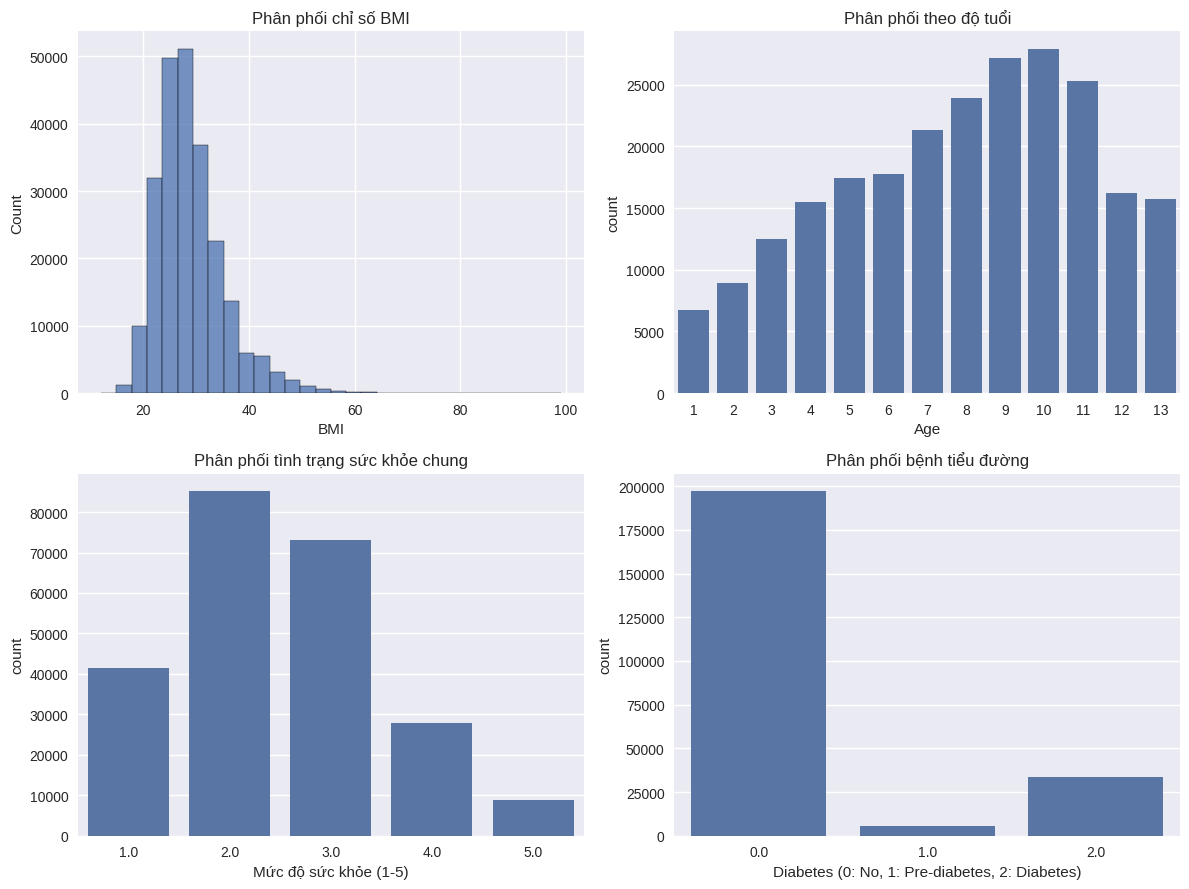

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

# Phân phối chỉ số BMI
sns.histplot(data=diabetes_df, x='BMI', bins=30, ax=ax[0, 0])
ax[0, 0].set_title('Phân phối chỉ số BMI')
ax[0, 0].set_xlabel('BMI')

# Phân phối theo độ tuổi
sns.countplot(data=diabetes_df, x='Age', ax=ax[0, 1])
ax[0, 1].set_title('Phân phối theo độ tuổi')
ax[0, 1].set_xlabel('Age')

# Phân phối tình trạng sức khỏe
sns.countplot(data=diabetes_df, x='GenHlth', ax=ax[1, 0])
ax[1, 0].set_title('Phân phối tình trạng sức khỏe chung')
ax[1, 0].set_xlabel('Mức độ sức khỏe (1-5)')

# Phân phối ca bệnh tiểu đường
sns.countplot(data=diabetes_df, x='Diabetes_012', ax=ax[1, 1])
ax[1, 1].set_title('Phân phối bệnh tiểu đường')
ax[1, 1].set_xlabel('Diabetes (0: No, 1: Pre-diabetes, 2: Diabetes)')

plt.tight_layout()
plt.show()

Để có một cái nhìn rõ ràng hơn, chúng ta sẽ trực quan hóa dữ liệu chi tiết một chút nữa, lần này mỗi biểu đồ chúng ta sẽ thêm tham số `hue='Diabetes_012` vào để cho đồ thị tách thành từng cột thành từng nhóm nhỏ được phân làm 3 cột dựa theo label `Diabetes_012`. Dựa theo kết quả cho thấy, phần lớn những người có chỉ số BMI ở mức 30 (thừa cân) và độ tuổi ở nhóm 10 và 11 (63-68 và 69-74) có điểm đánh giá sức khỏe là 3 hoặc 4 có nguy cơ cao bị tiền tiểu đường và tiểu đường cao nhất. **Điều này cho thấy những người lớn tuổi bị thừa cân thường và chỉ số sức khỏe không tốt sẽ dễ bị tiểu đường**

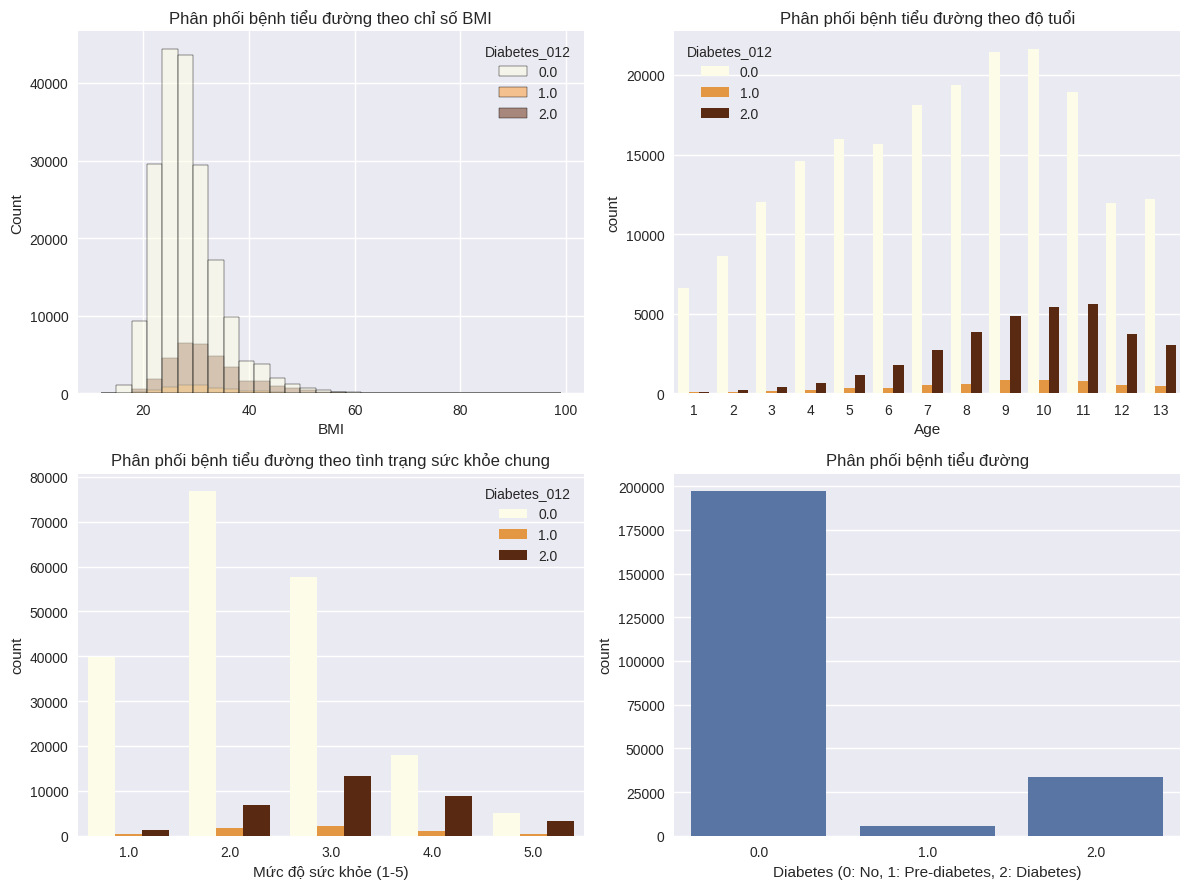

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

# Phân phối bệnh tiểu đường theo chỉ số BMI
sns.histplot(data=diabetes_df, x='BMI', bins=30, hue='Diabetes_012', palette='YlOrBr', ax=ax[0, 0])
ax[0, 0].set_title('Phân phối bệnh tiểu đường theo chỉ số BMI')
ax[0, 0].set_xlabel('BMI')

# Phân phối bệnh tiểu đường theo độ tuổi
sns.countplot(data=diabetes_df, x='Age', hue='Diabetes_012', dodge=True, palette='YlOrBr', ax=ax[0, 1])
ax[0, 1].set_title('Phân phối bệnh tiểu đường theo độ tuổi')
ax[0, 1].set_xlabel('Age')

# Phân phối bệnh tiểu đường theo tình trạng sức khỏe
sns.countplot(data=diabetes_df, x='GenHlth', hue='Diabetes_012', dodge=True, palette='YlOrBr', ax=ax[1, 0])
ax[1, 0].set_title('Phân phối bệnh tiểu đường theo tình trạng sức khỏe chung')
ax[1, 0].set_xlabel('Mức độ sức khỏe (1-5)')

# Phân phối ca bệnh tiểu đường
sns.countplot(data=diabetes_df, x='Diabetes_012', ax=ax[1, 1])
ax[1, 1].set_title('Phân phối bệnh tiểu đường')
ax[1, 1].set_xlabel('Diabetes (0: No, 1: Pre-diabetes, 2: Diabetes)')

plt.tight_layout()
plt.show()

### **3.6 Độ tương quan giữa các feature**

Để biết được những nhân tố nào ảnh hướng đến một ai đó có kết quả mắc tiểu đường hay không thì chúng ta cần xem kỹ qua các những thuộc tính khác, và để biết được những nhân tố nào ảnh hưởng nhiều nhất đến cột `Diabetes_012`, chúng ta sẽ sử dụng đến phương pháp tính độ tương quan ([correlation coefficient](https://www.investopedia.com/terms/c/correlationcoefficient.asp#:~:text=The%20correlation%20coefficient%20is%20a,other%20decline%2C%20and%20vice%20versa.)) giữa các thuộc tính của dữ liệu. Thay vì tính toán bằng phương pháp thủ công thì Pandas có cung cấp sẵn hàm `corr()` giúp chúng ta thực hiện việc tính toán dễ dàng.

In [30]:
# Độ tương quan giữa các thuộc tính
diabetes_df.corr()

Diabetes_012    HighBP  HighChol  CholCheck       BMI  \
Diabetes_012              1.000000  0.269086  0.207435   0.072222  0.211801   
HighBP                    0.269086  1.000000  0.283285   0.099415  0.213951   
HighChol                  0.207435  0.283285  1.000000   0.098558  0.087188   
CholCheck                 0.072222  0.099415  0.098558   1.000000  0.036226   
BMI                       0.211801  0.213951  0.087188   0.036226  1.000000   
Smoker                    0.058910  0.099570  0.082402  -0.012874  0.016289   
Stroke                    0.102715  0.126594  0.085947   0.025386  0.010241   
HeartDiseaseorAttack      0.177432  0.203191  0.170668   0.043867  0.039518   
PhysActivity             -0.151657 -0.132253 -0.076648  -0.008454 -0.163979   
Fruits                   -0.030489 -0.031542 -0.024408   0.024951 -0.089897   
Veggies                  -0.047853 -0.036013 -0.031931   0.017397 -0.047900   
HvyAlcoholConsump        -0.058904 -0.003424 -0.014275  -0.028933 -0.032644   
AnyHealthcare             0.026366  0.049833  0.056505   0.154640 -0.009609   
NoDocbcCost               0.016355 -0.007477 -0.012307  -0.071406  0.048165   
GenHlth                   0.288377  0.281555  0.187101   0.042176  0.254835   
MentHlth                  0.039154  0.011743  0.019851  -0.015560  0.088455   
PhysHlth                  0.163922  0.140946  0.104846   0.031339  0.120976   
DiffWalk                  0.216233  0.208262  0.127667   0.044966  0.199165   
Sex                       0.033815  0.067557  0.029081  -0.048143  0.007928   
Age                       0.198600  0.345390  0.287937   0.102707 -0.050161   
Education                -0.108539 -0.106342 -0.035434   0.030341 -0.098964   
Income                   -0.160146 -0.150292 -0.068196   0.021765 -0.102487   

                        Smoker    Stroke  HeartDiseaseorAttack  PhysActivity  \
Diabetes_012          0.058910  0.102715              0.177432     -0.151657   
HighBP                0.099570  0.126594              0.203191     -0.132253   
HighChol              0.082402  0.085947              0.170668     -0.076648   
CholCheck            -0.012874  0.025386              0.043867     -0.008454   
BMI                   0.016289  0.010241              0.039518     -0.163979   
Smoker                1.000000  0.057064              0.111283     -0.093729   
Stroke                0.057064  1.000000              0.177667     -0.078759   
HeartDiseaseorAttack  0.111283  0.177667              1.000000     -0.097710   
PhysActivity         -0.093729 -0.078759             -0.097710      1.000000   
Fruits               -0.071277 -0.000428             -0.006846      0.118245   
Veggies              -0.016522 -0.024646             -0.024645      0.136527   
HvyAlcoholConsump     0.098949 -0.013768             -0.028314      0.014532   
AnyHealthcare        -0.023686  0.015463              0.025104      0.024926   
NoDocbcCost           0.046932  0.021849              0.014479     -0.050100   
GenHlth               0.166432  0.159723              0.239646     -0.284207   
MentHlth              0.084626  0.045176              0.034660     -0.116034   
PhysHlth              0.113428  0.131955              0.170468     -0.248385   
DiffWalk              0.123640  0.162562              0.194299     -0.284294   
Sex                   0.073719  0.001288              0.085596      0.058629   
Age                   0.123354  0.128892              0.223501     -0.119369   
Education            -0.178179 -0.061672             -0.080808      0.211932   
Income               -0.148127 -0.115004             -0.124740      0.239828   

                        Fruits  ...  AnyHealthcare  NoDocbcCost   GenHlth  \
Diabetes_012         -0.030489  ...       0.026366     0.016355  0.288377   
HighBP               -0.031542  ...       0.049833    -0.007477  0.281555   
HighChol             -0.024408  ...       0.056505    -0.012307  0.187101   
CholCheck             0.024951  ...       0.154640    -

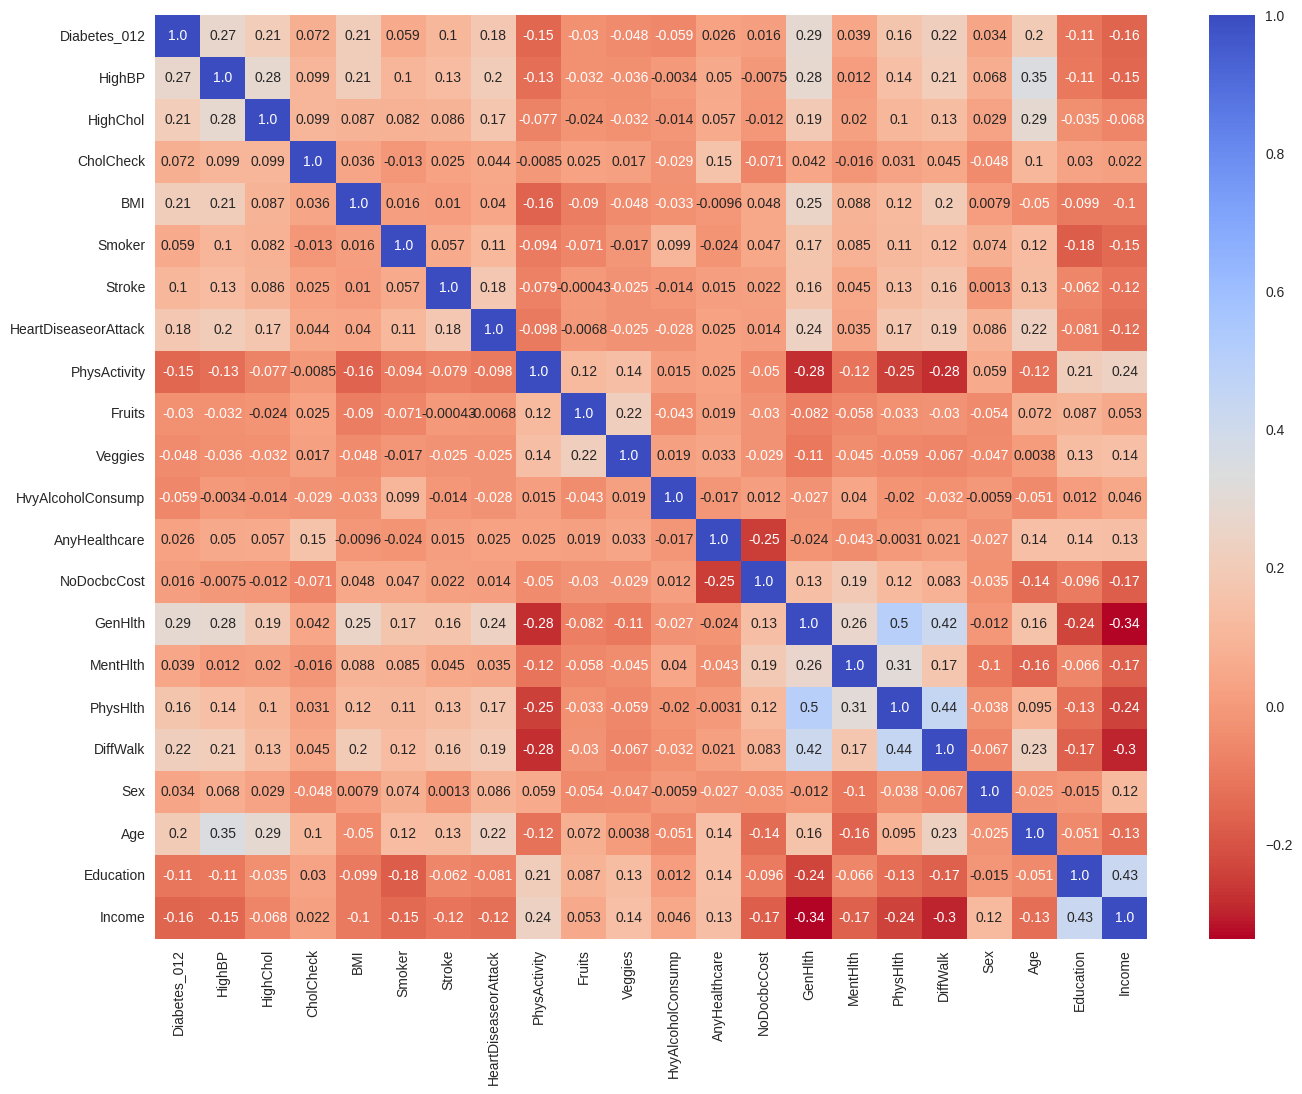

In [31]:
# Biểu đồ nhiệt thể hiện độ tương quan giữa các feature
plt.figure(figsize=(16, 12))
ax = sns.heatmap(diabetes_df.corr(), cmap='coolwarm_r', fmt='.2', annot=True)
plt.show()

Có thể thấy được những nhân tố như điểm đánh giá sức khỏe tổng quát `GenHlth`, huyết áp cao `HighBP`, khó khăn khi đi bộ `DiffWalk`, ... ảnh hưởng nhiều nhất đến kết quả của việc mắc bệnh tiểu đường hay không. Đối với các thuộc tính như `Income` thì chúng cho thấy rằng chúng cũng có sự ảnh hưởng, nhưng thay vì ảnh hưởng cùng chiều với `Diabetes_012` thì chúng sẽ có sự ảnh hưởng nghịch đảo, tức là nếu `Income` giảm thì `Diabetes_012` sẽ tăng. Còn những giá trị có độ tương quan giao động ở khoảng gần 0 thì chúng sẽ ít ảnh hưởng đến kết quả đánh giá bệnh nhất.

In [33]:
# Những nhân tố ảnh hướng đến kết quả dự đoán
diabetes_df.corr()['Diabetes_012'].iloc[1:].sort_values(ascending=False)

GenHlth                 0.288377
HighBP                  0.269086
DiffWalk                0.216233
BMI                     0.211801
HighChol                0.207435
Age                     0.198600
HeartDiseaseorAttack    0.177432
PhysHlth                0.163922
Stroke                  0.102715
CholCheck               0.072222
Smoker                  0.058910
MentHlth                0.039154
Sex                     0.033815
AnyHealthcare           0.026366
NoDocbcCost             0.016355
Fruits                 -0.030489
Veggies                -0.047853
HvyAlcoholConsump      -0.058904
Education              -0.108539
PhysActivity           -0.151657
Income                 -0.160146
Name: Diabetes_012, dtype: float64

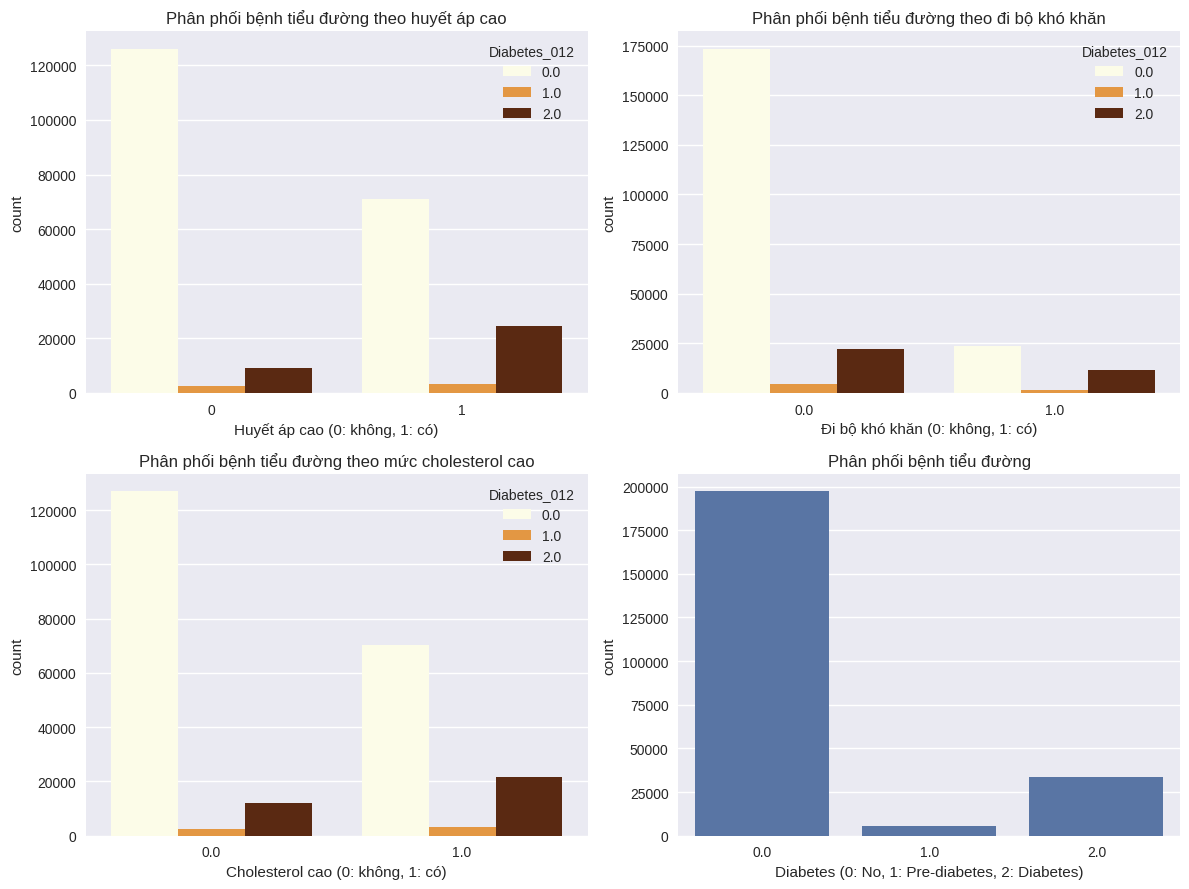

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

# Phân phối bệnh tiểu đường theo huyết áp cao
sns.countplot(data=diabetes_df, x='HighBP', hue='Diabetes_012', dodge=True, palette='YlOrBr', ax=ax[0, 0])
ax[0, 0].set_title('Phân phối bệnh tiểu đường theo huyết áp cao')
ax[0, 0].set_xlabel('Huyết áp cao (0: không, 1: có)')

# Phân phối bệnh tiểu đường theo đi bộ khó khăn
sns.countplot(data=diabetes_df, x='DiffWalk', hue='Diabetes_012', dodge=True, palette='YlOrBr', ax=ax[0, 1])
ax[0, 1].set_title('Phân phối bệnh tiểu đường theo đi bộ khó khăn')
ax[0, 1].set_xlabel('Đi bộ khó khăn (0: không, 1: có)')

# Phân phối bệnh tiểu đường theo mức cholesterol cao
sns.countplot(data=diabetes_df, x='HighChol', hue='Diabetes_012', dodge=True, palette='YlOrBr', ax=ax[1, 0])
ax[1, 0].set_title('Phân phối bệnh tiểu đường theo mức cholesterol cao')
ax[1, 0].set_xlabel('Cholesterol cao (0: không, 1: có)')

# Phân phối ca bệnh tiểu đường
sns.countplot(data=diabetes_df, x='Diabetes_012', ax=ax[1, 1])
ax[1, 1].set_title('Phân phối bệnh tiểu đường')
ax[1, 1].set_xlabel('Diabetes (0: No, 1: Pre-diabetes, 2: Diabetes)')

plt.tight_layout()
plt.show()

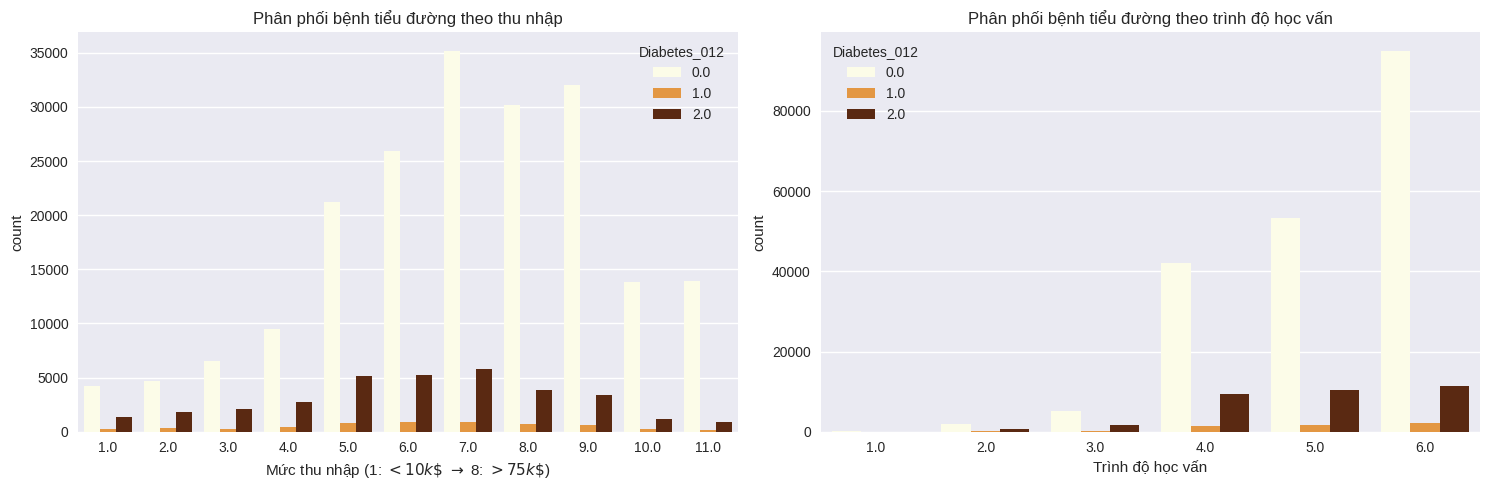

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Phân phối theo thu nhập
sns.countplot(data=diabetes_df, x='Income', hue='Diabetes_012',
              dodge=True, palette='YlOrBr', ax=ax[0])
ax[0].set_title('Phân phối bệnh tiểu đường theo thu nhập')
ax[0].set_xlabel(r'Mức thu nhập (1: $<10k\$\ \to$ 8: $>75k\$$)')

# Phân phối theo học vấn
sns.countplot(data=diabetes_df, x='Education', hue='Diabetes_012',
              dodge=True, palette='YlOrBr', ax=ax[1])
ax[1].set_title('Phân phối bệnh tiểu đường theo trình độ học vấn')
ax[1].set_xlabel('Trình độ học vấn')

plt.tight_layout()
plt.show()

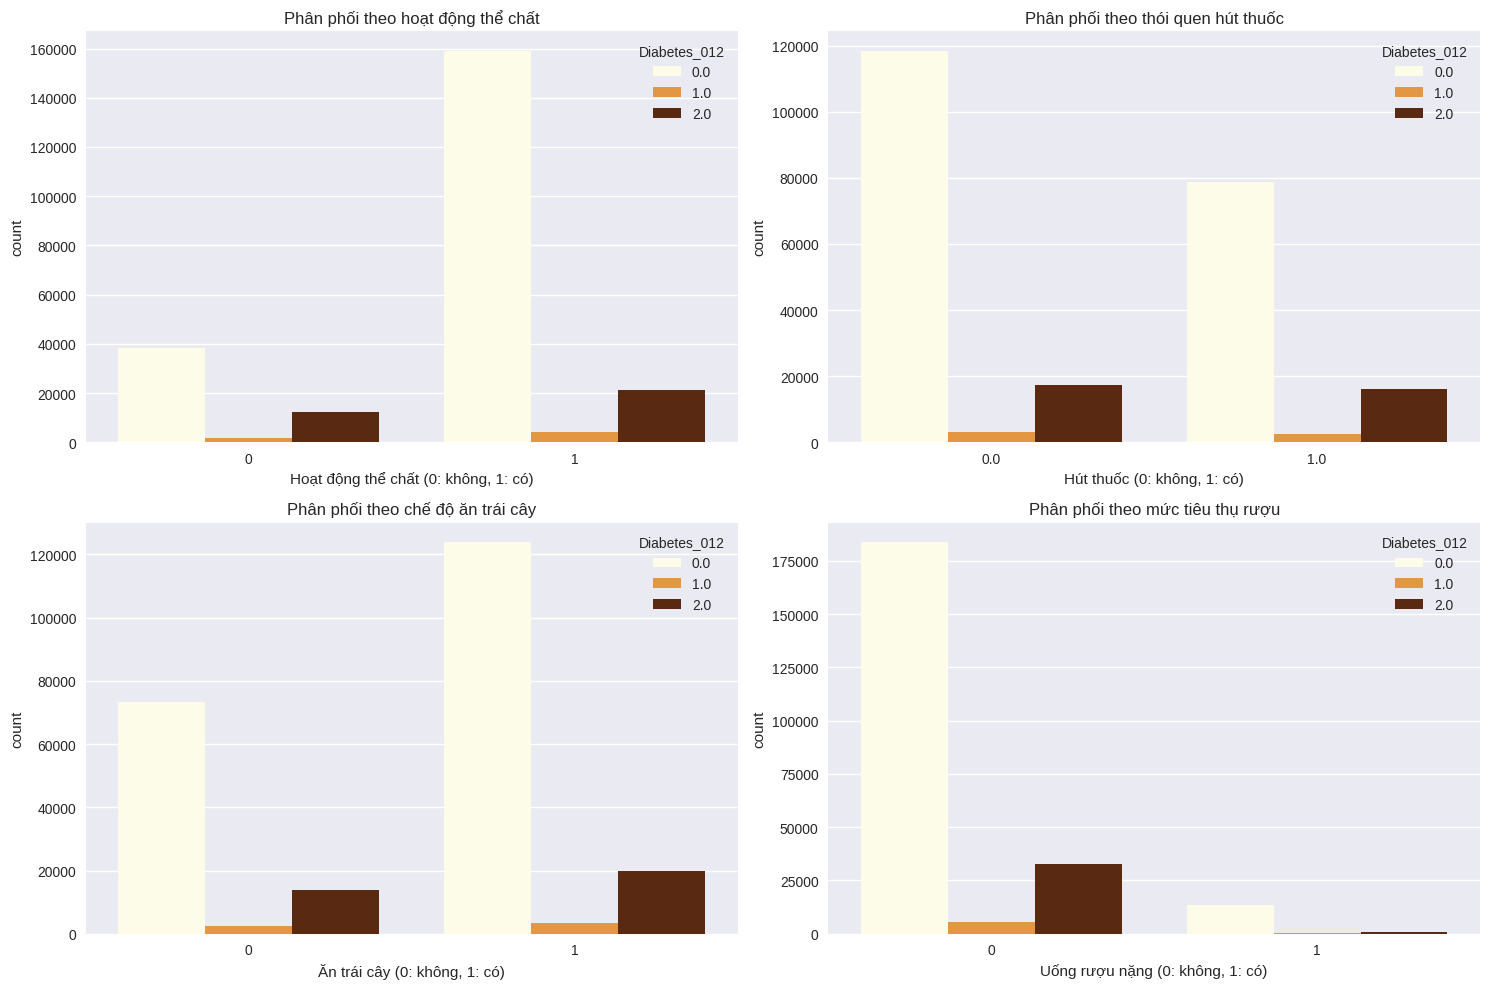

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Hoạt động thể chất
sns.countplot(data=diabetes_df, x='PhysActivity', hue='Diabetes_012',
              dodge=True, palette='YlOrBr', ax=ax[0,0])
ax[0,0].set_title('Phân phối theo hoạt động thể chất')
ax[0,0].set_xlabel('Hoạt động thể chất (0: không, 1: có)')

# Hút thuốc
sns.countplot(data=diabetes_df, x='Smoker', hue='Diabetes_012',
              dodge=True, palette='YlOrBr', ax=ax[0,1])
ax[0,1].set_title('Phân phối theo thói quen hút thuốc')
ax[0,1].set_xlabel('Hút thuốc (0: không, 1: có)')

# Chế độ ăn trái cây
sns.countplot(data=diabetes_df, x='Fruits', hue='Diabetes_012',
              dodge=True, palette='YlOrBr', ax=ax[1,0])
ax[1,0].set_title('Phân phối theo chế độ ăn trái cây')
ax[1,0].set_xlabel('Ăn trái cây (0: không, 1: có)')

# Tiêu thụ rượu
sns.countplot(data=diabetes_df, x='HvyAlcoholConsump', hue='Diabetes_012',
              dodge=True, palette='YlOrBr', ax=ax[1,1])
ax[1,1].set_title('Phân phối theo mức tiêu thụ rượu')
ax[1,1].set_xlabel('Uống rượu nặng (0: không, 1: có)')

plt.tight_layout()
plt.show()


## **4. Huấn luyện mô hình trên dữ liệu gốc**

Sau khi đã phân tích và có được cái nhìn trực quan hơn về bộ dữ liệu thì chúng ta nhìn thấy được những nhân tố quan trọng nào sẽ ảnh hưởng đến kết quả chuẩn đoán của mô hình nếu như đem bộ dữ liệu làm dữ liệu huấn luyện cho mô hình của chúng ta.

Tiếp theo, chúng ta sẽ chuẩn bị dữ liệu vào huấn luyện mô hình dựa trên bộ dữ liệu gốc ban đầu này. Ở đây chúng ta sẽ chọn ra 3 mô hình là **Random Forest**, **K-Nearest-Neighbors** (KNN) và **Multi-layer Perceptron Classifier** (MLP). Đây là những mô hình phổ biến giải quyết các bài toán về Classification.

**1. Random Forest**

  - **Dữ liệu có nhiều features**: Bộ dữ liệu có 22 cột với nhiều loại features khác nhau (`BMI`, `tuổi`, `huyết áp`, `cholesterol`...). Random Forest hoạt động tốt với dữ liệu có nhiều đặc trưng.
  - **Xử lý tốt dữ liệu không tuyến tính**: Qua phân tích tương quan cho thấy các features có mối quan hệ phức tạp với biến mục tiêu `(Diabetes_012)`.
  - **Chống overfitting**: Với **236,378** mẫu dữ liệu, Random Forest giúp giảm overfitting thông qua việc kết hợp nhiều cây quyết định.
  - **Xử lý được cả dữ liệu categorical và numerical**: Bộ dữ liệu có cả dữ liệu số `(BMI)` và phân loại `(HighBP, Sex...)`.

**2. KNN (K-Nearest Neighbors)**

  - **Dữ liệu đã được chuẩn hóa tốt**: Qua phân tích cho thấy dữ liệu không có missing values và các features đều có range giá trị hợp lý.
  - **Phù hợp với bài toán phân loại**: KNN hoạt động tốt với bài toán phân loại 3 classes (0: không tiểu đường, 1: tiền tiểu đường, 2: tiểu đường).
  - **Phát hiện được patterns cục bộ**: Có thể phát hiện các mẫu bệnh nhân có đặc điểm tương tự nhau.

**3. MLP (Multi-Layer Perceptron)**

  - **Phát hiện được mối quan hệ phức tạp**: Qua biểu đồ tương quan và phân tích EDA cho thấy có nhiều mối quan hệ phi tuyến tính giữa các features.
  - **Xử lý được dữ liệu lớn**: Với hơn 236,000 mẫu, MLP có thể học được các patterns phức tạp từ lượng dữ liệu lớn này.
  - **Phù hợp với bài toán multi-class**: MLP xử lý tốt bài toán phân loại nhiều lớp (3 classes trong trường hợp này).
  - **Có thể tự học các features phức tạp**: Các yếu tố nguy cơ tiểu đường thường có mối quan hệ phức tạp (ví dụ: sự kết hợp giữa `BMI`, `tuổi` và `huyết áp`).

### **4.1 Tách dữ liệu train và test**

Chúng ta sẽ chia bộ dữ liệu theo tỉ lệ là 8:2, tức là 8 phần trong bộ dữ liệu sẽ làm dữ liệu huấn luyện, và 2 phần còn lại sẽ là dữ liệu để kiểm tra mô hình có hoạt động tốt trên dữ liệu khác dữ liệu train hay không.

Để tách được dữ liệu một cách tốt nhất, chúng sẽ sử dụng đến thư viện **Scikit Learn**, đây là một thư viện chuyên dụng cho các bài toán về machine learning, chúng ta sẽ dùng hàm `train_test_split()` của thư viện Scikit Learn, hàm này giúp chúng ta chia dữ liệu đơn giản và tích hợp nhiều chức năng như xáo trộn dữ liệu, chia đều dữ liệu, ...

In [39]:
# Tách feature và label
org_X = diabetes_df.drop(columns=['Diabetes_012'])
org_y = diabetes_df['Diabetes_012']

In [40]:
print(f'Số dòng và cột của feature: {org_X.shape}')
print(f'Số dòng và cột của label: {org_y.shape}')

Số dòng và cột của feature: (236378, 21)
Số dòng và cột của label: (236378,)


In [41]:
# Các feature
org_X.head()

HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       0       1.0          1  15.0     1.0     0.0                   0.0   
1       1       0.0          1  28.0     0.0     0.0                   1.0   
2       1       1.0          1  33.0     0.0     0.0                   0.0   
3       0       1.0          1  29.0     0.0     1.0                   1.0   
4       0       0.0          1  24.0     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0             0       1        1  ...              1          0.0      5.0   
1             0       1        0  ...              1          0.0      2.0   
2             1       1        1  ...              1          0.0      2.0   
3             1       1        1  ...              1          0.0      5.0   
4             0       0        0  ...              1          0.0      3.0   

   MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  
0      10.0      20.0       0.0    0   11        4.0     5.0  
1       0.0       0.0       0.0    0   11        4.0     3.0  
2      10.0       0.0       0.0    0    9        4.0     7.0  
3       0.0      30.0       1.0    1   12        3.0     4.0  
4       0.0       0.0       1.0    1   13        5.0     6.0  

[5 rows x 21 columns]

In [42]:
# Label
org_y

0         0.0
1         2.0
2         2.0
3         2.0
4         0.0
         ... 
236373    2.0
236374    0.0
236375    0.0
236376    0.0
236377    0.0
Name: Diabetes_012, Length: 236378, dtype: float64

Chúng ta sẽ gọi hàm `train_test_split()` để tách dữ liệu nhé. Lưu ý là vì dữ liệu có sự chênh lệch giữa các label với nhau, nên chúng ta cần gọi thêm tham số `stratify` để cho hàm `train_test_split()` có thể chia đều các label, tránh trường hợp các label ở phần test được tách ra chỉ nằm ở các label đa số.

In [44]:
org_X_train, org_X_test, org_y_train, org_y_test = train_test_split(
    org_X,
    org_y,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=org_y
)

In [45]:
print(f'Số dòng và cột của train feature: {org_X_train.shape}')
print(f'Số dòng và cột của train label: {org_y_train.shape}')
print(f'Số dòng và cột của test feature: {org_X_test.shape}')
print(f'Số dòng và cột của test label: {org_y_test.shape}')

Số dòng và cột của train feature: (189102, 21)
Số dòng và cột của train label: (189102,)
Số dòng và cột của test feature: (47276, 21)
Số dòng và cột của test label: (47276,)


In [46]:
# Kiểm tra label của test có bị thiếu các label thiểu sổ không
print(f'Số lượng lable 1.0 trong tập test {np.isin(org_y_test, 1.0).sum()}')
print(f'Số lượng lable 2.0 trong tập test {np.isin(org_y_test, 2.0).sum()}')

Số lượng lable 1.0 trong tập test 1124
Số lượng lable 2.0 trong tập test 6714


### **4.2 Chuẩn hóa dữ liệu**

Đây là một bước cần thiết trước khi huấn luyện mô hình, vì trong bộ dữ liệu sẽ có sự chênh lệch đơn vị giữa các cột dữ liệu, ví dụ như 1 cột là hàng đơn vị, nhưng có 1 vài cột là hàng chục hoặc hàng trăm thì điều này cũng ảnh hưởng ít nhiều đến quá tình huấn luyện của mô hình. Bước chuẩn hóa dữ liệu này nhằm mục đích là đưa toàn bộ các cột dữ liệu về cùng một đơn vị và trong khoảng mong muốn (thường là $[0, 1]$).

Có nhiều phương pháp chuẩn hóa như **Min-Max Scaling**, **Z-Score Normalization**, **Log Scaling**,... Nhưng trong bài này chúng ta sẽ sử dụng thuật toán **Min-Max Scaling**, vì đây là một dạng chuẩn hóa phổ biến nhất trong các mô hình machine learning. Công thức Min-Max Scaling thường có công thức là:
$$X_{normalized} = \frac{X – X_{min}}{X_{max} – X_{min}}$$

Trong đó:
  - $X$ là giá trị đặc trưng ngẫu nhiên cần được chuẩn hóa.
  - $X_{min}$ là giá trị đặc trưng nhỏ nhất trong tập dữ liệu
  - $X_{max}$ là giá trị đặc trưng lớn nhất.

Khi X là giá trị nhỏ nhất, tử số bằng 0 $(X_{min} - X_{min})$ và do đó, giá trị chuẩn hóa là 0.

Khi X là giá trị lớn nhất, tử số bằng mẫu số $(X_{max} - X_{min})$ và do đó, giá trị chuẩn hóa là 1.

Khi X không phải là giá trị nhỏ nhất hoặc lớn nhất, giá trị chuẩn hóa nằm trong khoảng từ 0 đến 1. Điều này được gọi là kỹ thuật chia tỷ lệ min-max.

Thư viện Scikit Learn cũng cung cấp sẵn cho chúng ta class **MinMaxScaler** dùng để chuẩn hóa dữ liệu một cách dễ dàng.

In [48]:
# Chuẩn hóa các feature huấn luyện
min_max_scaler = MinMaxScaler()
# Chuẩn hóa
normalized_org_X_train = min_max_scaler.fit_transform(org_X_train)
normalized_org_X_test = min_max_scaler.transform(org_X_test)

In [49]:
# Trước khi chuẩn hóa
org_X_train.iloc[0]

HighBP                   0.0
HighChol                 0.0
CholCheck                1.0
BMI                     28.0
Smoker                   0.0
Stroke                   0.0
HeartDiseaseorAttack     0.0
PhysActivity             1.0
Fruits                   1.0
Veggies                  1.0
HvyAlcoholConsump        0.0
AnyHealthcare            1.0
NoDocbcCost              0.0
GenHlth                  2.0
MentHlth                 0.0
PhysHlth                 0.0
DiffWalk                 0.0
Sex                      0.0
Age                     11.0
Education                6.0
Income                   8.0
Name: 32045, dtype: float64

In [50]:
# Sau khi chuẩn hóa
normalized_org_X_train[0]

array([0.        , 0.        , 1.        , 0.18390805, 0.        ,
       0.        , 0.        , 1.        , 1.        , 1.        ,
       0.        , 1.        , 0.        , 0.25      , 0.        ,
       0.        , 0.        , 0.        , 0.83333333, 1.        ,
       0.7       ])

### **4.3 Huấn luyện mô hình**

Sau khi chuẩn bị dữ liệu, chúng ta sẽ khởi tạo và huấn luyện 3 mô hình và so sánh kết quả bằng thư viện Scikit Learn.

In [52]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Đánh giá mô hình bằng các metrics khác nhau

    Parameters:
        y_true: nhãn thực tế
        y_pred: nhãn dự đoán
        model_name: tên mô hình (mặc định là "Model")
    """
    # Tính toán các metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # In kết quả
    print(f"Kết quả đánh giá cho {model_name}:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print("\nBảng phân loại chi tiết:")
    print("-" * 50)
    print(classification_report(y_true, y_pred))

In [53]:
def plot_roc_auc(y_true, y_pred_proba, model_name="Model"):
    """
    Vẽ đường cong ROC và tính AUC cho mô hình đa lớp

    Parameters:
        y_true: nhãn thực tế
        y_pred_proba: xác suất dự đoán cho mỗi lớp
        model_name: tên mô hình (mặc định là "Model")
    """
    # Chuyển đổi nhãn thành one-hot encoding
    y_true_bin = pd.get_dummies(y_true)

    # Tạo figure
    plt.figure(figsize=(10, 8))

    # Màu sắc cho các đường
    colors = ['blue', 'red', 'yellow']
    labels = ['Không tiểu đường', 'Tiền tiểu đường', 'Tiểu đường']

    # Vẽ ROC cho từng lớp
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true_bin.iloc[:, i], y_pred_proba[:, i])
        auc = roc_auc_score(y_true_bin.iloc[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, color=colors[i],
                label=f'{labels[i]} (AUC = {auc:.3f})')

    # Thêm đường chéo
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Chỉnh sửa đồ thị
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Hiển thị đồ thị
    plt.show()

In [54]:
def compare_models(models_dict, X_test, y_true):
    """
    So sánh hiệu suất của nhiều mô hình

    Parameters:
        models_dict: từ điển chứa các mô hình cần so sánh {'tên mô hình': model}
        X_test: dữ liệu test
        y_true: nhãn thực tế
    """
    # Khởi tạo dictionary để lưu các metrics
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'ROC AUC': [],
        'Precision-class0': [],
        'Precision-class1': [],
        'Precision-class2': [],
        'Recall-class0': [],
        'Recall-class1': [],
        'Recall-class2': [],
        'F1-class0': [],
        'F1-class1': [],
        'F1-class2': []
    }

    # Tính toán metrics cho từng mô hình
    for name, model in models_dict.items():
        # Dự đoán
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Tính các metrics trung bình
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        # Tính các metrics cho từng class
        precision_per_class = precision_score(y_true, y_pred, average=None)
        recall_per_class = recall_score(y_true, y_pred, average=None)
        f1_per_class = f1_score(y_true, y_pred, average=None)

        # Tính ROC AUC trung bình cho tất cả các lớp
        y_true_bin = pd.get_dummies(y_true)
        roc_auc = np.mean([roc_auc_score(y_true_bin.iloc[:, i], y_pred_proba[:, i])
                          for i in range(3)])

        # Thêm kết quả vào dictionary
        results['Model'].append(name)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)
        results['ROC AUC'].append(roc_auc)

        # Thêm metrics cho từng class
        for i in range(3):
            results[f'Precision-class{i}'].append(precision_per_class[i])
            results[f'Recall-class{i}'].append(recall_per_class[i])
            results[f'F1-class{i}'].append(f1_per_class[i])

    # Chuyển kết quả thành DataFrame
    results_df = pd.DataFrame(results)

    # Định dạng các số thành 4 chữ số thập phân
    float_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC',
                 'Precision-class0', 'Precision-class1', 'Precision-class2',
                 'Recall-class0', 'Recall-class1', 'Recall-class2',
                 'F1-class0', 'F1-class1', 'F1-class2']
    results_df[float_cols] = results_df[float_cols].round(4)

    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(15, 6))

    # Vị trí của các cột
    x = np.arange(len(models_dict))
    width = 0.15

    # Vẽ các cột metrics
    plt.bar(x - width*2, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
    plt.bar(x - width, results_df['Precision'], width, label='Precision', color='lightgreen')
    plt.bar(x, results_df['Recall'], width, label='Recall', color='salmon')
    plt.bar(x + width, results_df['F1-Score'], width, label='F1-Score', color='purple')
    plt.bar(x + width*2, results_df['ROC AUC'], width, label='ROC AUC', color='orange')

    # Chỉnh sửa đồ thị
    plt.xlabel('Mô hình')
    plt.ylabel('Điểm số')
    plt.title('So sánh hiệu suất các mô hình')
    plt.xticks(x, results_df['Model'])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Thêm giá trị lên đầu mỗi cột
    for i in range(len(models_dict)):
        plt.text(i - width*2, results_df['Accuracy'][i], f"{results_df['Accuracy'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i - width, results_df['Precision'][i], f"{results_df['Precision'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i, results_df['Recall'][i], f"{results_df['Recall'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i + width, results_df['F1-Score'][i], f"{results_df['F1-Score'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i + width*2, results_df['ROC AUC'][i], f"{results_df['ROC AUC'][i]:.3f}",
                ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

    return results_df

#### **4.3.1 Random Forest**

- **Accuracy**: Đạt 83.52%, là mức độ chính xác khá tốt.
- **Precision** & **Recall**: Macro-average lần lượt là 51% và 34%, cho thấy mô hình có độ chính xác và độ bao phủ ở mức trung bình.
- Phân tích chi tiết theo class:
  - Class 0 (Không tiểu đường): Hiệu suất tốt nhất với F1-score 91%
  - Class 1 (Tiền tiểu đường): Không thể phân loại được (F1-score = 0)
  - Class 2 (Tiểu đường): Hiệu suất trung bình với F1-score 2%

In [56]:
# Định nghĩa mô hình Random Forest
org_random_forest_model = RandomForestClassifier(
    n_estimators=100,       # Số cây trong rừng
    max_depth=5,            # Độ sâu tối đa của mỗi cây
    n_jobs=num_of_core
)

In [57]:
# Huấn luyện mô hình
org_random_forest_model.fit(normalized_org_X_train, org_y_train)

RandomForestClassifier(max_depth=5, n_jobs=8)

In [58]:
# Dự đoán
org_rf_y_pred = org_random_forest_model.predict(normalized_org_X_test)
org_rf_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [59]:
# Đánh giá mô hình
evaluate_model(y_true=org_y_test, y_pred=org_rf_y_pred, model_name='Random Forest')

Kết quả đánh giá cho Random Forest:
--------------------------------------------------
Accuracy: 0.8353
Precision (macro): 0.5001
Recall (macro): 0.3379
F1-score (macro): 0.3132

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91     39438
         1.0       0.00      0.00      0.00      1124
         2.0       0.66      0.02      0.03      6714

    accuracy                           0.84     47276
   macro avg       0.50      0.34      0.31     47276
weighted avg       0.79      0.84      0.76     47276



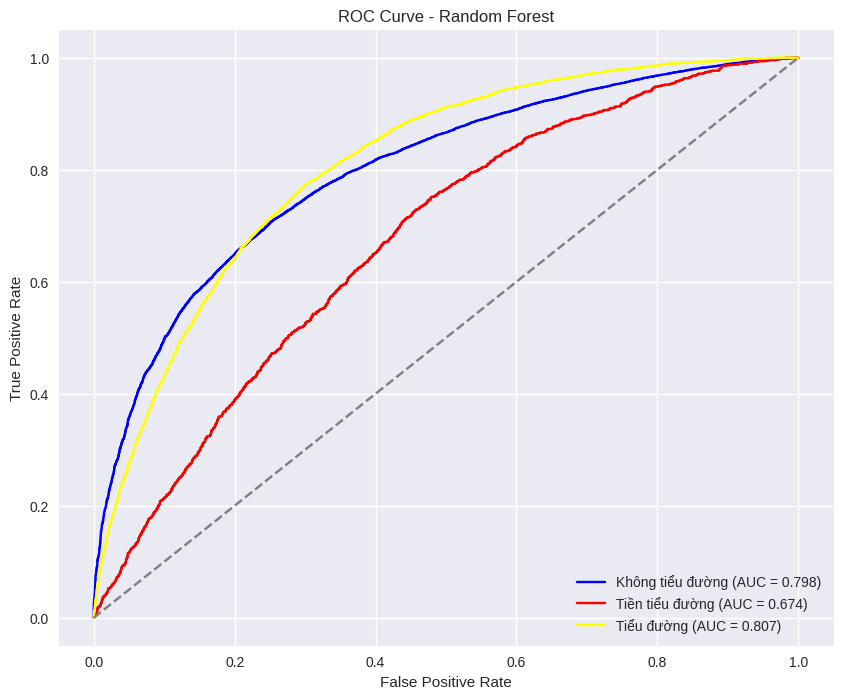

In [60]:
# Vẽ biểu đồ ROC và AUC
org_rf_proba = org_random_forest_model.predict_proba(normalized_org_X_test)
plot_roc_auc(org_y_test, org_rf_proba, model_name='Random Forest')

#### **4.3.2 K-Nearest Neighbors**

- **Accuracy**: Đạt 82.15%, thấp hơn Random Forest.
- **Precision** & **Recall**: Macro-average lần lượt là 43% và 39%, thấp hơn Random Forest.
- Phân tích chi tiết theo class:
  - Class 0: F1-score 90%, vẫn duy trì hiệu suất tốt
  - Class 1: Không thể phân loại được (F1-score = 0)
  - Class 2: Hiệu suất kém với F1-score chỉ 27%

In [62]:
# Định nghĩa mô hình KNN
org_knn_model = KNeighborsClassifier(
    n_neighbors=5,          # Số điểm lân cận
    n_jobs=num_of_core
)

In [63]:
# Huấn luyện mô hình
org_knn_model.fit(normalized_org_X_train, org_y_train)

KNeighborsClassifier(n_jobs=8)

In [64]:
# Dự đoán
org_knn_y_pred = org_knn_model.predict(normalized_org_X_test)
org_knn_y_pred

array([0., 2., 0., ..., 0., 0., 0.])

In [65]:
# Đánh giá mô hình
evaluate_model(y_true=org_y_test, y_pred=org_knn_y_pred, model_name='K-Nearest Neighbors')

Kết quả đánh giá cho K-Nearest Neighbors:
--------------------------------------------------
Accuracy: 0.8215
Precision (macro): 0.4329
Recall (macro): 0.3859
F1-score (macro): 0.3922

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     39438
         1.0       0.04      0.00      0.01      1124
         2.0       0.40      0.21      0.27      6714

    accuracy                           0.82     47276
   macro avg       0.43      0.39      0.39     47276
weighted avg       0.77      0.82      0.79     47276



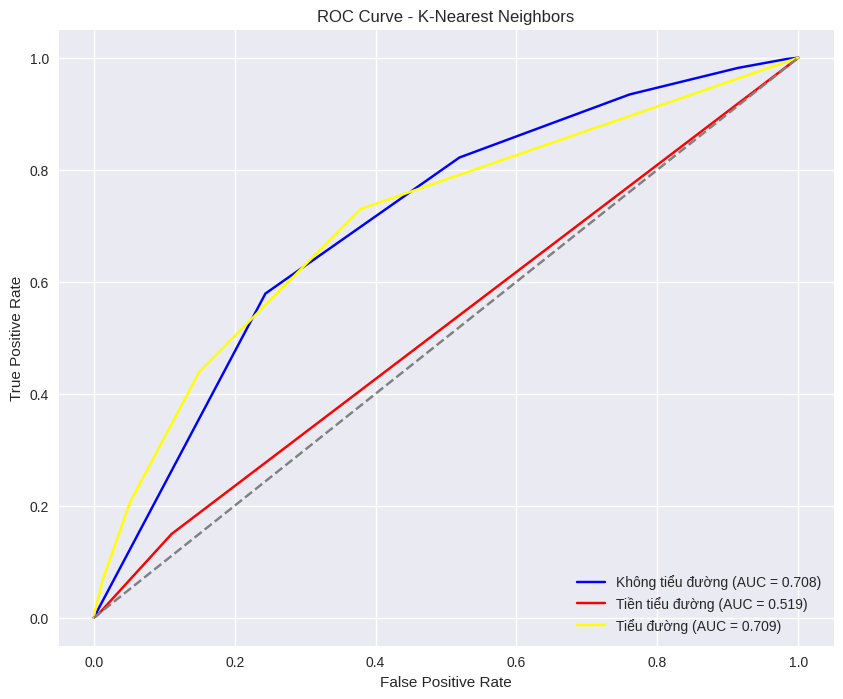

In [66]:
# Vẽ biểu đồ ROC và AUC
org_knn_proba = org_knn_model.predict_proba(normalized_org_X_test)
plot_roc_auc(org_y_test, org_knn_proba, model_name='K-Nearest Neighbors')

#### **4.3.3 Multi-layer Perceptron**

- **Accuracy**: Đạt 83.60%, cao nhất trong 3 mô hình.
- **Precision** & **Recall**: Macro-average vẫn thấp, lần lượt là 47.83% và 38.20%.
- Phân tích chi tiết theo class:
  - Class 0: F1-score 91%, tương đương Random Forest
  - Class 1: Khó phân loại được (F1-score = 1%)
  - Class 2: Hiệu suất rất kém với F1-score chỉ 25%

In [68]:
# Định nghĩa mô hình MLP
org_mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 128, 64),    # 3 hidden layers với 64, 128 và 64 neurons
    activation='relu',                   # hàm kích hoạt
    solver='adam',                       # thuật toán tối ưu
    max_iter=50,                         # số vòng lặp tối đa
)

In [69]:
# Huấn luyện mô hình
org_mlp_model.fit(normalized_org_X_train, org_y_train)

MLPClassifier(hidden_layer_sizes=(64, 128, 64), max_iter=50)

In [70]:
# Dự đoán
org_mlp_y_pred = org_mlp_model.predict(normalized_org_X_test)
org_mlp_y_pred

array([0., 2., 2., ..., 0., 0., 0.])

In [71]:
# Đánh giá mô hình
evaluate_model(y_true=org_y_test, y_pred=org_mlp_y_pred, model_name='Multi-layer Perceptron')

Kết quả đánh giá cho Multi-layer Perceptron:
--------------------------------------------------
Accuracy: 0.8367
Precision (macro): 0.4735
Recall (macro): 0.3872
F1-score (macro): 0.3961

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     39438
         1.0       0.06      0.00      0.00      1124
         2.0       0.50      0.19      0.28      6714

    accuracy                           0.84     47276
   macro avg       0.47      0.39      0.40     47276
weighted avg       0.79      0.84      0.80     47276



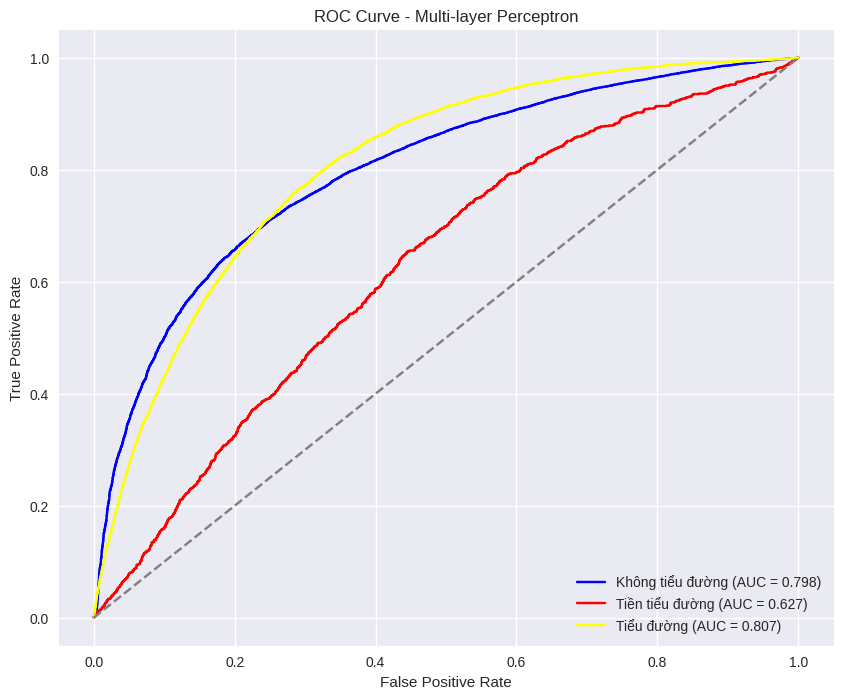

In [72]:
# Vẽ biểu đồ ROC và AUC
org_mlp_proba = org_mlp_model.predict_proba(normalized_org_X_test)
plot_roc_auc(org_y_test, org_mlp_proba, model_name='Multi-layer Perceptron')

#### **4.3.4 So sánh**

In [74]:
# Tạo dictionary chứa các mô hình
org_models = {
    'Random Forest': org_random_forest_model,
    'KNN': org_knn_model,
    'MLP': org_mlp_model
}

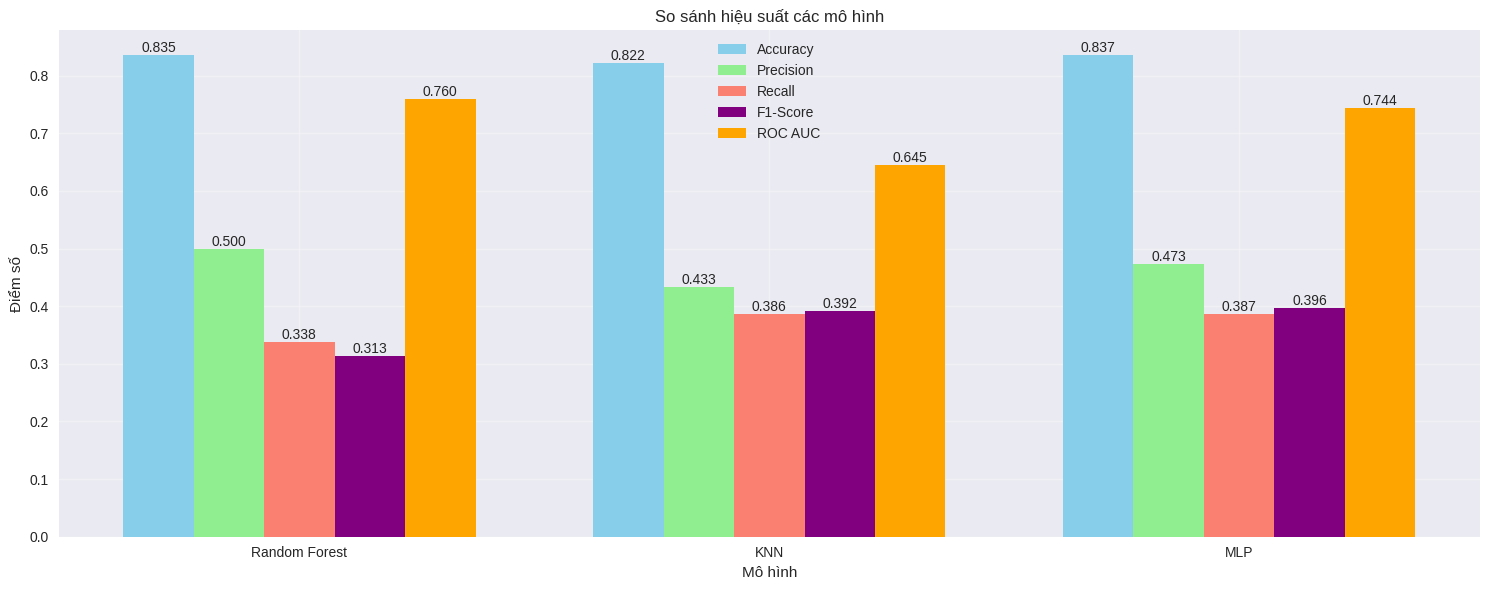

In [75]:
# So sánh các mô hình
org_comparison_results = compare_models(org_models, normalized_org_X_test, org_y_test)

In [76]:
org_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8353     0.5001  0.3379    0.3132   0.7598   
1            KNN    0.8215     0.4329  0.3859    0.3922   0.6453   
2            MLP    0.8367     0.4735  0.3872    0.3961   0.7443   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8359            0.0000            0.6645         0.9988   
1            0.8561            0.0435            0.3992         0.9497   
2            0.8561            0.0606            0.5040         0.9708   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.0000         0.0150     0.9101     0.0000     0.0294  
1         0.0027         0.2054     0.9005     0.0050     0.2712  
2         0.0018         0.1892     0.9098     0.0035     0.2751

#### **4.3.5 Đánh giá**

Nhìn chung, chúng ta có thể thấy được phần lớn cả 3 mô hình đều cho **độ chính xác (accuracy) khá ổn**. Tuy nhiên, có 1 vấn đề rất lớn là cả 3 mô hình chỉ hoạt động tốt trên label đa số là nhãn 0 (Không tiểu đường), vì label này chiếm phần lớn trong bộ dữ liệu, và các label nhãn 2 (Tiểu đường) và 1 (Tiền tiểu đường) thì có vẻ không cao, có những mô hình f1-score gần như bằng 0, điều này cho thấy là mô hình đang bị overfitting với nhãn 0, vì nhãn này chiếm đa số trong bộ dữ liệu gốc.

Điều này cho thấy được là có vẻ như dữ liệu đang bị **mất cân bằng nghiêm trọng** và bên cạnh đó là mô hình đang bị một vấn đề là độ chính xác (accuracy) đều cao hầu hết là nhờ vào label 0. Điều này, thực tế là không tốt, vì nếu nhìn vào f1-score của những label khác thì hầu như khá thấp hoặc gần như là 0, và điều này càng chứng tỏ là mô hình đang bị quá fit với dữ liệu nhãn 0.

Trong kết quả đánh giá, thì **Random Forest** là mô hình cho kết quả metrics cân bằng nhất, vì đây là một mô hình hoạt động rất tốt trong các bộ dữ liệu mất cân bằng, **MLP** thì cho độ chính xác cao, nhưng phân loại label 2 thì lại có f1-score quá thấp, vì hầu hết mô hình đã bị tập trung học quá nhiều vào label 1, trong khi **KNN** thì ổn hơn, tuy nhiên là label 2 vẫn thấp vì do số lượng *hàng xóm* của label này quá ít, điều này làm ảnh hưởng khá nhiều đến kết quả dự đoán.

Nhìn chung thì vấn đề làm ảnh hưởng đến kết quả dự đoán nhiều như vậy hầu hết là do **mất cân bằng dữ liệu**, để khắc phục được điều này, chúng ta sẽ cần phải thực hiện qua bước **cân bằng dữ liệu (data balancing)**. Ngoài ra, muốn giúp cho mô hình học tốt hơn, chúng ta cũng cần phải có thêm 1 bước cải thiện dữ liệu bằng các thực hiện **feature engineering** hoặc **điều chỉnh tham số mô hình (hyperparameters)**.

## **5. Feature engineering**

**Feature engineering** là bước nên có trong quá trình huấn luyện mô hình, đây sẽ là bước mà chúng ta sẽ tiền xử lý dữ liệu và chuẩn bị dữ liệu cho mô hình. Một số phương pháp thông dụng mà chúng ta sẽ thường thấy trong feature engineering:

- Xử lý giá trị null.
- Xử lý outlier.
- Xử lý giá trị trùng lặp.
- Chuyển đổi giá trị category sang number.
- Thêm feature dựa trên những feature có sẵn.
- Cân bằng dữ liệu
- ...

Đây chỉ là một số bước quan trọng mà chúng ta nên thêm vào nếu như muốn mô hình được hoạt động tốt hơn.

In [79]:
# Copy dữ liệu gốc
fea_egr_diabetes_df = diabetes_df.copy()

### **5.1 Xử lý giá trị null**

In [81]:
# Kiểm tra các cột dữ liệu có null hay không
for col in fea_egr_diabetes_df.columns.tolist():
    print('{} column missing values: {}'.format(col, fea_egr_diabetes_df[col].isnull().sum()))

Diabetes_012 column missing values: 0
HighBP column missing values: 0
HighChol column missing values: 0
CholCheck column missing values: 0
BMI column missing values: 0
Smoker column missing values: 0
Stroke column missing values: 0
HeartDiseaseorAttack column missing values: 0
PhysActivity column missing values: 0
Fruits column missing values: 0
Veggies column missing values: 0
HvyAlcoholConsump column missing values: 0
AnyHealthcare column missing values: 0
NoDocbcCost column missing values: 0
GenHlth column missing values: 0
MentHlth column missing values: 0
PhysHlth column missing values: 0
DiffWalk column missing values: 0
Sex column missing values: 0
Age column missing values: 0
Education column missing values: 0
Income column missing values: 0


### **5.2 Xử lý các dòng trùng lặp**

In [83]:
# Kiểm tra số dòng trùng lặp
fea_egr_diabetes_df.duplicated().sum()

12828

Có 12828 dòng bị trùng lặp trong dữ liệu ban đầu, điều này ảnh hưởng không tốt cho các mô hình dễ bị nhiễu như KNN hoặc MLP, nên chúng ta cần phải xóa những dòng dữ liệu này.

In [85]:
for label in [0.0, 1.0, 2.0]:
    duplicate_counts = fea_egr_diabetes_df[fea_egr_diabetes_df['Diabetes_012'] == label].duplicated().sum()
    print(f'Số dòng trùng lặp của label {label}: {duplicate_counts}')

Số dòng trùng lặp của label 0.0: 12649
Số dòng trùng lặp của label 1.0: 6
Số dòng trùng lặp của label 2.0: 173


In [86]:
# Xóa các dòng trùng lặp
fea_egr_diabetes_df.drop_duplicates(inplace=True)

In [87]:
# Kiểm tra lại số dòng trùng lặp
fea_egr_diabetes_df.duplicated().sum()

0

### **5.3 Xử lý các giá trị outlier**

Outlier (hay giá trị ngoại lai) là những điểm dữ liệu khác thường, nằm cách xa phần lớn các điểm dữ liệu khác trong tập dữ liệu. Nói cách khác, đây là những giá trị "bất thường" hoặc "khác biệt đáng kể" so với xu hướng chung của dữ liệu. Đặc điểm của outlier là nằm xa các giá trị trung tâm của dữ liệu, có thể ảnh hưởng đáng kể đến các phân tích thống kê, có thể là do lỗi đo lường hoặc là các trường hợp đặc biệt thực tế.

**Cách xác định outlier**:
- Phương pháp IQR (Khoảng tứ phân vị)
- Phương pháp Z-score

Tuy nhiên, trong phần này chúng ta sẽ chỉ tập trung vào phần **phương pháp IQR**. Trong phần phát hiện giá trị outlier, chúng ta sẽ tập trung vào 3 cột chính là `BMI`, `MentHlth` và `PhysHlth`, vì 3 biến này thuộc dạng biến số học, chúng sẽ dễ tồn tại các giá trị outlier.

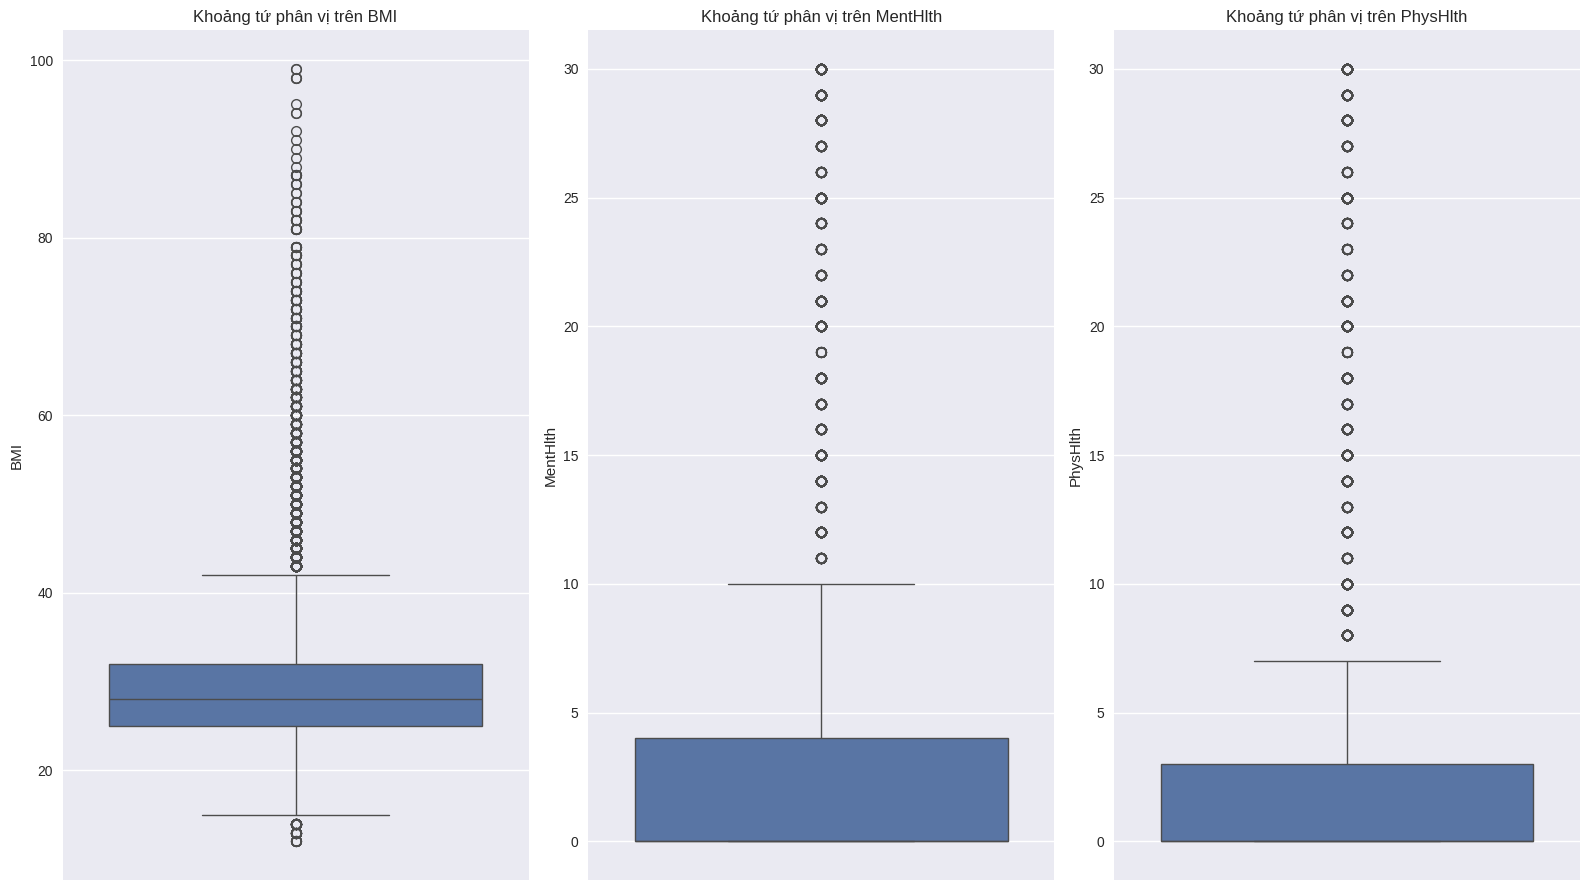

In [89]:
# Vẽ boxplot xác định outlier
fig, ax = plt.subplots(1, 3, figsize=(16, 9))

sns.boxplot(data=fea_egr_diabetes_df, y='BMI', ax=ax[0])
ax[0].set_title('Khoảng tứ phân vị trên BMI')

sns.boxplot(data=fea_egr_diabetes_df, y='MentHlth', ax=ax[1])
ax[1].set_title('Khoảng tứ phân vị trên MentHlth')

sns.boxplot(data=fea_egr_diabetes_df, y='PhysHlth', ax=ax[2])
ax[2].set_title('Khoảng tứ phân vị trên PhysHlth')

plt.tight_layout()
plt.show()

Có thể thấy được trong 3 cột có tồn tại rất nhiều outlier, ví dụ trên `BMI` tồn tại những giá trị vượt ngoài giá trị 40, thông thường nếu giá trị `BMI` nằm trên mức **35** thì chúng ta đã có thể đánh giá được chỉ số `BMI` người này là **không tốt (Béo phì mức độ III)**. Tuy nhiên, chúng ta cần phải kiểm tra là những outlier này ở trên mỗi label tồn tại bao nhiêu, vì đôi khi outliner này lại là điểm đặc biệt giúp cho một label nào đó được xác định.

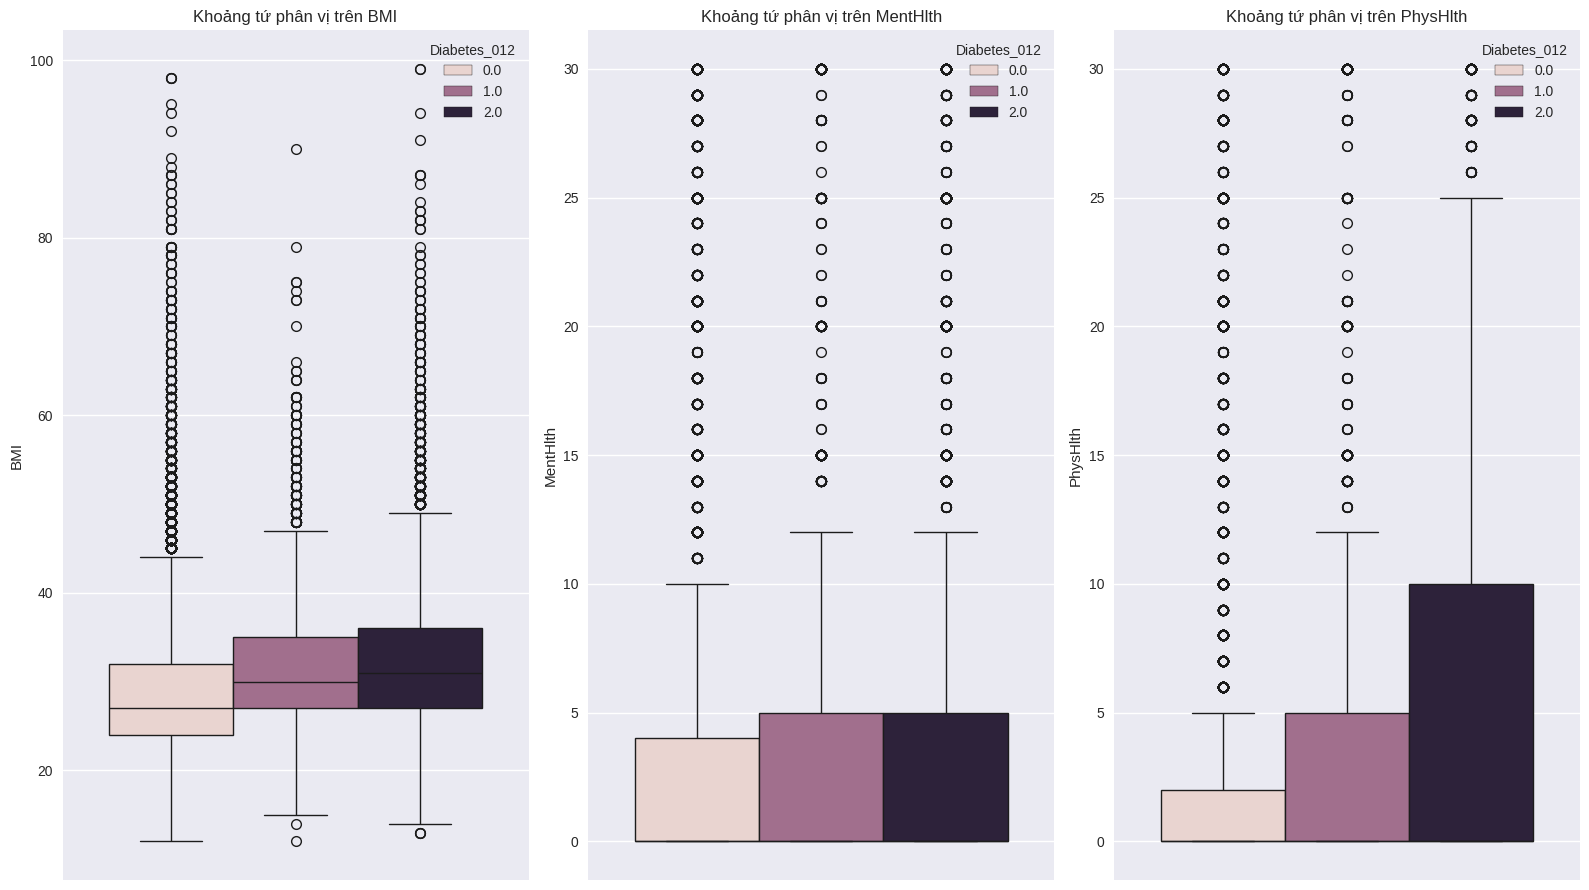

In [91]:
# Outlier trên mỗi class
fig, ax = plt.subplots(1, 3, figsize=(16, 9))

sns.boxplot(data=fea_egr_diabetes_df, y='BMI', hue='Diabetes_012', ax=ax[0])
ax[0].set_title('Khoảng tứ phân vị trên BMI')

sns.boxplot(data=fea_egr_diabetes_df, y='MentHlth', hue='Diabetes_012', ax=ax[1])
ax[1].set_title('Khoảng tứ phân vị trên MentHlth')

sns.boxplot(data=fea_egr_diabetes_df, y='PhysHlth', hue='Diabetes_012', ax=ax[2])
ax[2].set_title('Khoảng tứ phân vị trên PhysHlth')

plt.tight_layout()
plt.show()

Có thể thấy được, tồn tại rất nhiều outlier trong cả 3 label. Tuy nhiên, về tính đặc thù của lĩnh vực y tế thì các outlier này đang chỉ ra một người nào đó đang có chỉ số sức khỏe không tốt, có khả năng hoặc nguy cơ cao sẽ mắc tiểu đường chứ thực tế là chưa bị. Ví dụ cụ thể là chỉ số `BMI` cao bất thường có thể là dấu hiệu thực tế của bệnh tiểu đường, Số ngày sức khỏe kém (`MentHlth`, `PhysHlth`) cao có thể là đặc điểm thực của bệnh nhân và các giá trị này tuy là outlier về mặt thống kê nhưng lại có ý nghĩa y tế quan trọng.

=> Do đó, giải pháp xóa các outlier này là không khả thi

Thay vào đó, chúng ta sẽ sử dụng một giải pháp khác thay vì phải xóa, đó là **Capping** hoặc **Winsorization**, đây là một phương pháp xử lý các giá trị outlier phổ biến. Cụ thể, chúng ta sẽ thay thế các giá trị outlier này bằng các giá trị giới hạn.
$$Giới\ hạn\ trên = Q3 + 1.5 * IQR\ (Phân\ vị\ thứ\ 75\ +\ 1.5\ lần\ khoảng\ tứ\ phân\ vị)$$
$$Giới\ hạn\ dưới = Q1 - 1.5 * IQR\ (Phân\ vị\ thứ\ 25\ -\ 1.5\ lần\ khoảng\ tứ\ phân\ vị)$$

Phương pháp khoảng phân vị (IQR) sử dụng 1,5 làm thang đo để phát hiện các ngoại lệ vì nó tuân theo phân bố Gaussian gần nhất. Kết quả là, phương pháp này chỉ ra rằng bất kỳ điểm dữ liệu nào thấp hơn 1,5 điểm so với tứ phân vị giới hạn dưới hoặc cao hơn tứ phân vị giới hạn trên đều là điểm ngoại lệ ([đọc ở đây](https://en.wikipedia.org/wiki/Interquartile_range)).

In [93]:
def handle_outliers(df, columns):
    """
    Xử lý outlier cho các cột được chỉ định theo từng nhóm Diabetes

    Parameters:
        df: DataFrame gốc
        columns: List các cột cần xử lý

    Returns:
        DataFrame đã được xử lý outlier
    """
    df_clean = df.copy()

    for col in columns:
        # Tính Q1, Q3 và IQR cho từng nhóm Diabetes
        for diabetes_type in df['Diabetes_012'].unique():
            mask = df['Diabetes_012'] == diabetes_type

            Q1 = df[mask][col].quantile(0.25)
            Q3 = df[mask][col].quantile(0.75)
            IQR = Q3 - Q1

            # Xác định outlier bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Xử lý outlier bằng cách gán giá trị biên
            df_clean.loc[mask & (df[col] < lower_bound), col] = lower_bound
            df_clean.loc[mask & (df[col] > upper_bound), col] = upper_bound

    return df_clean


In [94]:
# Áp dụng xử lý outlier
columns_to_clean = ['BMI', 'MentHlth', 'PhysHlth']
clean_diabetes_df = handle_outliers(fea_egr_diabetes_df, columns_to_clean)

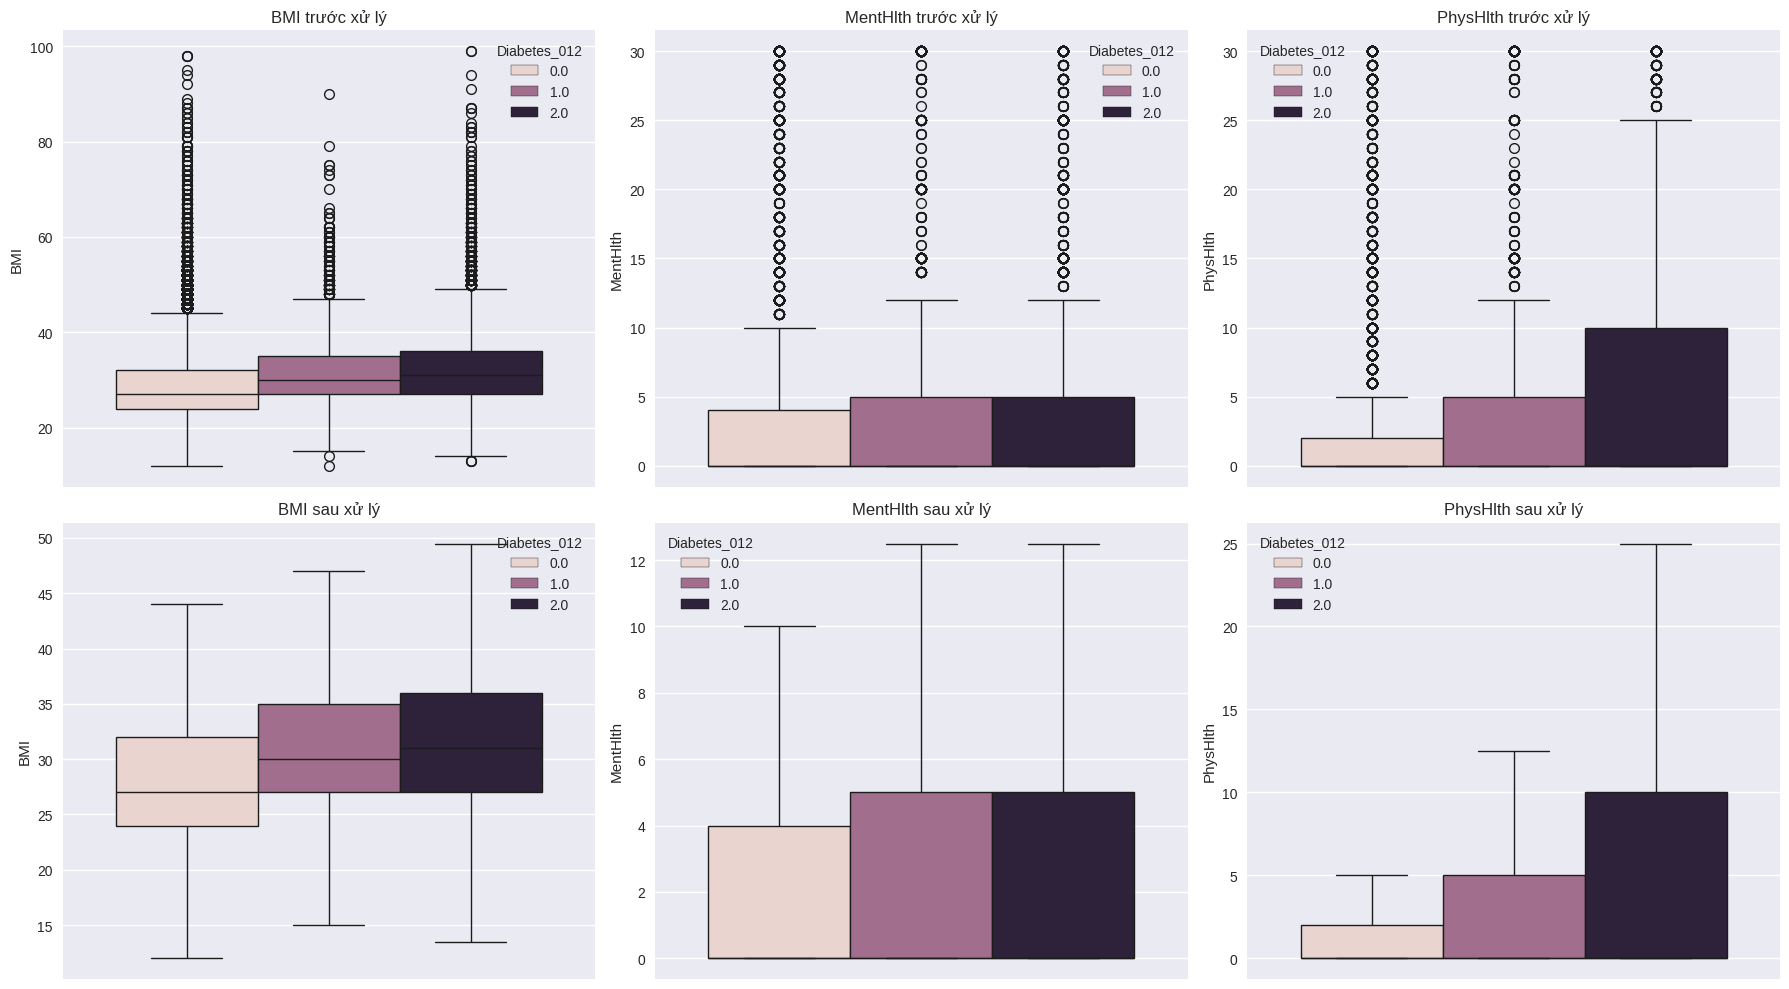

In [95]:
# Vẽ biểu đồ so sánh trước và sau xử lý
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Trước xử lý
sns.boxplot(data=fea_egr_diabetes_df, y='BMI', hue='Diabetes_012', ax=axes[0,0])
axes[0,0].set_title('BMI trước xử lý')
sns.boxplot(data=fea_egr_diabetes_df, y='MentHlth', hue='Diabetes_012', ax=axes[0,1])
axes[0,1].set_title('MentHlth trước xử lý')
sns.boxplot(data=fea_egr_diabetes_df, y='PhysHlth', hue='Diabetes_012', ax=axes[0,2])
axes[0,2].set_title('PhysHlth trước xử lý')

# Sau xử lý
sns.boxplot(data=clean_diabetes_df, y='BMI', hue='Diabetes_012', ax=axes[1,0])
axes[1,0].set_title('BMI sau xử lý')
sns.boxplot(data=clean_diabetes_df, y='MentHlth', hue='Diabetes_012', ax=axes[1,1])
axes[1,1].set_title('MentHlth sau xử lý')
sns.boxplot(data=clean_diabetes_df, y='PhysHlth', hue='Diabetes_012', ax=axes[1,2])
axes[1,2].set_title('PhysHlth sau xử lý')

plt.tight_layout()
plt.show()

In [96]:
clean_diabetes_df.describe().T

count       mean       std   min   25%   50%   75%  \
Diabetes_012          223550.0   0.323878  0.719551   0.0   0.0   0.0   0.0   
HighBP                223550.0   0.431626  0.495304   0.0   0.0   0.0   1.0   
HighChol              223550.0   0.410946  0.492007   0.0   0.0   0.0   1.0   
CholCheck             223550.0   0.961503  0.192393   0.0   1.0   1.0   1.0   
BMI                   223550.0  28.994426  6.159588  12.0  25.0  28.0  32.0   
Smoker                223550.0   0.425900  0.494480   0.0   0.0   0.0   1.0   
Stroke                223550.0   0.041118  0.198564   0.0   0.0   0.0   0.0   
HeartDiseaseorAttack  223550.0   0.091080  0.287724   0.0   0.0   0.0   0.0   
PhysActivity          223550.0   0.767135  0.422658   0.0   1.0   1.0   1.0   
Fruits                223550.0   0.607895  0.488221   0.0   0.0   1.0   1.0   
Veggies               223550.0   0.818980  0.385036   0.0   1.0   1.0   1.0   
HvyAlcoholConsump     223550.0   0.065256  0.246978   0.0   0.0   0.0   0.0   
AnyHealthcare         223550.0   0.960479  0.194832   0.0   1.0   1.0   1.0   
NoDocbcCost           223550.0   0.067385  0.250689   0.0   0.0   0.0   0.0   
GenHlth               223550.0   2.526777  1.028436   1.0   2.0   2.0   3.0   
MentHlth              223550.0   2.529911  3.925812   0.0   0.0   0.0   4.0   
PhysHlth              223550.0   2.021449  4.489634   0.0   0.0   0.0   3.0   
DiffWalk              223550.0   0.162630  0.369029   0.0   0.0   0.0   0.0   
Sex                   223550.0   0.475952  0.499422   0.0   0.0   0.0   1.0   
Age                   223550.0   7.870736  3.257277   1.0   5.0   8.0  10.0   
Education             223550.0   5.104124  0.952005   1.0   4.0   5.0   6.0   
Income                223550.0   6.833160  2.377707   1.0   5.0   7.0   9.0   

                       max  
Diabetes_012           2.0  
HighBP                 1.0  
HighChol               1.0  
CholCheck              1.0  
BMI                   49.5  
Smoker                 1.0  
Stroke                 1.0  
HeartDiseaseorAttack   1.0  
PhysActivity           1.0  
Fruits                 1.0  
Veggies                1.0  
HvyAlcoholConsump      1.0  
AnyHealthcare          1.0  
NoDocbcCost            1.0  
GenHlth                5.0  
MentHlth              12.5  
PhysHlth              25.0  
DiffWalk               1.0  
Sex                    1.0  
Age                   13.0  
Education              6.0  
Income                11.0

### **5.4 Tạo feature mới**

Đây là một phương pháp phân tích, chuyển đổi, hoặc chọn lựa các đặc trưng (features) từ dữ liệu thô để cải thiện hiệu suất của mô hình học máy. Mục tiêu của feature engineering là tạo ra các đặc trưng có tính thông tin cao, giúp mô hình học máy học được các mẫu (patterns) quan trọng trong dữ liệu. Mục tiêu các thường tạo ra các feature như:

- Tạo biến tổng hợp (Feature Aggregation)
- Biến đổi biến (Feature Transformation)
- ...

#### **5.4.1 Tạo biến tổng hợp (Feature Aggregation)**

Trong phương pháp này, chúng ta sẽ tập trung vào các biến liên quan đến sức khỏe và rủi ro của mỗi bên nhân, cụ thể sẽ là các biến về tình trạng sức khỏe `GenHlth`, `MentHlth`, `PhysHlth` và các biến về rủi ro như `HighBP`, `HighChol`, `HeartDiseaseorAttack`, `Stroke`.

**Chỉ số sức khỏe tổng hợp**

Đây sẽ là chỉ số nói lên **tình trạng sức khỏe tổng quan** của một bệnh nhân dựa trên điểm đánh giá sức khỏe tổng quát `GenHlth` và các chỉ số về tinh thần `MentHlth` và thể chất `PhysHlth`. Chúng ta sẽ chuẩn hóa cả 3 cột về khoảng `[0, 1]` cho mỗi thuộc tính và cộng chúng lại với nhau.

$$Health\ Score = \frac{GenHlth}{5} + \frac{MentHlth}{30} + \frac{PhysHlth}{30}$$

Điều này có nghĩa là thang điểm `Health Score` càng thấp thì tình trạng sức khỏe của bệnh nhân đó càng tốt, vì nếu một bệnh nhân có tình trạng sức khỏe tổng quát ở mức **1 là very good** và không bị bất kỳ tình trạng về tinh thần hay thể chất trong vòng 30 ngày, thì chúng ta chỉ có $\frac{1}{5} + 0 + 0 = \frac{1}{5}$. Nên từ đó ta có thể đánh giá là bệnh nhân này có tình trạng sức khỏe rất tốt.

Và ngược lại, nếu 1 bệnh nhân có tình trạng là `GenHlth` ở mức 5 là **very poor** và bị rối loạn tinh thần `MentHlth` lẫn thể chất `PhysHlth` trong 30 ngày liên tục thì ta sẽ có `Health Score` là $\frac{5}{5} + \frac{30}{30} + \frac{30}{30} = 3$.

In [100]:
# Tính toán thang điểm sức khỏe
clean_diabetes_df['HlthScore'] = (clean_diabetes_df['GenHlth'] / 5.) + \
                                (clean_diabetes_df['MentHlth'] / 30.) + \
                                (clean_diabetes_df['PhysHlth'] / 30.)

**Chỉ số rủi ro**

Tương tự như `Health Score` thì `Risk Score` sẽ sử dụng 4 giá trị lần lượt là `HighBP`, `HighChol`, `HeartDiseaseorAttack` và `Stroke`, điểm này sẽ thể hiện tình trạng nguy hiểm của những bệnh nền trong người bệnh nhân. Vì giá trị của các thuộc tính này đều là giá trị binary, nên chúng ta không cần phải chuẩn hóa về khoảng nào cả, tất cả chỉ cần cộng lại với nhau (có thể xem xét thêm trọng số nếu một nhân tố nào đó tác động nhiều hơn những nhân tố kia).

$$Risk\ Score = HighBP + HighChol + HeartDiseaseorAttack + Stroke$$

Thang điểm này sẽ có khoảng `[1, 4]`, điều này thể hiện nếu điểm này càng cao thì nguy cơ của một bệnh nhân nào đó mắc bệnh tiểu đường sẽ càng cao. Vì hầu hết các ca bệnh tiểu đường đều có biểu hiện của những căn bệnh nền trên ([theo National Institute of Diabetes and Digestive and Kidney Diseases](https://www.niddk.nih.gov/health-information/diabetes/overview/preventing-problems/heart-disease-stroke)).

In [102]:
# Tính toán thang điểm rủi ro
clean_diabetes_df['RiskScore'] = clean_diabetes_df['HighBP'] + \
                                clean_diabetes_df['HighChol'] + \
                                clean_diabetes_df['HeartDiseaseorAttack'] + \
                                clean_diabetes_df['Stroke']

**Sức khỏe và lối sống**

Biến này thể hiện xem bệnh nhân có những hoạt động lành mạnh như thể dục, ăn trái cây,... trong suốt 30 ngày vừa qua hay không, nếu thang điểm là 3 thì tức là bệnh nhân này có lối sối lạnh mành, điều này cũng là nhân tố giúp giảm tình trạng mắc bệnh tiểu đường

$$Lifestyle\ Score = PhysActivity + Fruits + Veggies$$

In [104]:
clean_diabetes_df['LifestyleScore'] = clean_diabetes_df['PhysActivity'] + \
                                    clean_diabetes_df['Fruits'] + \
                                    clean_diabetes_df['Veggies']

**Chỉ số rủi ro tim mạch**

Chỉ số cho thấy được rủi ro về bệnh tim mạch dựa vào các thuộc tính về huyết áp cao, cholesterol cao và mức độ thừa cân thông qua BMI. Hầu hết các bệnh về tim mạch đều có sự ảnh hưởng của bệnh tiểu đường.

$$Cardio\ Risk = HighBP + HighChol + BMI\ (Obesity\ class\ I)$$

In [106]:
clean_diabetes_df['CardioRisk'] = clean_diabetes_df['HighBP'] + \
                                clean_diabetes_df['HighChol'] + \
                                (clean_diabetes_df['BMI'] > 30).astype(int)

**Chỉ số lối sống lành mạnh**

Tương tự như sức khỏe và lối sống, nhưng lần này chúng ta sẽ xác định thang điểm sống lành mạnh cho mỗi bệnh nhân dựa vào lối sống của họ, xem rằng có sống lành mạnh như tập thể dụng thường xuyên hay không, có đầy đủ rau củ hay không, có nghiện rượu hay hút thuốc hay không. Chúng ta sẽ lấy mức độ sống lành mạnh trừ đi mức độ sống thiếu lành mạnh để có được thang đó này.

$$Healthy\ Lifestyle = PhysActivity + Fruits + Veggies - HvyAlcoholConsump - Smoker$$

In [108]:
clean_diabetes_df['HealthyLifestyle'] = clean_diabetes_df['PhysActivity'] + \
                                        clean_diabetes_df['Fruits'] + \
                                        clean_diabetes_df['Veggies'] - \
                                        clean_diabetes_df['HvyAlcoholConsump'] - \
                                        clean_diabetes_df['Smoker']

#### **5.4.2 Biến đổi biến (Feature Transformation)**

Trong phương pháp này mục đích là chuyển các thuộc tính dạng số về dạng category nhưng được dưới hình thức gom nhóm, ví dụ cụ thể là trong cột `Age` chúng ta có thể chia những nhóm tuổi thành `['Young', 'Middle', ...]` để thấy được những nhóm tuổi nào có nguy cơ mắc bệnh tiểu đường nhiều nhất.

**BMI Categories**

Trong dữ liệu gốc thì thuộc tính `BMI` là dữ liệu dạng số liên tục, đièu này có thẻ chưa thể hiện hết được con số đó muốn biểu diễn điều gì. Để giúp cho thuộc tính này được tường minh hơn, chúng ta có thể gom các nhóm chỉ số `BMI` lại thành những loại chỉ số `BMI` theo chuẩn của WHO.

<div style="display: flex; justify-content: center">
    <img
        src="https://cdn.prod.website-files.com/61713dc07218ee71af5413af/6436ebbb4eb83834c5b122dc_sGqjrj2FgW0yi-Rta7iWLdM_akiqxVcmP_C5xZ85BYhZk13XwCxoPJHoQMxPLAJi4SfKl8RVKdb8es8ZPjaPQ6kMQ4HAsQC0kc2tQYAAlbTj2Lej3Swa7cWefPCDA2TmD9Uv0B0Y20U6Yw0dEq1zhc8.png"
        alt="Application Machine Learning in diabetes prediction"
        style="width: 800px;"
    />
</div>

Chúng ta sẽ dự vào chỉ số `BMI` để tạo ra cột phân loại giá trị `BMI` theo từng loại như sau:
| BMI           | Tình trạng dinh dưỡng |
| :--:          | :--:                  |
| $<18.5$       | **Underweight**       |
| $18.5–24.9$   | **Normal weight**     |
| $25.0–29.9$   | **Pre-obesity**       |
| $30.0–34.9$   | **Obesity class I**   |
| $35.0–39.9$   | **Obesity class II**  |
| $\ge40$       | **Obesity class III** |

In [111]:
# Hàm phân loại tình trạng dinh dưỡng
def bmi_category(bmi):
    if bmi < 18.5: return 'Underweight'
    elif bmi <= 24.9: return 'Normal weight'
    elif bmi <= 29.9: return 'Pre-obesity'
    elif bmi <= 34.9: return 'Obesity class I'
    elif bmi <= 39.9: return 'Obesity class II'
    else: return 'Obesity class III'

In [112]:
# Thêm phân loại tình trạng dinh dưỡng
clean_diabetes_df['BMICategory'] = clean_diabetes_df['BMI'].apply(lambda x: bmi_category(x))

**Age groups**

Ở mục tuổi, chúng ta có thể chia độ tuổi làm 3 nhóm là `Young`, `Middle`, `Senior` tương đương với nhóm tuổi từ 18 đến 32 (nhóm 1 đến nhóm 3), 33 đến 57 (nhóm 4 đến nhóm 8) và cuối cùng là 58 đến 80+ (nhóm 9 trở lên).

In [114]:
# Hàm phân loại độ tuổi
def age_group(age):
    if age <= 3: return 'Young'
    elif age <= 8: return 'Middle'
    else: return 'Senior'

In [115]:
# Thêm phân loại độ tuổi
clean_diabetes_df['AgeGroup'] = clean_diabetes_df['Age'].apply(lambda x: age_group(x))

#### **5.4.3 Xử lý các giá trị category**

Sau quá trình thêm các feature mới, chúng ta đã thêm những feature thuộc dạng category vào dữ liệu, nên bây giờ chúng ta sẽ cần làm thêm 1 bước nữa là chuyển các feature category này về lại dạng number. Có nhiều các xử lý để chuyển một feature từ dạng category về dạng number, nhưng trong bài này chúng ta sẽ sử dụng kỹ thuật **Label Encoding**, đây là một kỹ thuật phổ biến trong xử lý dữ liệu của Machine Learning.

Bên cạnh đó thì thư viện **Scikit Learn** cũng cung cấp cho chúng ta những class chuyên xử lý những bài toán như thế này, lần này chúng ta sẽ sử dụng class `LabelEncoder` của **Scikit Learn** để chuyển các cột category về dạng number.

In [117]:
# Kiểm tra những cột nào đang ở dạng category
clean_diabetes_df.select_dtypes('object').columns

Index(['BMICategory', 'AgeGroup'], dtype='object')

In [118]:
# Xử lý cột BMICategory
bmi_encoder = LabelEncoder()
clean_diabetes_df['BMICategory'] = bmi_encoder.fit_transform(clean_diabetes_df['BMICategory'])

In [119]:
# Kiểm tra các giá trị category đã được chuyển về number
dict(zip(bmi_encoder.classes_, range(len(bmi_encoder.classes_))))

{'Normal weight': 0,
 'Obesity class I': 1,
 'Obesity class II': 2,
 'Obesity class III': 3,
 'Pre-obesity': 4,
 'Underweight': 5}

In [120]:
# Xử lý cột AgeGroup
age_grp_encoder = LabelEncoder()
clean_diabetes_df['AgeGroup'] = age_grp_encoder.fit_transform(clean_diabetes_df['AgeGroup'])

In [121]:
# Kiểm tra các giá trị category đã được chuyển về number
dict(zip(age_grp_encoder.classes_, range(len(age_grp_encoder.classes_))))

{'Middle': 0, 'Senior': 1, 'Young': 2}

#### **5.4.4 Kiểm tra độ tương quan**

Sau đi đã thực hiện bước quan trọng là feature engineering, chúng ta nên kiểm tra lại độ tương quan giữa các feature mới với feature cũ như thế nào rồi

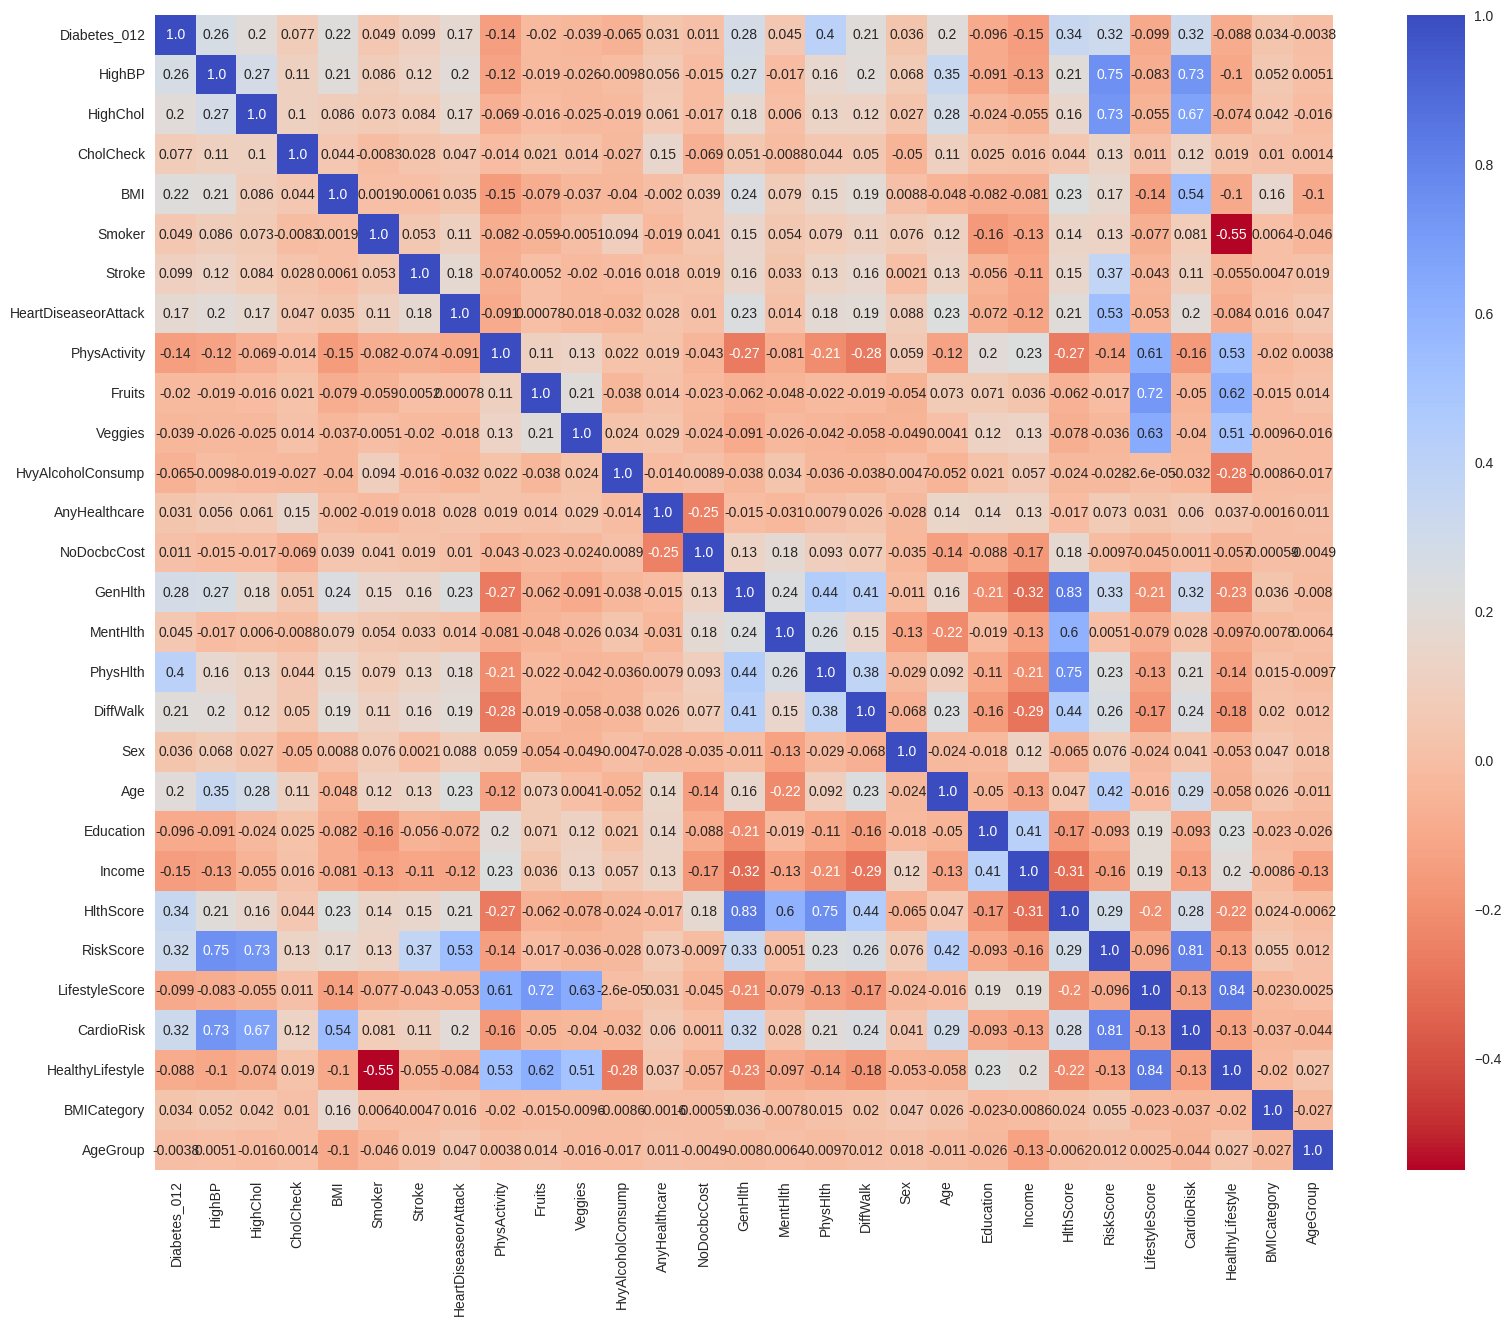

In [123]:
# Biểu đồ nhiệt thể hiện độ tương quan giữa các feature
plt.figure(figsize=(19, 15))
ax = sns.heatmap(clean_diabetes_df.corr(), cmap='coolwarm_r', fmt='.2', annot=True)
plt.show()

In [124]:
# Những nhân tố ảnh hướng đến kết quả dự đoán
clean_diabetes_df.corr()['Diabetes_012'].iloc[1:].sort_values(ascending=False)

PhysHlth                0.403884
HlthScore               0.340552
CardioRisk              0.320467
RiskScore               0.315365
GenHlth                 0.278590
HighBP                  0.263919
BMI                     0.217758
DiffWalk                0.209250
HighChol                0.204422
Age                     0.201837
HeartDiseaseorAttack    0.172779
Stroke                  0.098964
CholCheck               0.076979
Smoker                  0.048561
MentHlth                0.044696
Sex                     0.036045
BMICategory             0.034021
AnyHealthcare           0.031030
NoDocbcCost             0.010517
AgeGroup               -0.003845
Fruits                 -0.019883
Veggies                -0.039099
HvyAlcoholConsump      -0.064860
HealthyLifestyle       -0.087613
Education              -0.095980
LifestyleScore         -0.099343
PhysActivity           -0.142070
Income                 -0.148385
Name: Diabetes_012, dtype: float64

Như bạn có thể thấy, sau khi thực hiện feature engineering, độ tương quan của các feature mới và label `Diabetes_012` cho thấy được sự ảnh hưởng khá tốt đến kết quả dự đoán. Thuộc tính cũ như `PhysHlth`, cũng tăng gần như gấp đôi so với ban đầu mà chúng ta tính được. Ngoài ra, `HlthScore`, `CardioRisk` và `RiskScore` cho sự tương quan với label vượt trên cả các feature ban đầu như `BMI` hoặc `HighBP`.

#### **5.4.5 Feature selection**

Đây là bước mà chúng ta sẽ chọn lọc lại những feature có tương tác tốt đối với label. Mục đích là giảm được những feature không có sức ảnh hưởng nhiều đến label, bên cạnh đó chúng ta sẽ cải thiện được tốc độ huấn luyện mô hình nhưng không ảnh hưởng đến độ chính xác khi huấn luyện. Để thực hiện được điều đó, chúng ta sẽ sử dụng **độ tương quan** để lọc ra được những feature có độ tương quan tốt nhất.

In [127]:
# Những nhân tố ảnh hướng đến kết quả dự đoán
clean_diabetes_df.corr()['Diabetes_012'].iloc[1:].sort_values(ascending=False)

PhysHlth                0.403884
HlthScore               0.340552
CardioRisk              0.320467
RiskScore               0.315365
GenHlth                 0.278590
HighBP                  0.263919
BMI                     0.217758
DiffWalk                0.209250
HighChol                0.204422
Age                     0.201837
HeartDiseaseorAttack    0.172779
Stroke                  0.098964
CholCheck               0.076979
Smoker                  0.048561
MentHlth                0.044696
Sex                     0.036045
BMICategory             0.034021
AnyHealthcare           0.031030
NoDocbcCost             0.010517
AgeGroup               -0.003845
Fruits                 -0.019883
Veggies                -0.039099
HvyAlcoholConsump      -0.064860
HealthyLifestyle       -0.087613
Education              -0.095980
LifestyleScore         -0.099343
PhysActivity           -0.142070
Income                 -0.148385
Name: Diabetes_012, dtype: float64

Sau khi đã xem xét điểm về **độ tương quan** của mỗi thuộc tính đối với label mà chúng ta cần dự đoán, sau đó sẽ loại bỏ đi những thuộc tính không cần thiết. Để lọc ra được, chúng ta sẽ chọn một **ngưỡng (threshold)** để loại bỏ những feature không cần thiết. Với độ tương quan như trên, chúng ta sẽ cho ngưỡng là $0.05$ hoặc $0.1$.

In [129]:
def feature_selection(df, target_col, corr_threshold=0.1):
    # Phần correlation - xem xét giá trị tuyệt đối của tương quan
    correlations = df.corr()[target_col]
    correlations = correlations.drop(target_col)
    abs_correlations = abs(correlations)
    corr_features = set(abs_correlations[abs_correlations > corr_threshold].index.tolist())

    print("Features selected by correlation (and their correlation values):")
    for feature in corr_features:
        print(f"{feature}: {correlations[feature]:.4f}")
    return list(corr_features)

In [130]:
high_corr_features = feature_selection(clean_diabetes_df, 'Diabetes_012')
high_corr_features.append('Diabetes_012')

Features selected by correlation (and their correlation values):
HeartDiseaseorAttack: 0.1728
HlthScore: 0.3406
PhysHlth: 0.4039
RiskScore: 0.3154
BMI: 0.2178
Age: 0.2018
GenHlth: 0.2786
DiffWalk: 0.2092
HighChol: 0.2044
Income: -0.1484
PhysActivity: -0.1421
HighBP: 0.2639
CardioRisk: 0.3205


In [131]:
# Lọc các feature trong dữ liệu
prced_diabetes_df = clean_diabetes_df[high_corr_features]
prced_diabetes_df.head()

HeartDiseaseorAttack  HlthScore  PhysHlth  RiskScore   BMI  Age  GenHlth  \
0                   0.0   1.500000       5.0        1.0  15.0   11      5.0   
1                   1.0   0.400000       0.0        2.0  28.0   11      2.0   
2                   0.0   0.733333       0.0        2.0  33.0    9      2.0   
3                   1.0   1.833333      25.0        3.0  29.0   12      5.0   
4                   0.0   0.600000       0.0        0.0  24.0   13      3.0   

   DiffWalk  HighChol  Income  PhysActivity  HighBP  CardioRisk  Diabetes_012  
0       0.0       1.0     5.0             0       0         1.0           0.0  
1       0.0       0.0     3.0             0       1         1.0           2.0  
2       0.0       1.0     7.0             1       1         3.0           2.0  
3       1.0       1.0     4.0             1       0         1.0           2.0  
4       1.0       0.0     6.0             0       0         0.0           0.0

In [132]:
prced_diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223550 entries, 0 to 236377
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  223550 non-null  float64
 1   HlthScore             223550 non-null  float64
 2   PhysHlth              223550 non-null  float64
 3   RiskScore             223550 non-null  float64
 4   BMI                   223550 non-null  float64
 5   Age                   223550 non-null  int64  
 6   GenHlth               223550 non-null  float64
 7   DiffWalk              223550 non-null  float64
 8   HighChol              223550 non-null  float64
 9   Income                223550 non-null  float64
 10  PhysActivity          223550 non-null  int64  
 11  HighBP                223550 non-null  int64  
 12  CardioRisk            223550 non-null  float64
 13  Diabetes_012          223550 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 25.6 MB


#### **5.4.6 Tách dữ liệu train và test**

Sau khi đã kiểm tra những feature mới hoạt động khá tốt thì chúng ta tiếp tục đến bước tách tập dữ liệu train và test

In [134]:
# Tách feature và label
prced_X = prced_diabetes_df.drop(columns=['Diabetes_012'])
prced_y = prced_diabetes_df['Diabetes_012']

In [135]:
print(f'Số dòng và cột của feature mới: {prced_X.shape}')
print(f'Số dòng và cột của label mới: {prced_y.shape}')

Số dòng và cột của feature mới: (223550, 13)
Số dòng và cột của label mới: (223550,)


In [136]:
# Tách tập train và test trên dữ liệu mới
prced_X_train, prced_X_test, prced_y_train, prced_y_test = train_test_split(
    prced_X,
    prced_y,
    train_size=0.8,
    random_state=42,
    stratify=prced_y
)

In [137]:
print(f'Số dòng và cột của train feature: {prced_X_train.shape}')
print(f'Số dòng và cột của train label: {prced_X_test.shape}')
print(f'Số dòng và cột của test feature: {prced_y_train.shape}')
print(f'Số dòng và cột của test label: {prced_y_test.shape}')

Số dòng và cột của train feature: (178840, 13)
Số dòng và cột của train label: (44710, 13)
Số dòng và cột của test feature: (178840,)
Số dòng và cột của test label: (44710,)


#### **5.4.7 Cân bằng dữ liệu**

Như kết quả đánh giá của các mô hình ban đầu cho thấy rằng dữ liệu đang bị mất cân bằng, bây giờ chúng ta sẽ thực hiện tiếp một bước nữa đó là cân bằng dữ liệu train để đưa vào mô hình để huấn luyện. Để xử lý được vấn đề mất cân bằng dữ liệu ta có rất nhiều thuật toán có thể giải quyết được điều này, nhưng nhìn chúng thì có 3 loại phổ biến nhất đó là **over-sampling**, **under-sampling** và **hybrid** (kết hợp giữa over-sampling và under-sampling).

Trong nghiên cứu này, đối với mỗi phương pháp sẽ sử dụng một thuật toán và cùng so sánh kết quả của cả 3 giải pháp trên cả 3 mô hình học máy là Random Forest, KNN và MLP. Đối với **over-sampling**, chúng ta sẽ sử dụng thuật toán **SMOTE** để tăng số lượng lớp thiểu số bằng với lớp đa số, đối với **under-sampling** chúng ta sẽ dùng thuật toán **Tomek Links** để giảm đi các lớp đa số và cuối cùng là **hyprid** chúng ta sẽ dùng **SMOTETomek**.

Để dễ dàng thực hiện được việc cân bằng dữ liệu, chúng ta sẽ sử dụng đến thư viện **Imbalanced Learn**, đây là một thư viện gần giống với **Scikit Learn**, thư viện cung cấp cho chúng ta những class để thực hiện các xử lý dữ liệu một cách thuận tiện thay vì thủ công.

In [139]:
# Dữ liệu train trước khi cân bằng
print(f'Số lượng dòng và cột của dữ liệu train ban đầu: {prced_X_train.shape}')

Số lượng dòng và cột của dữ liệu train ban đầu: (178840, 13)


In [140]:
# Số lượng label trước khi cân bằng
prced_y_train.value_counts()

Diabetes_012
0.0    147634
2.0     26716
1.0      4490
Name: count, dtype: int64

**SMOTE**

Thuật toán SMOTE (Synthetic Minority Over-sampling Technique) là một kỹ thuật xử lý mất cân bằng dữ liệu (class imbalance) trong học máy và khoa học dữ liệu. SMOTE được phát triển để giải quyết vấn đề mất cân bằng lớp (class imbalance), một tình huống phổ biến trong các bài toán phân loại, trong đó:

- Một lớp (lớp thiểu số) có số lượng mẫu rất ít so với lớp kia (lớp đa số)
- Điều này có thể dẫn đến các mô hình máy học có xu hướng dự đoán sai hoặc kém hiệu quả

Đây là một thuật toán chuyên dụng cho việc cân bằng dữ liệu thuộc bài toán **over-sampling**, mục đích của bài toán này là tạo ra những dữ liệu mới cho các class thiểu số bằng với các class đa số dựa trên thuật toán **KNN**. Thuật toán sẽ tìm những `n` hàng xóm xung quanh cùng nhãn để tính toán và tạo ra những dữ liệu giả.

<div style="display: flex; justify-content: center">
    <img
        src="https://rikunert.com/wp-content/uploads/2017/11/the-basic-principle-of-the-synthetic-minority-oversample-technique-smote-algorithm-5452514.png"
        alt="Application Machine Learning in diabetes prediction"
        style="width: 800px;"
    />
</div>

In [142]:
# Cân bằng dữ liệu bằng SMOTE
smote = SMOTE(
    sampling_strategy={
        0: 147634,  # Giữ nguyên class đa số
        1: 50000,   # Tăng vừa phải, không cần bằng hoàn toàn
        2: 50000    # Tăng vừa phải
    }
)
resampled_smote_X_train, resampled_smote_y_train = smote.fit_resample(prced_X_train, prced_y_train)

In [143]:
# Dữ liệu train sau khi cân bằng
print(f'Số lượng dòng và cột của dữ liệu train sau khi cân bằng: {resampled_smote_X_train.shape}')

Số lượng dòng và cột của dữ liệu train sau khi cân bằng: (247634, 13)


In [144]:
# Số lượng label sau cân bằng
resampled_smote_y_train.value_counts()

Diabetes_012
0.0    147634
2.0     50000
1.0     50000
Name: count, dtype: int64

**Tomek Links**

Đây là một thuật toán thuộc bài toán under-sampling, mục đích của bài toán này là giảm các lớp đa số về gần bằng với các class thiểu số, ý tưởng thuật toán này là tìm hai điểm $x_{i}$ và $y_{i}$ bất kỳ thuộc 2 class khác nhau trong tập dữ liệu, sao cho 2 điểm này là láng giềng gần nhất (không tồn tại bất kỳ điểm nào giữa 2 điểm này), khoảng cách giữa hai điểm này là gần nhất (đo bằng Euclidean, Manhattan, ...), thì chúng được gọi là **Tomek Links**. Cuối cùng, những **Tomek Links** này sẽ triệt tiêu đi những điểm thuộc lớp đa số.

<div style="display: flex; justify-content: center">
    <img
        src="https://www.mdpi.com/mathematics/mathematics-12-01709/article_deploy/html/images/mathematics-12-01709-g001.png"
        alt="Application Machine Learning in diabetes prediction"
        style="width: 800px;"
    />
</div>

In [146]:
# Cân bằng dữ liệu
tomek_links = TomekLinks(
    n_jobs=num_of_core
)
resampled_tomek_X_train, resampled_tomek_y_train = tomek_links.fit_resample(prced_X_train, prced_y_train)

In [147]:
# Dữ liệu train sau khi cân bằng
print(f'Số lượng dòng và cột của dữ liệu train sau khi cân bằng: {resampled_tomek_X_train.shape}')

Số lượng dòng và cột của dữ liệu train sau khi cân bằng: (171627, 13)


In [148]:
# Số lượng label sau cân bằng
resampled_tomek_y_train.value_counts()

Diabetes_012
0.0    143885
2.0     23252
1.0      4490
Name: count, dtype: int64

**SmoteTomek**

Đây là thuật toán kết hợp giữa 2 dạng là over-sampling và under-sampling, còn được gọi là **hybrid**. Thuật toán này sẽ thực hiện thuật toán SMOTE để cân bằng dữ liệu giữa các class, sau đó thực hiện Tomek Links để loại bỏ đi các class đa số.

<div style="display: flex; justify-content: center">
    <img
        src="https://www.researchgate.net/publication/372292051/figure/fig1/AS:11431281174194753@1689164490909/Augmentation-using-SMOTE-Tomek-a-Original-unbalanced-data-b-After-applying-SMOTE-C.ppm"
        alt="Application Machine Learning in diabetes prediction"
        style="width: 800px;"
    />
</div>

In [150]:
# Cân bằng dữ liệu
smote_tomek = SMOTETomek(
    sampling_strategy={
        0: 147634,  # Giữ nguyên class đa số
        1: 50000,   # Tăng vừa phải, không cần bằng hoàn toàn
        2: 50000    # Tăng vừa phải
    },
    n_jobs=num_of_core
)
resampled_smte_X_train, resampled_smte_y_train = smote_tomek.fit_resample(prced_X_train, prced_y_train)

In [151]:
# Dữ liệu train sau khi cân bằng
print(f'Số lượng dòng và cột của dữ liệu train sau khi cân bằng: {resampled_smte_X_train.shape}')

Số lượng dòng và cột của dữ liệu train sau khi cân bằng: (243582, 13)


In [152]:
# Số lượng label sau cân bằng
resampled_smte_y_train.value_counts()

Diabetes_012
0.0    145728
1.0     49654
2.0     48200
Name: count, dtype: int64

#### **5.4.8 Chuẩn hóa dữ liệu**

**Dữ liệu cân bằng bằng thuật toán SMOTE**

In [155]:
# Chuẩn hóa các feature huấn luyện
smote_min_max_scaler = MinMaxScaler()
# Chuẩn hóa
normalized_smote_X_train = smote_min_max_scaler.fit_transform(resampled_smote_X_train)
normalized_smote_X_test = smote_min_max_scaler.transform(prced_X_test)

In [156]:
normalized_smote_X_train.shape

(247634, 13)

In [157]:
# Sau khi chuẩn hóa
normalized_smote_X_train[0]

array([0.        , 0.2601626 , 0.        , 0.25      , 0.26666667,
       0.83333333, 0.25      , 0.        , 0.        , 0.7       ,
       1.        , 1.        , 0.33333333])

**Dữ liệu cân bằng bằng thuật toán Tomek Links**

In [159]:
# Chuẩn hóa các feature huấn luyện
tomek_min_max_scaler = MinMaxScaler()
# Chuẩn hóa
normalized_tomek_X_train = tomek_min_max_scaler.fit_transform(resampled_tomek_X_train)
normalized_tomek_X_test = tomek_min_max_scaler.fit_transform(prced_X_test)

In [160]:
normalized_tomek_X_train.shape

(171627, 13)

In [161]:
# Sau khi chuẩn hóa
normalized_tomek_X_train[0]

array([0.        , 0.2601626 , 0.        , 0.25      , 0.26666667,
       0.83333333, 0.25      , 0.        , 0.        , 0.7       ,
       1.        , 1.        , 0.33333333])

**Dữ liệu cân bằng bằng thuật toán SMOTETomek**

In [163]:
# Chuẩn hóa các feature huấn luyện
smte_min_max_scaler = MinMaxScaler()
# Chuẩn hóa
normalized_smte_X_train = smte_min_max_scaler.fit_transform(resampled_smte_X_train)
normalized_smte_X_test = tomek_min_max_scaler.fit_transform(prced_X_test)

In [164]:
normalized_smte_X_train.shape

(243582, 13)

In [165]:
# Sau khi chuẩn hóa
normalized_smte_X_train[0]

array([0.        , 0.2601626 , 0.        , 0.25      , 0.26666667,
       0.83333333, 0.25      , 0.        , 0.        , 0.7       ,
       1.        , 1.        , 0.33333333])

## **6. Huấn luyện mô hình**

Sau khi đã có được dữ liệu của 3 phương pháp cân bằng khác nhau, bây giờ chúng ta sẽ đưa cả 3 bộ dữ liệu mới vào 3 mô hình **Random Forest**, **K-Nearest Neighbors** và **Multi-layer Perceptron Classifier**. Để so sánh từng dạng cân bằng như thế nào.

### **6.1 SMOTE data**

#### **6.1.1 Random Forest**

In [169]:
smote_random_forest_model = RandomForestClassifier(
    n_estimators=100,       # Số cây trong rừng
    max_depth=5,           # Độ sâu tối đa của mỗi cây
)
# Huấn luyện mô hình
smote_random_forest_model.fit(normalized_smote_X_train, resampled_smote_y_train)

RandomForestClassifier(max_depth=5)

In [170]:
# Dự đoán
smote_rf_y_pred = smote_random_forest_model.predict(normalized_smote_X_test)
smote_rf_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [171]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=smote_rf_y_pred, model_name='Random Forest với SMOTE data')

Kết quả đánh giá cho Random Forest với SMOTE data:
--------------------------------------------------
Accuracy: 0.8717
Precision (macro): 0.7745
Recall (macro): 0.5001
F1-score (macro): 0.5544

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     36908
         1.0       0.46      0.23      0.31      1123
         2.0       0.99      0.27      0.43      6679

    accuracy                           0.87     44710
   macro avg       0.77      0.50      0.55     44710
weighted avg       0.88      0.87      0.84     44710



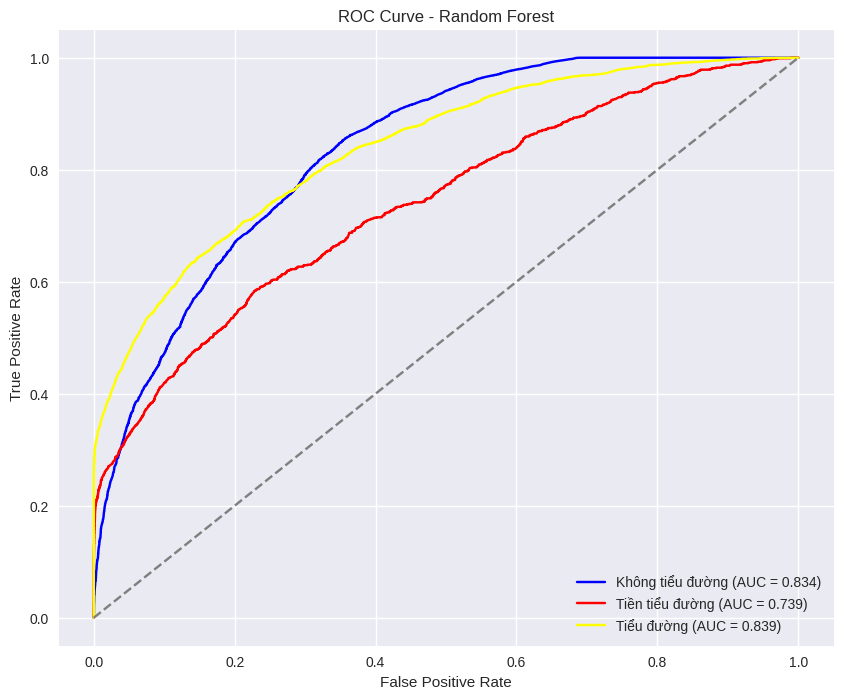

In [172]:
# Vẽ biểu đồ ROC và AUC
smote_rf_proba = smote_random_forest_model.predict_proba(normalized_smote_X_test)
plot_roc_auc(prced_y_test, smote_rf_proba, model_name='Random Forest')

#### **6.1.2 K-Nearest Neighbors**

In [174]:
smote_knn_model = KNeighborsClassifier(
    n_neighbors=5,
    n_jobs=num_of_core
)
# Huấn luyện mô hình
smote_knn_model.fit(normalized_smote_X_train, resampled_smote_y_train)

KNeighborsClassifier(n_jobs=8)

In [175]:
# Dự đoán
smote_knn_y_pred = smote_knn_model.predict(normalized_smote_X_test)
smote_knn_y_pred

array([0., 0., 1., ..., 0., 0., 0.])

In [176]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=smote_knn_y_pred, model_name='KNN với SMOTE data')

Kết quả đánh giá cho KNN với SMOTE data:
--------------------------------------------------
Accuracy: 0.8094
Precision (macro): 0.4977
Recall (macro): 0.4806
F1-score (macro): 0.4816

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     36908
         1.0       0.09      0.16      0.11      1123
         2.0       0.52      0.37      0.44      6679

    accuracy                           0.81     44710
   macro avg       0.50      0.48      0.48     44710
weighted avg       0.81      0.81      0.81     44710



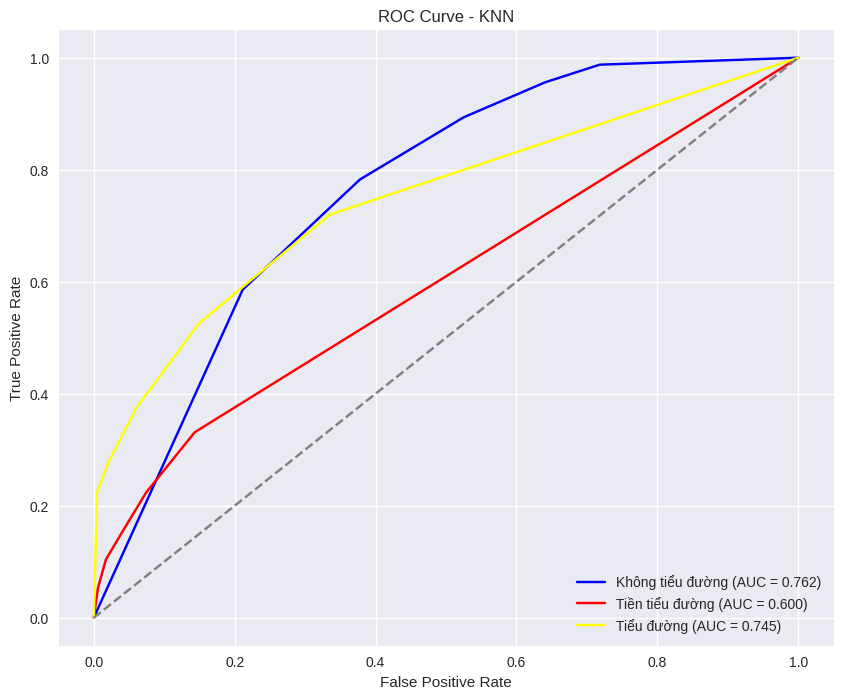

In [177]:
# Vẽ biểu đồ ROC và AUC
smote_knn_proba = smote_knn_model.predict_proba(normalized_smote_X_test)
plot_roc_auc(prced_y_test, smote_knn_proba, model_name='KNN')

#### **6.1.3 Multi-layer Perceptron**

In [179]:
# Định nghĩa mô hình MLP
smote_mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 128, 64),    # 3 hidden layers với 64, 128 và 64 neurons
    activation='relu',                   # hàm kích hoạt
    solver='adam',                       # thuật toán tối ưu
    max_iter=50,                         # số vòng lặp tối đa
)

# Huấn luyện mô hình
smote_mlp_model.fit(normalized_smote_X_train, resampled_smote_y_train)

MLPClassifier(hidden_layer_sizes=(64, 128, 64), max_iter=50)

In [180]:
# Dự đoán
smote_mlp_y_pred = smote_mlp_model.predict(normalized_smote_X_test)
smote_mlp_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [181]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=smote_mlp_y_pred, model_name='MLP với SMOTE data')

Kết quả đánh giá cho MLP với SMOTE data:
--------------------------------------------------
Accuracy: 0.8615
Precision (macro): 0.6128
Recall (macro): 0.5325
F1-score (macro): 0.5561

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93     36908
         1.0       0.20      0.22      0.21      1123
         2.0       0.75      0.41      0.53      6679

    accuracy                           0.86     44710
   macro avg       0.61      0.53      0.56     44710
weighted avg       0.85      0.86      0.85     44710



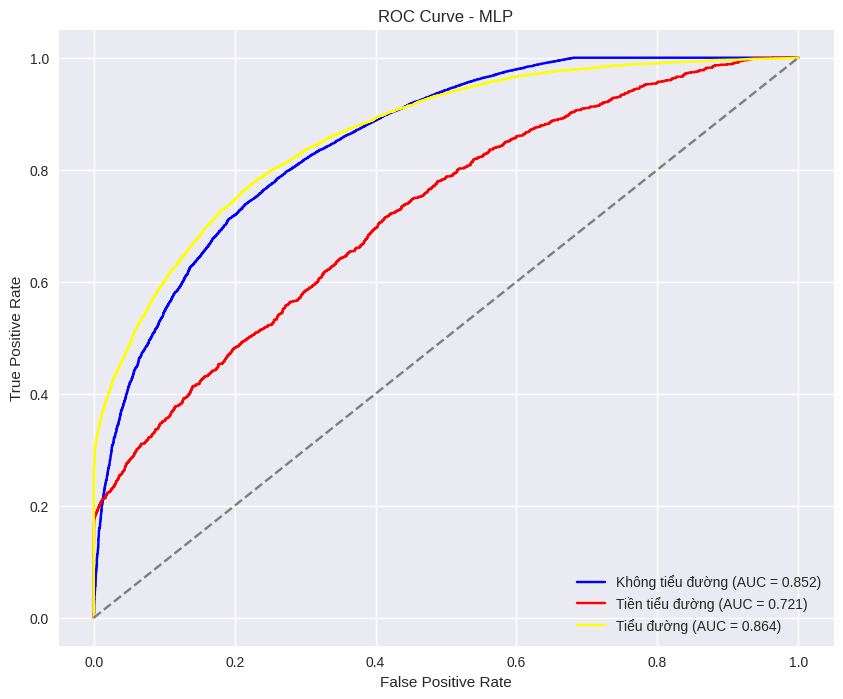

In [182]:
# Vẽ biểu đồ ROC và AUC
smote_mlp_proba = smote_mlp_model.predict_proba(normalized_smote_X_test)
plot_roc_auc(prced_y_test, smote_mlp_proba, model_name='MLP')

#### **6.1.4 So sánh**

In [184]:
# Tạo dictionary chứa các mô hình
smote_models = {
    'Random Forest': smote_random_forest_model,
    'KNN': smote_knn_model,
    'MLP': smote_mlp_model
}

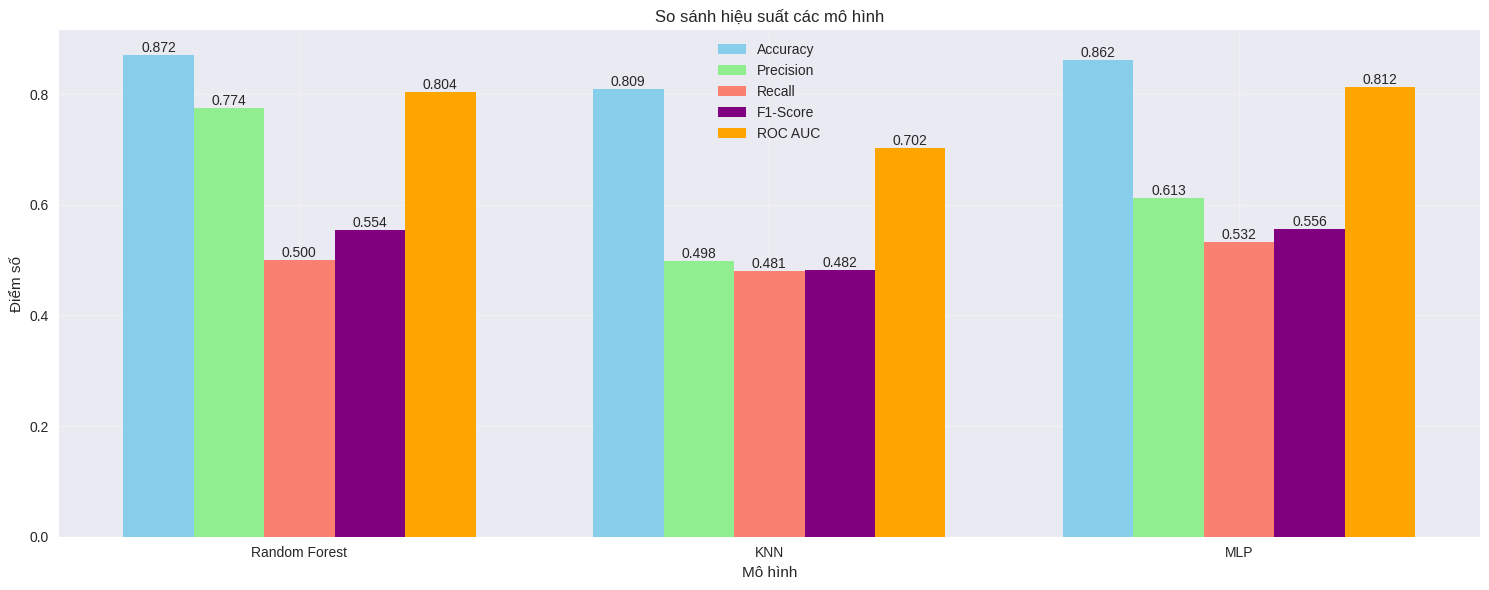

In [185]:
# So sánh các mô hình
smote_comparison_results = compare_models(smote_models, normalized_smote_X_test, prced_y_test)

In [186]:
smote_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8717     0.7745  0.5001    0.5544   0.8037   
1            KNN    0.8094     0.4977  0.4806    0.4816   0.7021   
2            MLP    0.8615     0.6128  0.5325    0.5561   0.8122   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8720            0.4599            0.9918         1.0000   
1            0.8854            0.0868            0.5210         0.9078   
2            0.8931            0.1998            0.7454         0.9621   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.2297         0.2705     0.9316     0.3064     0.4251  
1         0.1594         0.3748     0.8964     0.1124     0.4359  
2         0.2226         0.4129     0.9263     0.2106     0.5315

### **6.2 Tomek Link**

#### **6.2.1 Random Forest**

In [189]:
tomek_random_forest_model = RandomForestClassifier(
    n_estimators=100,       # Số cây trong rừng
    max_depth=5,           # Độ sâu tối đa của mỗi cây
)
# Huấn luyện mô hình
tomek_random_forest_model.fit(normalized_tomek_X_train, resampled_tomek_y_train)

RandomForestClassifier(max_depth=5)

In [190]:
# Dự đoán
tomek_rf_y_pred = tomek_random_forest_model.predict(normalized_tomek_X_test)
tomek_rf_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [191]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=tomek_rf_y_pred, model_name='Random Forest với Tomek data')

Kết quả đánh giá cho Random Forest với Tomek data:
--------------------------------------------------
Accuracy: 0.8754
Precision (macro): 0.9199
Recall (macro): 0.4450
F1-score (macro): 0.4733

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     36908
         1.0       1.00      0.00      0.00      1123
         2.0       0.88      0.33      0.48      6679

    accuracy                           0.88     44710
   macro avg       0.92      0.44      0.47     44710
weighted avg       0.88      0.88      0.84     44710



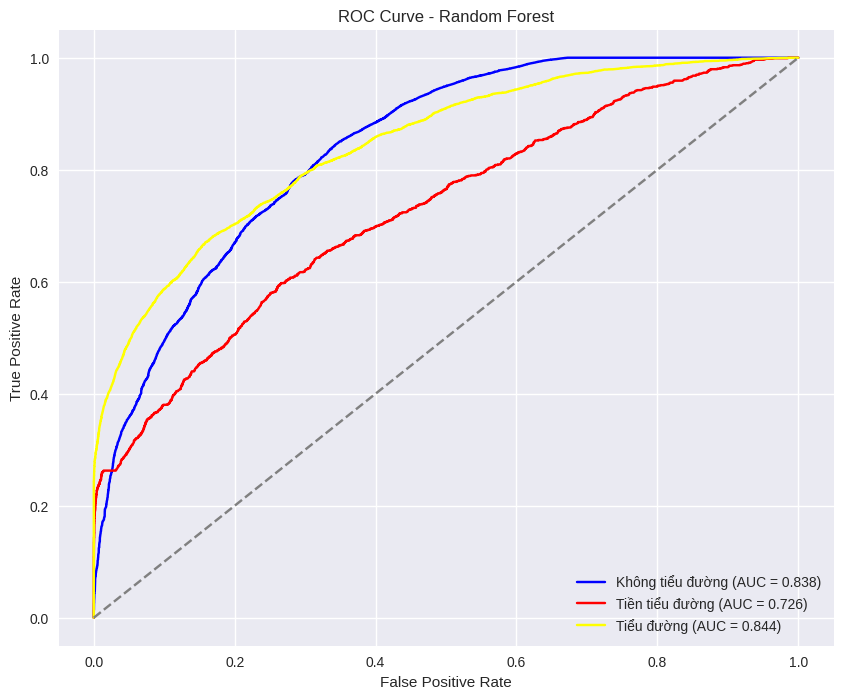

In [192]:
# Vẽ biểu đồ ROC và AUC
tomek_rf_proba = tomek_random_forest_model.predict_proba(normalized_tomek_X_test)
plot_roc_auc(prced_y_test, tomek_rf_proba, model_name='Random Forest')

#### **6.2.2 K-Nearest Neighbors**

In [194]:
tomek_knn_model = KNeighborsClassifier(
    n_neighbors=5,
    n_jobs=num_of_core
)
# Huấn luyện mô hình
tomek_knn_model.fit(normalized_tomek_X_train, resampled_tomek_y_train)

KNeighborsClassifier(n_jobs=8)

In [195]:
# Dự đoán
tomek_knn_y_pred = tomek_knn_model.predict(normalized_tomek_X_test)
tomek_knn_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [196]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=tomek_knn_y_pred, model_name='KNN với Tomek data')

Kết quả đánh giá cho KNN với Tomek data:
--------------------------------------------------
Accuracy: 0.8560
Precision (macro): 0.6045
Recall (macro): 0.4453
F1-score (macro): 0.4727

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     36908
         1.0       0.26      0.03      0.05      1123
         2.0       0.68      0.33      0.44      6679

    accuracy                           0.86     44710
   macro avg       0.60      0.45      0.47     44710
weighted avg       0.83      0.86      0.83     44710



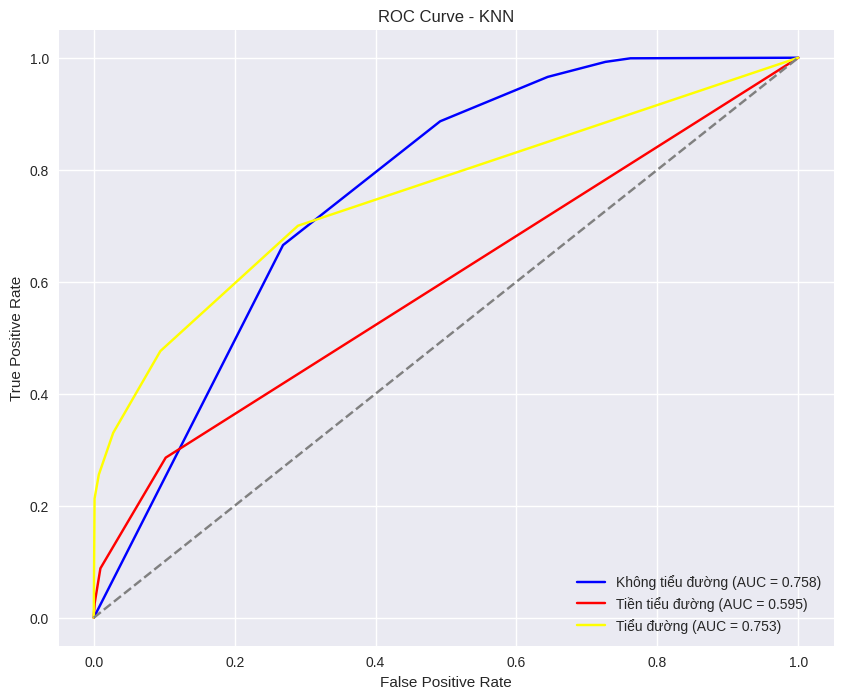

In [197]:
# Vẽ biểu đồ ROC và AUC
tomek_knn_proba = tomek_knn_model.predict_proba(normalized_tomek_X_test)
plot_roc_auc(prced_y_test, tomek_knn_proba, model_name='KNN')

#### **6.2.3 Multi-layer Perceptron**

In [199]:
# Định nghĩa mô hình MLP
tomek_mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 128, 64),    # 3 hidden layers với 64, 128 và 64 neurons
    activation='relu',                   # hàm kích hoạt
    solver='adam',                       # thuật toán tối ưu
    max_iter=50,                         # số vòng lặp tối đa
)

# Huấn luyện mô hình
tomek_mlp_model.fit(normalized_tomek_X_train, resampled_tomek_y_train)

MLPClassifier(hidden_layer_sizes=(64, 128, 64), max_iter=50)

In [200]:
# Dự đoán
tomek_mlp_y_pred = tomek_mlp_model.predict(normalized_tomek_X_test)
tomek_mlp_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [201]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=tomek_mlp_y_pred, model_name='MLP với Tomek data')

Kết quả đánh giá cho MLP với Tomek data:
--------------------------------------------------
Accuracy: 0.8797
Precision (macro): 0.8873
Recall (macro): 0.5132
F1-score (macro): 0.5820

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     36908
         1.0       0.92      0.17      0.29      1123
         2.0       0.86      0.37      0.52      6679

    accuracy                           0.88     44710
   macro avg       0.89      0.51      0.58     44710
weighted avg       0.88      0.88      0.86     44710



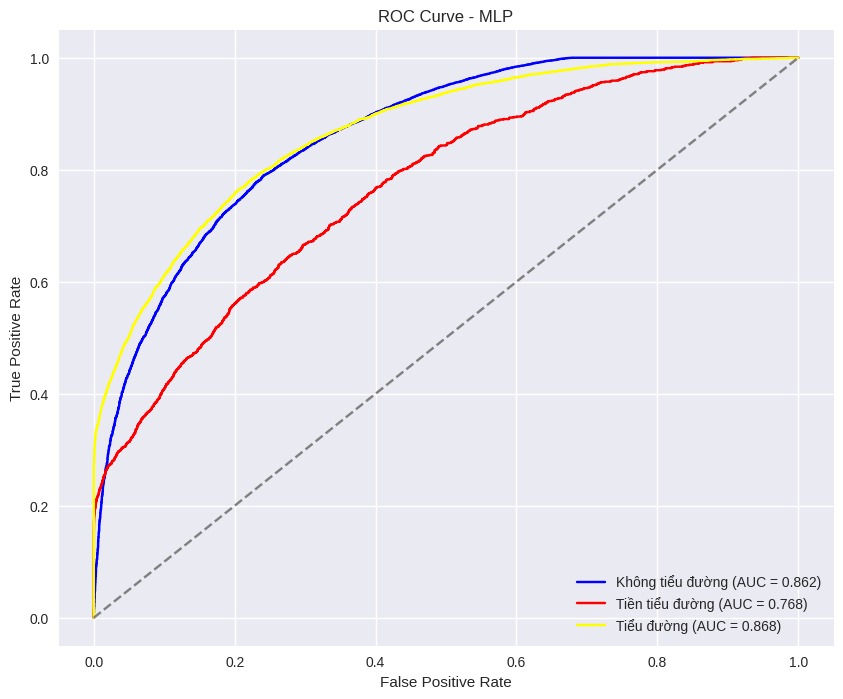

In [202]:
# Vẽ biểu đồ ROC và AUC
tomek_mlp_proba = tomek_mlp_model.predict_proba(normalized_tomek_X_test)
plot_roc_auc(prced_y_test, tomek_mlp_proba, model_name='MLP')

#### **6.2.4 So sánh**

In [204]:
# Tạo dictionary chứa các mô hình
tomek_models = {
    'Random Forest': tomek_random_forest_model,
    'KNN': tomek_knn_model,
    'MLP': tomek_mlp_model
}

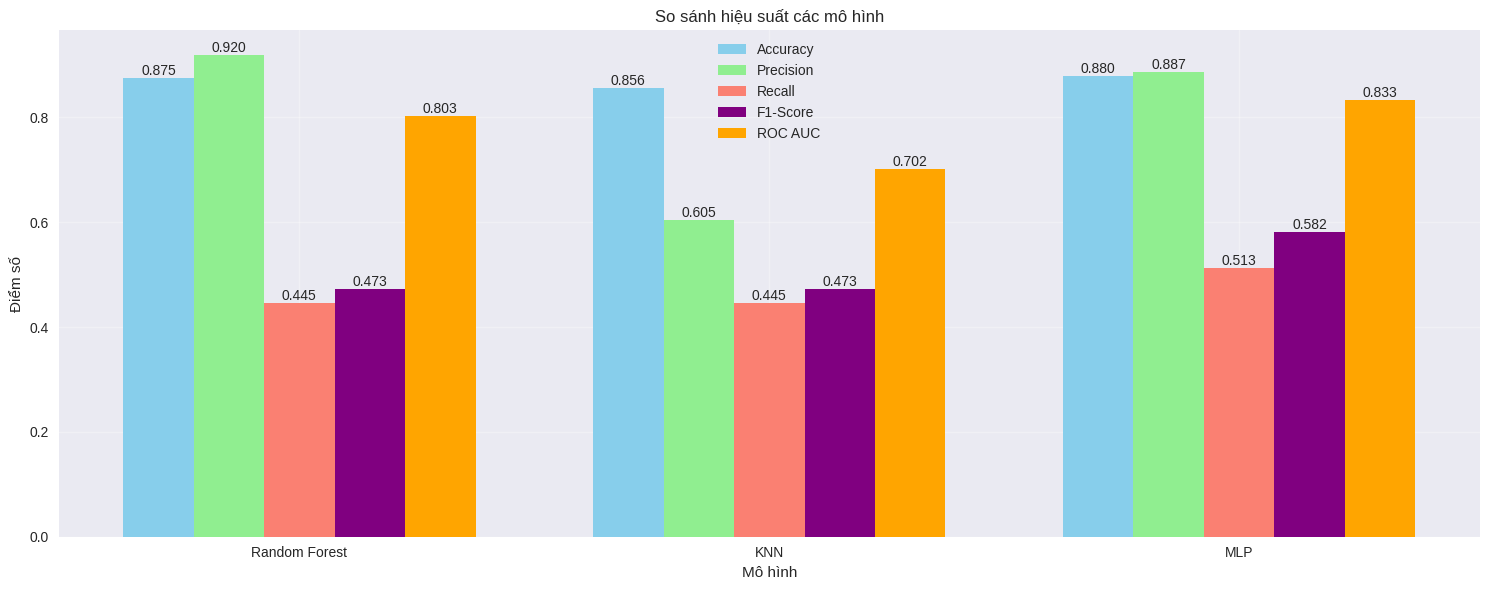

In [205]:
# So sánh các mô hình
tomek_comparison_results = compare_models(tomek_models, normalized_tomek_X_test, prced_y_test)

In [206]:
tomek_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8754     0.9199  0.4450    0.4733   0.8027   
1            KNN    0.8560     0.6045  0.4453    0.4727   0.7018   
2            MLP    0.8797     0.8873  0.5132    0.5820   0.8327   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8748            1.0000            0.8850         1.0000   
1            0.8718            0.2640            0.6776         0.9763   
2            0.8808            0.9194            0.8617         0.9927   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.0009         0.3340     0.9332     0.0018     0.4850  
1         0.0294         0.3301     0.9211     0.0529     0.4440  
2         0.1728         0.3740     0.9334     0.2909     0.5216

### **6.3 SMOTETomek data**

#### **6.3.1 Random Forest**

In [209]:
smte_random_forest_model = RandomForestClassifier(
    n_estimators=100,       # Số cây trong rừng
    max_depth=5,            # Độ sâu tối đa của mỗi cây
    n_jobs=num_of_core
)
# Huấn luyện mô hình
smte_random_forest_model.fit(normalized_smte_X_train, resampled_smte_y_train)

RandomForestClassifier(max_depth=5, n_jobs=8)

In [210]:
# Dự đoán
smte_rf_y_pred = smte_random_forest_model.predict(normalized_smte_X_test)
smte_rf_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [211]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=smte_rf_y_pred, model_name='Random Forest với SMOTETomek data')

Kết quả đánh giá cho Random Forest với SMOTETomek data:
--------------------------------------------------
Accuracy: 0.8727
Precision (macro): 0.7810
Recall (macro): 0.5011
F1-score (macro): 0.5576

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     36908
         1.0       0.48      0.23      0.31      1123
         2.0       0.99      0.28      0.43      6679

    accuracy                           0.87     44710
   macro avg       0.78      0.50      0.56     44710
weighted avg       0.88      0.87      0.84     44710



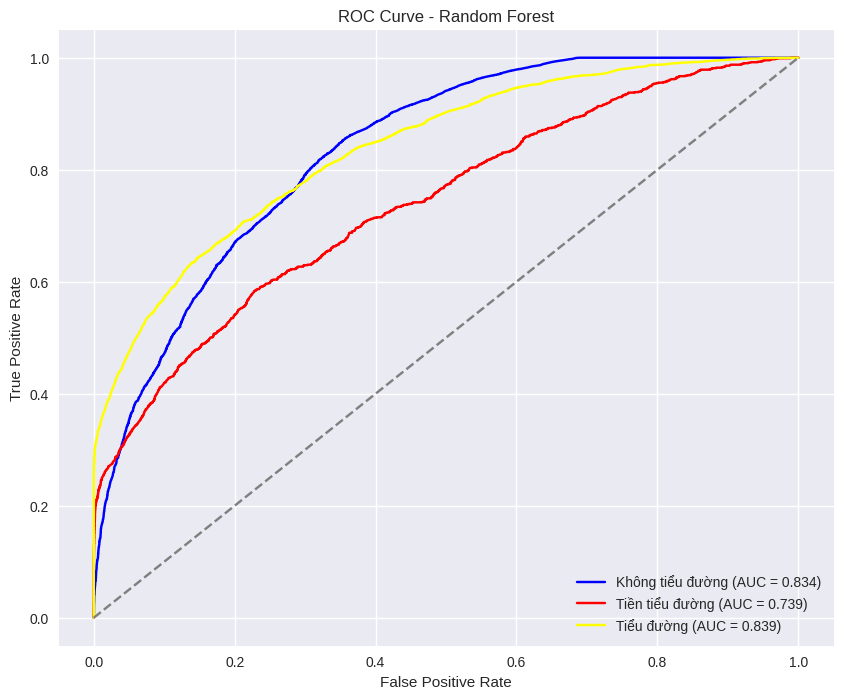

In [212]:
# Vẽ biểu đồ ROC và AUC
smte_rf_proba = smte_random_forest_model.predict_proba(normalized_smte_X_test)
plot_roc_auc(prced_y_test, smote_rf_proba, model_name='Random Forest')

#### **6.3.2 K-Nearest Neighbors**

In [214]:
smte_knn_model = KNeighborsClassifier(
    n_neighbors=5,
    n_jobs=num_of_core
)
# Huấn luyện mô hình
smte_knn_model.fit(normalized_smte_X_train, resampled_smte_y_train)

KNeighborsClassifier(n_jobs=8)

In [215]:
# Dự đoán
smte_knn_y_pred = smte_knn_model.predict(normalized_smte_X_test)
smte_knn_y_pred

array([0., 0., 1., ..., 0., 0., 0.])

In [216]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=smte_knn_y_pred, model_name='KNN với SMOTETomek data')

Kết quả đánh giá cho KNN với SMOTETomek data:
--------------------------------------------------
Accuracy: 0.8053
Precision (macro): 0.4975
Recall (macro): 0.4831
F1-score (macro): 0.4809

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     36908
         1.0       0.09      0.17      0.11      1123
         2.0       0.52      0.37      0.43      6679

    accuracy                           0.81     44710
   macro avg       0.50      0.48      0.48     44710
weighted avg       0.81      0.81      0.81     44710



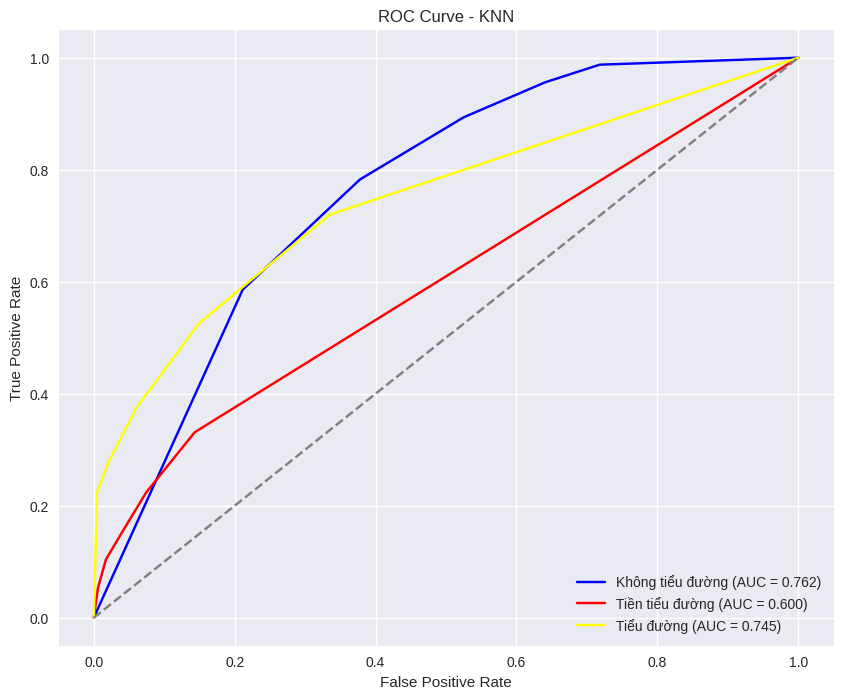

In [217]:
# Vẽ biểu đồ ROC và AUC
smte_knn_proba = smte_knn_model.predict_proba(normalized_smte_X_test)
plot_roc_auc(prced_y_test, smote_knn_proba, model_name='KNN')

#### **6.3.3 Multi-layer Perceptron**

In [219]:
# Định nghĩa mô hình MLP
smte_mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 128, 64),    # 3 hidden layers với 64, 128 và 64 neurons
    activation='relu',                   # hàm kích hoạt
    solver='adam',                       # thuật toán tối ưu
    max_iter=50,                         # số vòng lặp tối đa
)

# Huấn luyện mô hình
smte_mlp_model.fit(normalized_smte_X_train, resampled_smte_y_train)

MLPClassifier(hidden_layer_sizes=(64, 128, 64), max_iter=50)

In [220]:
# Dự đoán
smte_mlp_y_pred = smte_mlp_model.predict(normalized_smte_X_test)
smte_mlp_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [221]:
# Đánh giá mô hình
evaluate_model(y_true=prced_y_test, y_pred=smte_mlp_y_pred, model_name='MLP với SMOTETomek data')

Kết quả đánh giá cho MLP với SMOTETomek data:
--------------------------------------------------
Accuracy: 0.8612
Precision (macro): 0.6201
Recall (macro): 0.5306
F1-score (macro): 0.5560

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93     36908
         1.0       0.21      0.23      0.22      1123
         2.0       0.76      0.40      0.52      6679

    accuracy                           0.86     44710
   macro avg       0.62      0.53      0.56     44710
weighted avg       0.85      0.86      0.85     44710



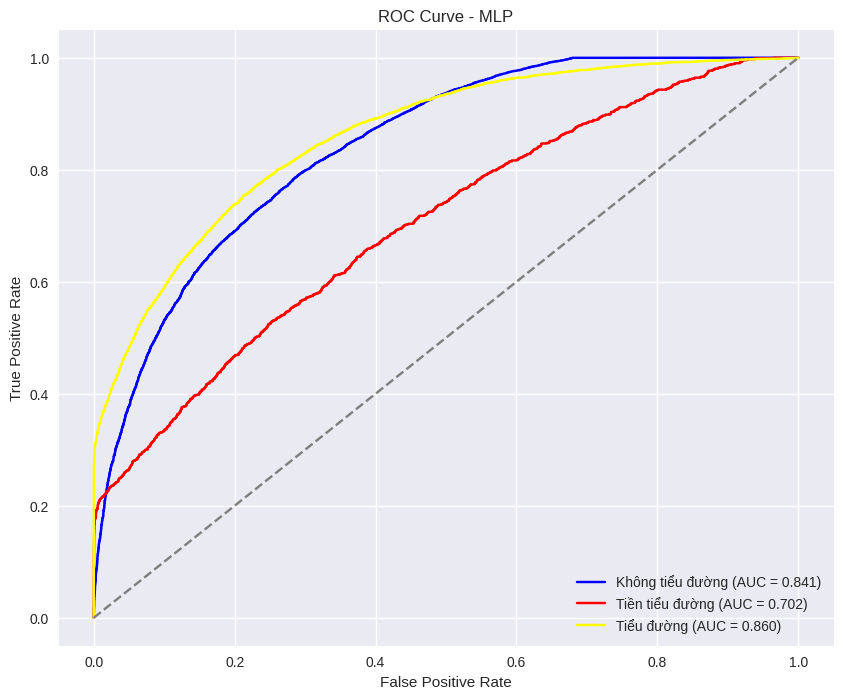

In [222]:
# Vẽ biểu đồ ROC và AUC
smte_mlp_proba = smte_mlp_model.predict_proba(normalized_smte_X_test)
plot_roc_auc(prced_y_test, smte_mlp_proba, model_name='MLP')

#### **6.3.4 So sánh**

In [224]:
# Tạo dictionary chứa các mô hình
smte_models = {
    'Random Forest': smte_random_forest_model,
    'KNN': smte_knn_model,
    'MLP': smte_mlp_model
}

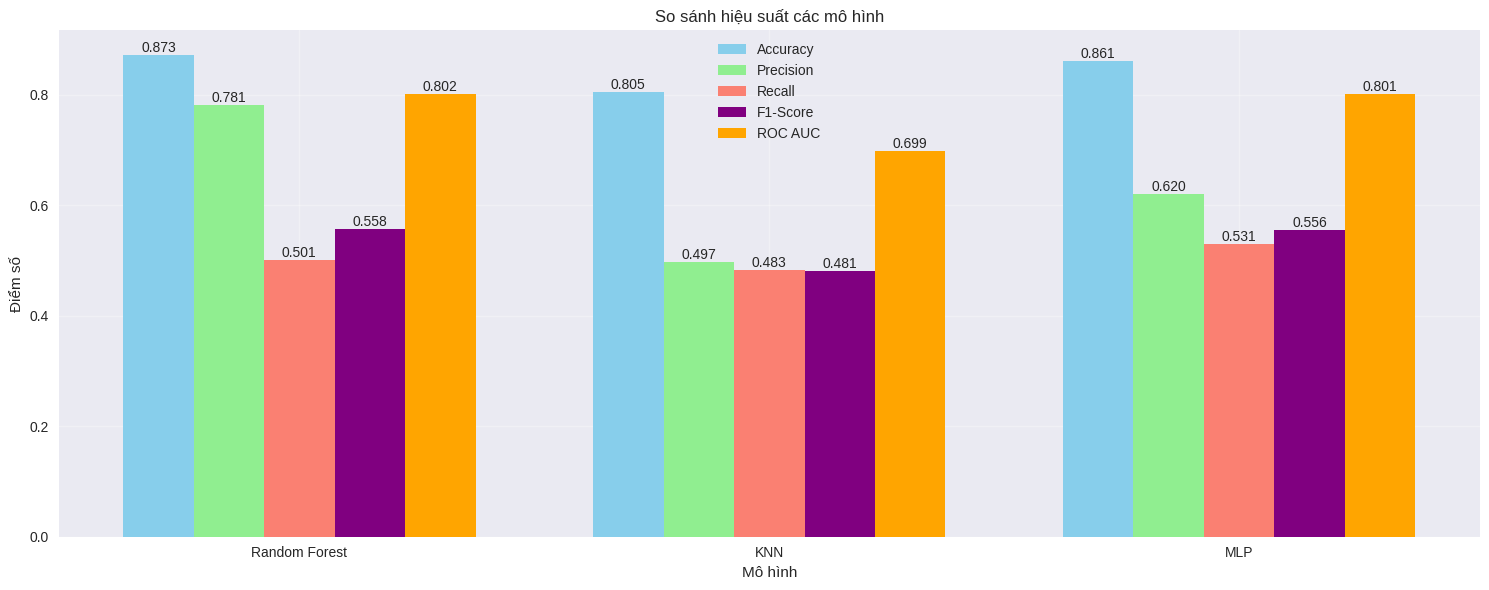

In [225]:
# So sánh các mô hình
smte_comparison_results = compare_models(smte_models, normalized_smte_X_test, prced_y_test)

In [226]:
smte_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8727     0.7810  0.5011    0.5576   0.8020   
1            KNN    0.8053     0.4975  0.4831    0.4809   0.6989   
2            MLP    0.8612     0.6201  0.5306    0.5560   0.8011   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8724            0.4819            0.9888         1.0000   
1            0.8851            0.0852            0.5221         0.9029   
2            0.8899            0.2093            0.7610         0.9639   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.2253         0.2780     0.9318     0.3070     0.4340  
1         0.1745         0.3718     0.8939     0.1145     0.4343  
2         0.2280         0.4001     0.9254     0.2182     0.5244

### **6.4 So sánh kết quả**

In [228]:
def compare_balancing_methods(smote_results, tomek_results, smte_results):
    """
    So sánh hiệu suất của các models trên 3 phương pháp cân bằng dữ liệu khác nhau

    Parameters:
    smote_results: DataFrame kết quả từ SMOTE
    tomek_results: DataFrame kết quả từ Tomek Links
    smte_results: DataFrame kết quả từ SMOTETomek
    """
    # Tạo figure với kích thước lớn
    plt.figure(figsize=(20, 12))

    # Vị trí của các cột
    models = ['Random Forest', 'KNN', 'MLP']
    x = np.arange(len(models))
    width = 0.25

    # Plot các metrics cho từng phương pháp
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)

        # Vẽ bars cho từng phương pháp
        plt.bar(x - width, smote_results[metric], width, label='SMOTE', color=colors[0])
        plt.bar(x, tomek_results[metric], width, label='Tomek Links', color=colors[1])
        plt.bar(x + width, smte_results[metric], width, label='SMOTETomek', color=colors[2])

        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.title(f'So sánh {metric} trên các phương pháp cân bằng')
        plt.xticks(x, models)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Thêm giá trị lên đầu mỗi cột
        for j in range(len(models)):
            plt.text(j - width, smote_results[metric][j], f'{smote_results[metric][j]:.3f}',
                    ha='center', va='bottom', rotation=0)
            plt.text(j, tomek_results[metric][j], f'{tomek_results[metric][j]:.3f}',
                    ha='center', va='bottom', rotation=0)
            plt.text(j + width, smte_results[metric][j], f'{smte_results[metric][j]:.3f}',
                    ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

In [229]:
def compare_best_vs_original(org_results, best_results):
    """
    So sánh hiệu suất của models tốt nhất sau feature engineering với models ban đầu

    Parameters:
    org_results: DataFrame kết quả của models ban đầu
    best_results: DataFrame kết quả của models tốt nhất
    """
    # Tạo figure với kích thước lớn
    plt.figure(figsize=(20, 10))

    # Vị trí của các cột
    models = ['Random Forest', 'KNN', 'MLP']
    x = np.arange(len(models))
    width = 0.35

    # Plot các metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
    colors = ['#ff9999', '#66b3ff']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)

        # Vẽ bars
        plt.bar(x - width/2, org_results[metric], width, label='Original', color=colors[0])
        plt.bar(x + width/2, best_results[metric], width, label='Best After FE', color=colors[1])

        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.title(f'So sánh {metric}: Original vs Best After FE')
        plt.xticks(x, models)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Thêm giá trị lên đầu mỗi cột
        for j in range(len(models)):
            plt.text(j - width/2, org_results[metric][j], f'{org_results[metric][j]:.3f}',
                    ha='center', va='bottom', rotation=0)
            plt.text(j + width/2, best_results[metric][j], f'{best_results[metric][j]:.3f}',
                    ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

#### **6.4.1 So sánh kết quả đánh giá 3 phương pháp cân bằng**

In [231]:
smote_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8717     0.7745  0.5001    0.5544   0.8037   
1            KNN    0.8094     0.4977  0.4806    0.4816   0.7021   
2            MLP    0.8615     0.6128  0.5325    0.5561   0.8122   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8720            0.4599            0.9918         1.0000   
1            0.8854            0.0868            0.5210         0.9078   
2            0.8931            0.1998            0.7454         0.9621   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.2297         0.2705     0.9316     0.3064     0.4251  
1         0.1594         0.3748     0.8964     0.1124     0.4359  
2         0.2226         0.4129     0.9263     0.2106     0.5315

In [232]:
tomek_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8754     0.9199  0.4450    0.4733   0.8027   
1            KNN    0.8560     0.6045  0.4453    0.4727   0.7018   
2            MLP    0.8797     0.8873  0.5132    0.5820   0.8327   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8748            1.0000            0.8850         1.0000   
1            0.8718            0.2640            0.6776         0.9763   
2            0.8808            0.9194            0.8617         0.9927   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.0009         0.3340     0.9332     0.0018     0.4850  
1         0.0294         0.3301     0.9211     0.0529     0.4440  
2         0.1728         0.3740     0.9334     0.2909     0.5216

In [233]:
smte_comparison_results

Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  \
0  Random Forest    0.8727     0.7810  0.5011    0.5576   0.8020   
1            KNN    0.8053     0.4975  0.4831    0.4809   0.6989   
2            MLP    0.8612     0.6201  0.5306    0.5560   0.8011   

   Precision-class0  Precision-class1  Precision-class2  Recall-class0  \
0            0.8724            0.4819            0.9888         1.0000   
1            0.8851            0.0852            0.5221         0.9029   
2            0.8899            0.2093            0.7610         0.9639   

   Recall-class1  Recall-class2  F1-class0  F1-class1  F1-class2  
0         0.2253         0.2780     0.9318     0.3070     0.4340  
1         0.1745         0.3718     0.8939     0.1145     0.4343  
2         0.2280         0.4001     0.9254     0.2182     0.5244

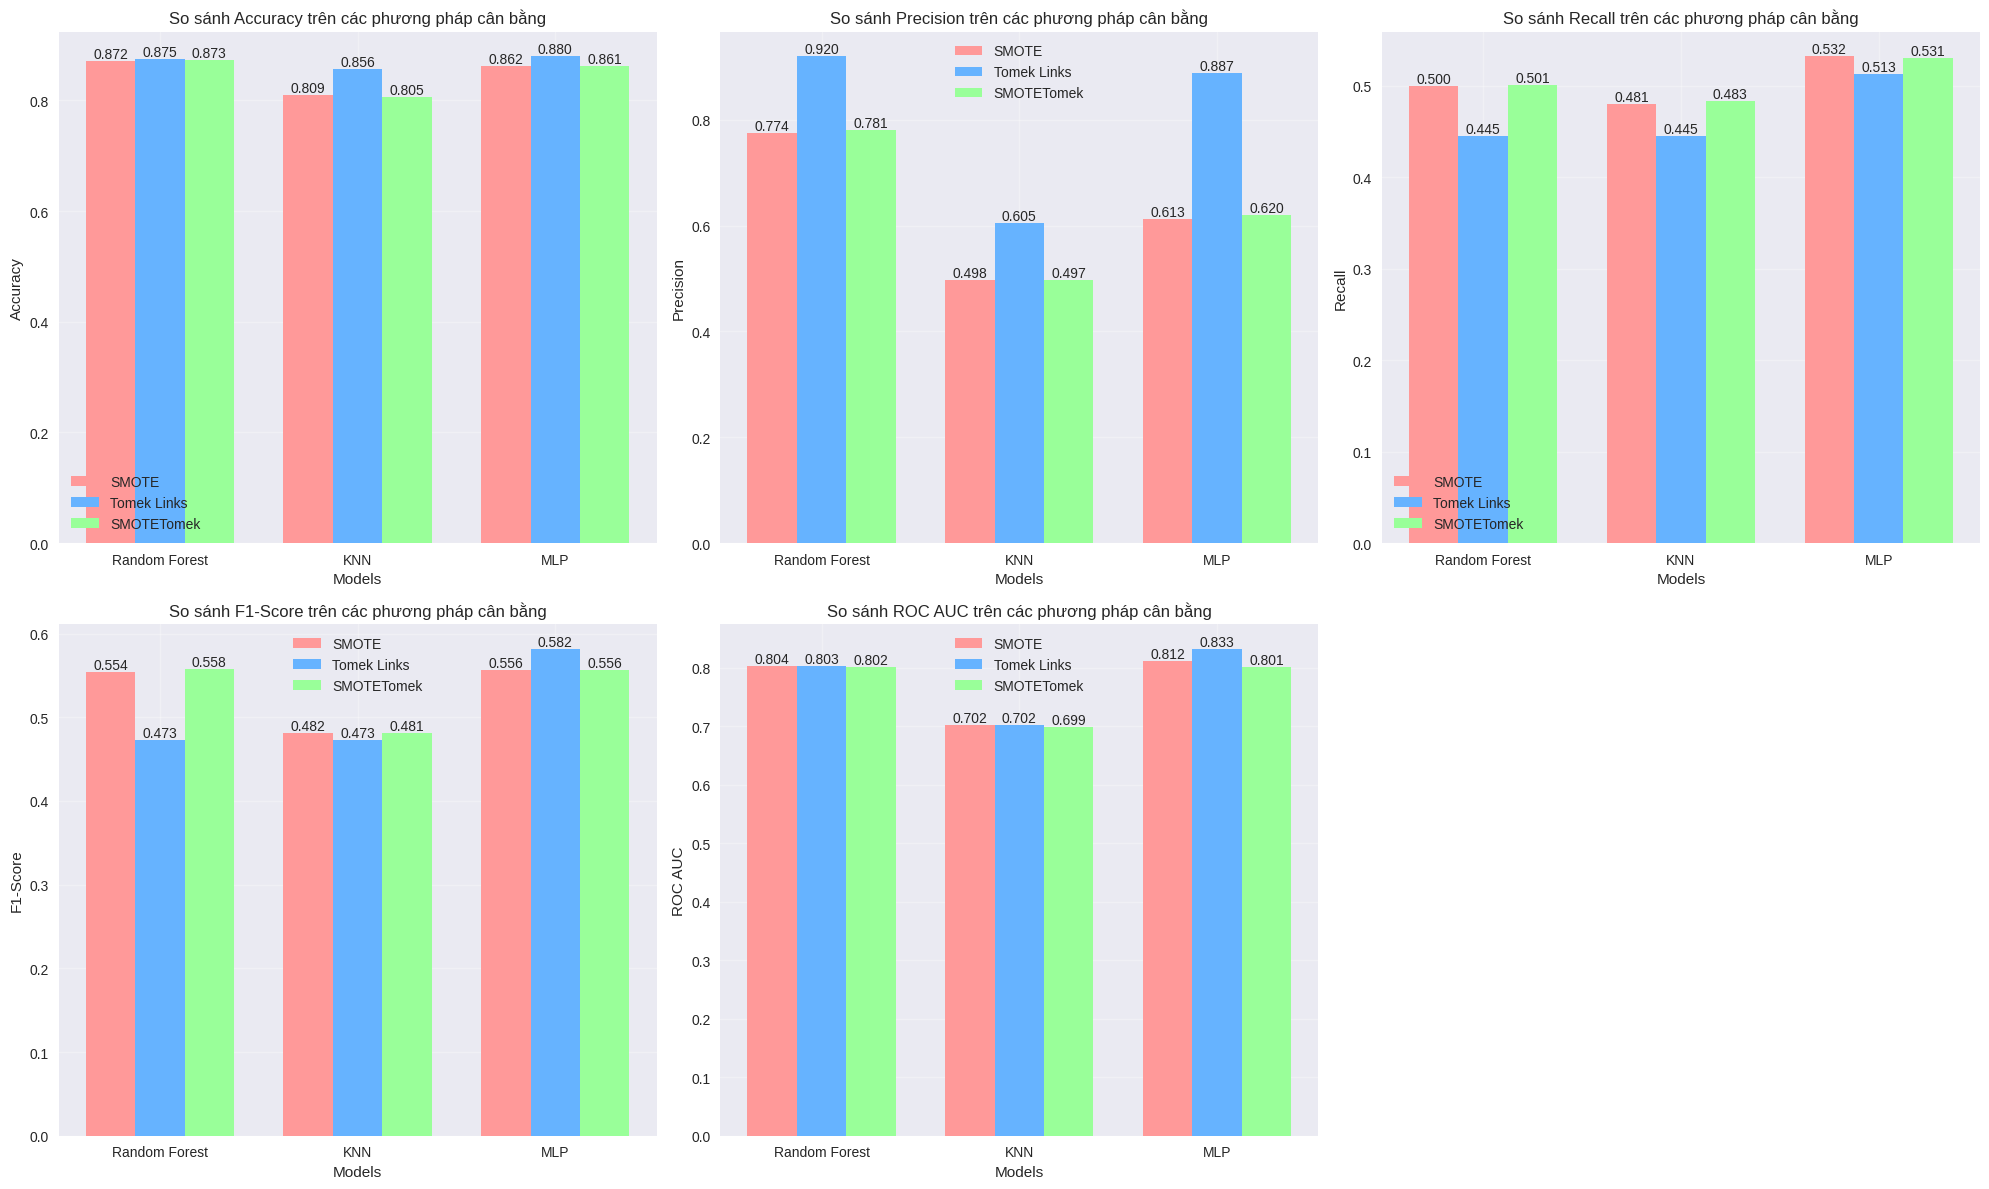

In [234]:
# So sánh 3 phương pháp cân bằng
compare_balancing_methods(smote_comparison_results,
                         tomek_comparison_results,
                         smte_comparison_results)

#### **6.4.2 So sánh kết quả trước và sau khi feature engineering**

In [236]:
# Chọn kết quả tốt nhất từ 3 phương pháp
best_results = pd.concat([smote_comparison_results,
                         tomek_comparison_results,
                         smte_comparison_results]).groupby('Model').max().reset_index()

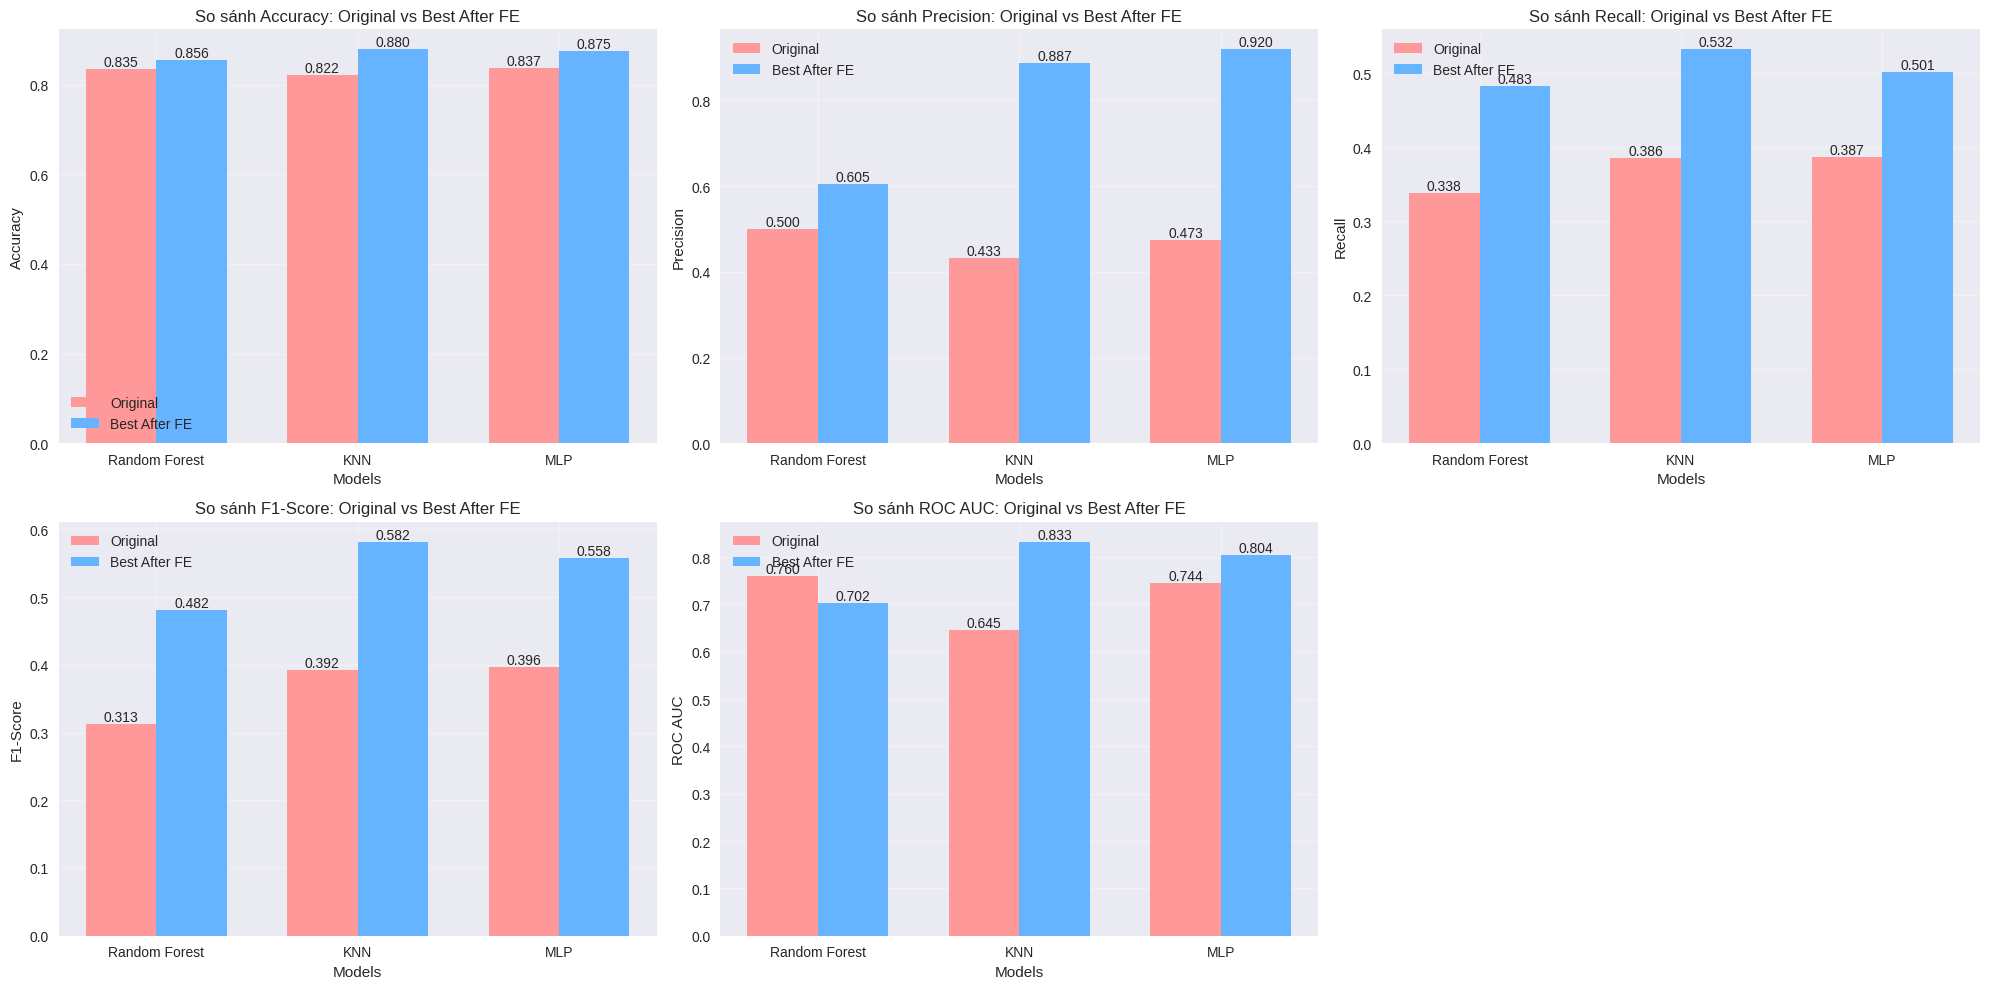

In [237]:
# So sánh với kết quả ban đầu
compare_best_vs_original(org_comparison_results, best_results)

Từ kết quả trực quan cho thấy, các mô hình được huấn luyện bằng dữ liệu sau khi đã thực hiện qua feature engineering, các mô hình đã được cải thiện rõ rệt vè kết quả đánh giá và khả năng nhận diện so với huấn luyện trên dữ liệu ban đầu.

Ta có thể thấy được quá trình feature engineering khá quan trọng vì nó sẽ giúp chúng ta cải thiện các đặc trưng hiện có từ dữ liệu thô, nhằm làm cho mô hình học máy (machine learning) có thể học và dự đoán hiệu quả hơn. Nó có vai trò cực kỳ quan trọng trong việc cải thiện hiệu suất của các mô hình và giúp các thuật toán học máy hoạt động chính xác hơn

Ngoài bước feature engineering, chúng ta còn có thể **đièu chỉnh tham số mô hình (hyperparameter)** để tìm ra tham số tốt nhất cho mô hình và từ đó cải thiện được độ chính xác và khả năng phân loại.

## **7. Hyperparameter**

Sau khi đã có được kết quả từ các mô hình, chúng ta sẽ tiến hành **tối ưu hóa các tham số (hyperparameter)** cho mô hình cho kết quả tốt nhất - Random Forest. Quá trình này sẽ giúp cải thiện thêm hiệu suất của mô hình.

Sử dụng `GridSearchCV` để tìm kiếm các tham số tối ưu cho mô hình Random Forest:
- `n_estimators: [200, 300]`
- `max_depth: [10, 15]`
- `max_features: ['sqrt', 'log2']`

In [240]:
# Định nghĩa các tham số cần tìm kiếm
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 15],
    'max_features': ['sqrt', 'log2']
}

In [241]:
# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=3,
    n_jobs=num_of_core,
    scoring='f1_macro'
)

In [242]:
# Thực hiện tìm kiếm
grid_search.fit(normalized_smote_X_train, resampled_smote_y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': [10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300]},
             scoring='f1_macro')

In [243]:
# In ra tham số tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 300}
Best cross-validation score: 0.7253542079616122


In [244]:
# Tạo mô hình với tham số tốt nhất
best_rf_model = RandomForestClassifier(**grid_search.best_params_)
best_rf_model.fit(normalized_smote_X_train, resampled_smote_y_train)

RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=300)

In [245]:
# Dự đoán với mô hình tốt nhất
best_rf_pred = best_rf_model.predict(normalized_smote_X_test)

In [246]:
# Đánh giá mô hình tốt nhất
print("\nKết quả đánh giá mô hình với tham số tốt nhất:")
evaluate_model(prced_y_test, best_rf_pred, "Random Forest with Best Parameters")


Kết quả đánh giá mô hình với tham số tốt nhất:
Kết quả đánh giá cho Random Forest with Best Parameters:
--------------------------------------------------
Accuracy: 0.8776
Precision (macro): 0.8377
Recall (macro): 0.5330
F1-score (macro): 0.5953

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93     36908
         1.0       0.88      0.18      0.30      1123
         2.0       0.75      0.44      0.55      6679

    accuracy                           0.88     44710
   macro avg       0.84      0.53      0.60     44710
weighted avg       0.87      0.88      0.86     44710



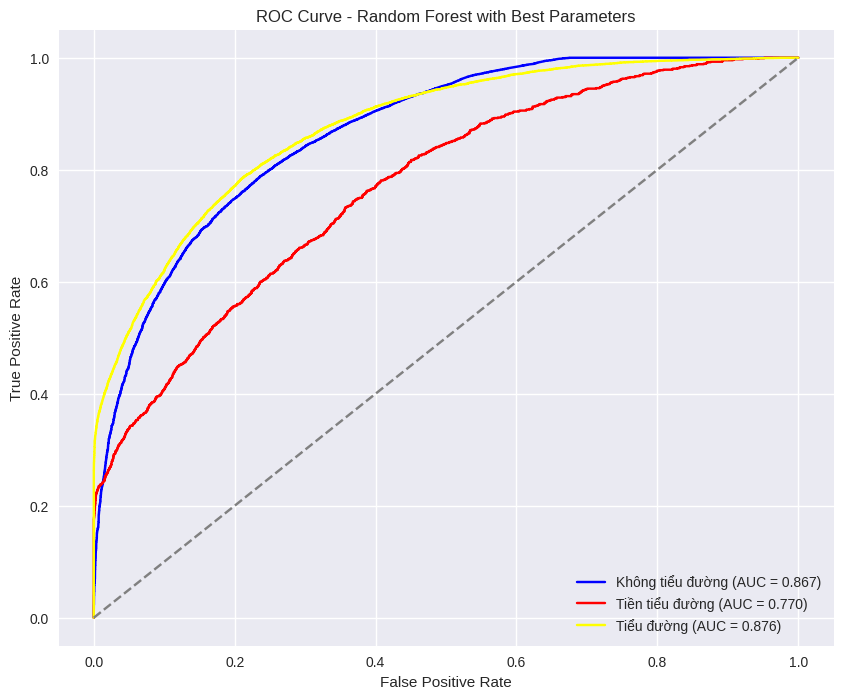

In [435]:
# Vẽ đường cong ROC
best_rf_proba = best_rf_model.predict_proba(normalized_smote_X_test)
plot_roc_auc(prced_y_test, best_rf_proba, "Random Forest with Best Parameters")

In [439]:
# Tính các metrics cho từng class
optimized_precision_per_class = precision_score(prced_y_test, best_rf_pred, average=None)
optimized_recall_per_class = recall_score(prced_y_test, best_rf_pred, average=None)
optimized_f1_per_class = f1_score(prced_y_test, best_rf_pred, average=None)

# Tạo DataFrame cho mô hình tối ưu với cùng cấu trúc như smote_comparison_results
optimized_results = {
    'Model': ['Random Forest (Optimized)'],
    'Accuracy': [accuracy_score(prced_y_test, best_rf_pred)],
    'Precision': [precision_score(prced_y_test, best_rf_pred, average='macro')],
    'Recall': [recall_score(prced_y_test, best_rf_pred, average='macro')],
    'F1-Score': [f1_score(prced_y_test, best_rf_pred, average='macro')],
    'ROC AUC': [roc_auc_score(prced_y_test, best_rf_proba, multi_class='ovr')]
}

# Thêm metrics cho từng class
for i in range(3):
    optimized_results[f'Precision-class{i}'] = (optimized_precision_per_class[i])
    optimized_results[f'Recall-class{i}'] = (optimized_recall_per_class[i])
    optimized_results[f'F1-class{i}']= (optimized_f1_per_class[i])

optimized_results = pd.DataFrame(optimized_results)

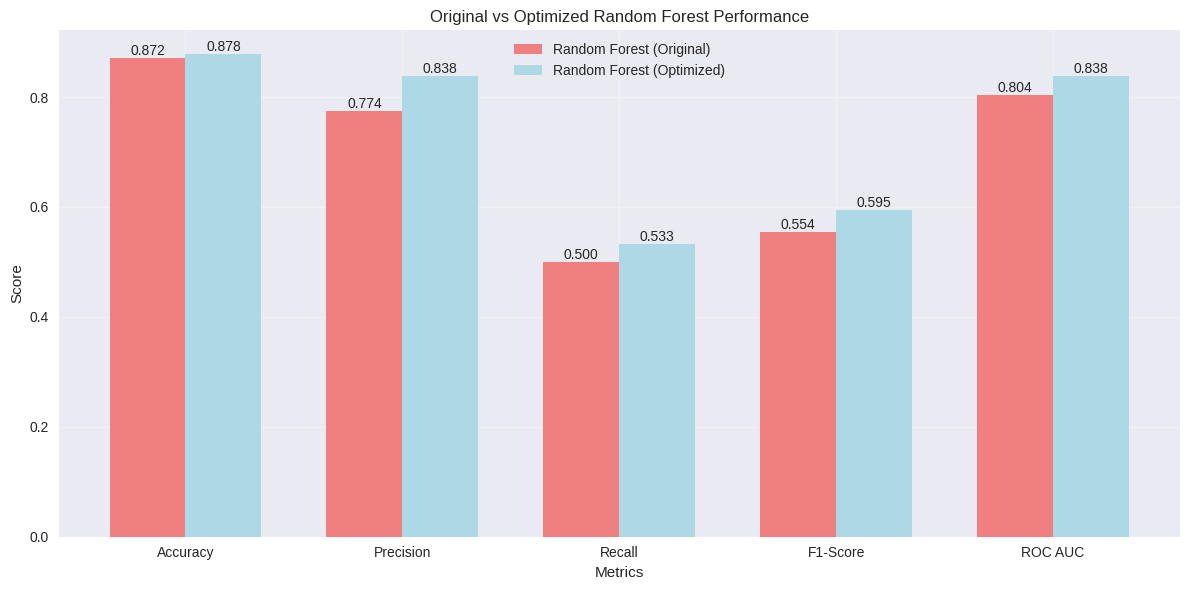

In [441]:
# Lấy kết quả Random Forest từ smote_comparison_results
original_rf = smote_comparison_results[smote_comparison_results['Model'] == 'Random Forest'].copy()
original_rf['Model'] = 'Random Forest (Original)'

# Kết hợp kết quả
comparison_df = pd.concat([original_rf, optimized_results], ignore_index=True)

# Visualize comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [original_rf[metric].values[0] for metric in metrics], width,
       label='Random Forest (Original)', color='lightcoral')
plt.bar(x + width/2, [optimized_results[metric].values[0] for metric in metrics], width,
       label='Random Forest (Optimized)', color='lightblue')

# Thêm giá trị lên đầu mỗi cột
for i in range(len(metrics)):
    plt.text(i - width/2, original_rf[metrics[i]].values[0],
             f'{original_rf[metrics[i]].values[0]:.3f}',
             ha='center', va='bottom')
    plt.text(i + width/2, optimized_results[metrics[i]].values[0],
             f'{optimized_results[metrics[i]].values[0]:.3f}',
             ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Original vs Optimized Random Forest Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [443]:
comparison_df

Model  Accuracy  Precision    Recall  F1-Score  \
0   Random Forest (Original)  0.871700   0.774500  0.500100   0.55440   
1  Random Forest (Optimized)  0.877567   0.837741  0.532957   0.59528   

    ROC AUC  Precision-class0  Precision-class1  Precision-class2  \
0  0.803700           0.87200            0.4599          0.991800   
1  0.837612           0.89013            0.8750          0.748092   

   Recall-class0  Recall-class1  Recall-class2  F1-class0  F1-class1  \
0       1.000000       0.229700       0.270500   0.931600   0.306400   
1       0.977918       0.180766       0.440186   0.931961   0.299631   

   F1-class2  
0   0.425100  
1   0.554246

## **8. Lưu mô hình và scaler**

Tiến hành lưu lại các mô hình và biến scaler

In [250]:
# Tạo thư mục để lưu các model và các  nếu chưa tồn tại
if not os.path.exists('output/models') and not os.path.exists('scalers'):
    os.makedirs('output/models')
    os.makedirs('output/scalers')

In [251]:

# Lưu các models từ SMOTE
joblib.dump(smote_random_forest_model, './output/models/smote_rf_model.joblib')
joblib.dump(smote_knn_model, './output/models/smote_knn_model.joblib')
joblib.dump(smote_mlp_model, './output/models/smote_mlp_model.joblib')

# Lưu model với best parameters
joblib.dump(best_rf_model, './output/models/best_rf_model.joblib')

['./output/models/best_rf_model.joblib']

In [252]:
# Lưu scaler
joblib.dump(smote_min_max_scaler, './output/scalers/smote_scaler.joblib')
joblib.dump(tomek_min_max_scaler, './output/scalers/tomek_scaler.joblib')
joblib.dump(smte_min_max_scaler, './output/scalers/smte_scaler.joblib')

print("Đã lưu các model và scaler thành công!")

Đã lưu các model và scaler thành công!
